In [1]:
from sklearn import svm, datasets
from sklearn.linear_model import HuberRegressor
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance
import time
import numpy as np
import MEArecTemplate as mr
from pathlib import Path
import MEAutility as mu
import LFPy
import matplotlib.pyplot as plt

In [3]:
%run ZIAD_MEARecHelperFunctions.ipynb

In [26]:
# Get all signals from the grid of electrodes that exceed a certain threshold
def get_strong_signals(data, elec_x, elec_y, thresh):
    data = data/np.max(abs(data))
    
    coords = []
    targets = []
    for i in range(len(data)):
        if np.max(abs(data[i])) >= thresh:
            coords.append([elec_x[i], elec_y[i]])
            
            # Target is 1 if signal is positive, 0 if negative
            targets.append(np.max(data[i]) > abs(np.min(data[i])))
            
    return np.array(coords), np.array(targets)

def get_electrodes(mea_name):
    mea_cells_folder = '/Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/'
    cell_name = 'L5_TTPC1_cADpyr232_1'
    cell_model_folder = Path(Path(mea_cells_folder) / cell_name)
    
    cell = mr.return_bbp_cell(cell_model_folder, end_T=1000, dt=0.03125, start_T=0)
    mea = mu.return_mea(mea_name)
    electrodes = LFPy.RecExtElectrode(cell, probe=mea)
    
    return electrodes

def get_electrodes2(mea_name):
    m_idx = mea_name.find('MEA')
    count = int(np.sqrt(int(mea_name[:m_idx])))
    pitch = int(mea_name[m_idx+3:])
    
    max_coord = (count - 1)*pitch/2.0
    coords = np.arange(-1*max_coord, max_coord+1, pitch)
    
    elec_x = []
    elec_y = []
    for xcoord in coords:
        for ycoord in coords:
            elec_x.append(xcoord)
            elec_y.append(ycoord)
    
    return np.array(elec_x), np.array(elec_y)

def make_meshgrid(x, y, h=.5):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out, Z

def load_cell(template_id, tempgen):
    # Load cell and position and rotation info
    mea_cells_folder = '/Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/'
    cell_name = 'L5_TTPC1_cADpyr232_1'
    cell_model_folder = Path(Path(mea_cells_folder) / cell_name)
    
    T = 1000
    dt = 0.03125
    cell = mr.return_bbp_cell(cell_model_folder, end_T=T, dt=dt, start_T=0)

    pos = tempgen.locations[template_id]
    rot = tempgen.rotations[template_id]

    cell = mr.ziad_flatten_geometry(cell, pos, rot, 10)
    cell.set_pos(pos[0], pos[1], pos[2])
    cell.set_rotation(rot[0], rot[1], rot[2])

    return cell

def get_apic_dist(template_id, all_y, all_z, clf, verbose=False):
    coords = np.zeros((2, np.shape(all_y)[1]))
    coords[0] = all_y[template_id]
    coords[1] = all_z[template_id]
    dists = abs(clf.decision_function(coords.T))/np.linalg.norm(clf.coef_)
    if verbose:
        print(dists)
    
    return np.mean(dists), np.std(dists)

def get_apic_dist_real(template_id, all_y, all_z, xx, yy, clf, boundary = [], verbose=False):
    coords = np.zeros((np.shape(all_y)[1], 2))
    coords[:, 0] = all_y[template_id]
    coords[:, 1] = all_z[template_id]
    
    if len(boundary) == 0:
        dists = distance.cdist(coords, get_boundary_coords(xx, yy, clf), 'euclidean')
    else:
        dists = distance.cdist(coords, boundary, 'euclidean')
        
    dists = np.min(dists, axis=1)
#     if verbose:
#         print(dists)
#         plt.hist(dists, bins=30)
        
    return np.mean(dists), np.std(dists), dists

def get_boundary_coords(xx, yy, clf):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    boundary = []
    for i in range(len(xx)):
        for j in range(1, len(xx[0])):
            if j > 0:
                if Z[i, j] != Z[i, j-1]:
                    #print("hit1")
                    midx = (xx[i, j] + xx[i, j-1]) / 2
                    midy = yy[i, j]
                    boundary.append([midx, midy])
            if i > 0:
                if Z[i, j] != Z[i-1, j]:
                    #print("hit2")
                    midx = xx[i, j]
                    midy = (yy[i, j] + yy[i-1, j]) / 2
                    boundary.append([midx, midy])
    #print(boundary)
    boundary = np.array(boundary)
    return boundary

def generate_noise(snr, sig, shape):
    noise = np.random.normal(size=shape)
    
    sig_pwr = np.sum(sig**2)
    noise_pwr = sig_pwr/(10**(snr/10))
    noise_coeff = np.sqrt(noise_pwr/np.sum(noise**2))
    noise = noise*noise_coeff
    
    new_noise_pwr = np.sum(noise**2)
    
    #print("SNR: ", 10*np.log10(sig_pwr/noise_pwr))
    return noise

def estimate_axon_hillock(signals, elec_x, elec_y, return_med = False):
    mags_pwr = np.sqrt(np.sum(signals**2, axis=1))
    mags_strong_indices = np.argsort(-1*mags_pwr)[:4]
    
    mags_relative_pwr = mags_pwr[mags_strong_indices] / np.sum(mags_pwr[mags_strong_indices])

    new_x = np.sum(elec_x[mags_strong_indices] * mags_relative_pwr)
    new_y = np.sum(elec_y[mags_strong_indices] * mags_relative_pwr)
    
    # Returns coordinates of other strong points
    if return_med:
        new_coords = []
        indices = np.arange(10, 100, 10)
        #indices = np.arange(4, 17, 4)
        for index in indices:
            mags_med_indices = np.argsort(-1*mags_pwr)[index:index+4]

            mags_relative_pwr_med = mags_pwr[mags_med_indices] / np.sum(mags_pwr[mags_med_indices])

            med_x = np.sum(elec_x[mags_med_indices] * mags_relative_pwr_med)
            med_y = np.sum(elec_y[mags_med_indices] * mags_relative_pwr_med)
            
            new_coords.append([med_x, med_y])
        
        return new_x, new_y, np.array(new_coords)
    
    return new_x, new_y

def get_lbf_points(signals, indices, elec_x, elec_y):
    mags_pwr = np.sqrt(np.sum(signals**2, axis=1))
    
    new_coords = []
    #indices = np.arange(10, 100, 10)
    #indices = np.arange(4, 17, 4)
    for index in indices:
        mags_med_indices = np.argsort(-1*mags_pwr)[index:index+4]

        mags_relative_pwr_med = mags_pwr[mags_med_indices] / np.sum(mags_pwr[mags_med_indices])

        med_x = np.sum(elec_x[mags_med_indices] * mags_relative_pwr_med)
        med_y = np.sum(elec_y[mags_med_indices] * mags_relative_pwr_med)

        new_coords.append([med_x, med_y])
        
    return np.array(new_coords)

def cast_lbf_to_boundary(lbf_coords, boundary):
    dists = distance.cdist(lbf_coords, boundary, 'euclidean')
    min_coord_idxs = np.argmin(dists, axis=1)
    cast_coords = boundary[min_coord_idxs]
    return cast_coords

def calc_lbf(ah_x, ah_y, point_coords, loss_func, weight, eps = 1.35):
    x = np.zeros((len(point_coords[:, 0]) + 1,))
    y = np.zeros((len(point_coords[:, 1]) + 1,))
    x[0] = ah_x
    y[0] = ah_y
    x[1:] = point_coords[:, 0]
    y[1:] = point_coords[:, 1]
    weights = np.ones((len(x),))
    weights[0] = weight
    
    if loss_func == 'Huber':
        huber = HuberRegressor(epsilon = eps)
        try:
            huber.fit(x[:, None], y, sample_weight = weights)
        except ValueError as e:
            print(f"Value error with eps = {eps} - retrying with different epsilon")
            return -1e8, -1e8
        y1 = huber.predict([[0]])
        y2 = huber.predict([[1]])
        m = (y2 - y1)
        b = y1
        
    elif loss_func == 'Normal':
        m, b = np.polyfit(x, y, 1, w = weights)
        
    return m, b

def load_cell(template_id, tempgen):
    # Load cell and position and rotation info
    mea_cells_folder = '/Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/'
    cell_name = 'L5_TTPC1_cADpyr232_1'
    cell_model_folder = Path(Path(mea_cells_folder) / cell_name)
    
    T = 1000
    dt = 0.03125
    cell = mr.return_bbp_cell(cell_model_folder, end_T=T, dt=dt, start_T=0)
    
    pos = tempgen.locations[template_id]
    rot = tempgen.rotations[template_id]

    cell = mr.ziad_flatten_geometry(cell, pos, rot, 10)
    cell.set_pos(pos[0], pos[1], pos[2])
    cell.set_rotation(rot[0], rot[1], rot[2])

    return cell

def remove_outliers(n_neighbors, cast_coords, max_range):
    # Remove outliers
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(cast_coords)
    distances, indices = nbrs.kneighbors(cast_coords)
    avg_dists = np.mean(distances[:, 1:], axis=1)
    
    cast_coords_no_outliers = []
    for i in range(len(avg_dists)):
        if avg_dists[i] < max_range:
            cast_coords_no_outliers.append(cast_coords[i])
    return np.array(cast_coords_no_outliers)

def gen_modified_coords(clf, signals, elec_x, elec_y, xx, yy, coords, params):
    
    min_dist = params['min_dist']
    max_dist = params['max_dist']
    num_points = params['num_points']
    
    opp_dist = params['opp_dist']
    
    # Get boundary estimation (true/false values assigned to dense coordinate map) and cast to boolean
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    Z = (Z != 0)
    
    # Estimate axon hillock as well as direction of neuron
    ah_x, ah_y, new_coords = estimate_axon_hillock(signals, elec_x, elec_y, return_med = True)
    
    # Calculate line of best fit - assign half the points to be identical (axon hillock)
    mult = 2
    fit_coords = np.zeros((len(new_coords)*(mult+1), 2))
    fit_coords[:len(new_coords)*mult, 0] = ah_x
    fit_coords[:len(new_coords)*mult, 1] = ah_y
    fit_coords[len(new_coords)*mult:, 0] = new_coords[:, 0]
    fit_coords[len(new_coords)*mult:, 1] = new_coords[:, 1]
    m, b = np.polyfit(fit_coords[:, 0], fit_coords[:, 1], 1)
    
    # Find points above line
    q = yy > (xx*m + b)
    
    # Determine whether points above line are mostly in category 0 or 1 of SVM
    greater_than_category = np.sum(q & Z)/np.sum(q) > 0.5
    
    # Generate points close to axon_hillock along line of best fit at specified distances
    nearby_dists = np.linspace(min_dist, max_dist, num_points)

    # Find closest point to (ah_x, ah_y) on line
    b2 = ah_y + ah_x/m
    ah_x2 = (b2 - b)/(m + 1/m)
    ah_y2 = m*ah_x2 + b

    # Get nearby points along line of best fit
    nearby_x = nearby_dists/np.sqrt(1 + m**2) + ah_x2
    nearby_y = m*nearby_x + b

    # Get one point one either side of each of those points along the line perpendicular to line of best fit
    b_vals = nearby_y + nearby_x/m
    opposite_dists = np.arange(-1*opp_dist, opp_dist + 0.1, 2*opp_dist)
    opposite_x = np.add.outer(opposite_dists/np.sqrt(1 + (1/m)**2), nearby_x)
    b_vals = np.ones(np.shape(opposite_x)) * b_vals
    opposite_y = -1*opposite_x / m + b_vals

    # Generate modified coordinates and targets
    mod_coords = np.zeros((len(coords)+np.shape(opposite_x)[1]*np.shape(opposite_x)[0], 2))
    mod_coords[:len(coords), :] = coords
    mod_coords[len(coords):len(coords)+len(opposite_x[0]), 0] = opposite_x[0, :]
    mod_coords[len(coords):len(coords)+len(opposite_x[0]), 1] = opposite_y[0, :]
    mod_coords[len(coords) + len(opposite_x[0]):len(coords)+len(opposite_x[0])*2, 0] = opposite_x[1, :]
    mod_coords[len(coords) + len(opposite_x[0]):len(coords)+len(opposite_x[0])*2, 1] = opposite_y[1, :]

    mod_targets = np.zeros((len(mod_coords),))
    mod_targets[:len(targets)] = targets[:]
    mod_targets[len(targets):np.shape(opposite_x)[1] + len(targets)] = not greater_than_category
    mod_targets[len(targets) + np.shape(opposite_x)[1]:np.shape(opposite_x)[1]*2 + len(targets)] = greater_than_category

    return mod_coords, mod_targets

def gen_modified_coords2(clf, signals, elec_x, elec_y, xx, yy, coords, boundary, params):
    
    min_dist = params['min_dist']
    max_dist = params['max_dist']
    num_points = params['num_points']
    
    opp_dist = params['opp_dist']
    weight = params['weight']
    eps = params['epsilon']
    max_range = params['max_range']
    
    # Get boundary estimation (true/false values assigned to dense coordinate map) and cast to boolean
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    Z = (Z != 0)
    
    ah_x, ah_y, new_coords = estimate_axon_hillock(signals, elec_x, elec_y, return_med = True)

    indices = np.arange(4, 200, 4)
    new_coords = get_lbf_points(signals, indices, elec_x, elec_y)
    cast_coords = cast_lbf_to_boundary(new_coords, boundary)
    cast_coords = remove_outliers(4, cast_coords, max_range)
    m, b = calc_lbf(ah_x, ah_y, cast_coords, 'Normal', weight, eps = eps)
    
#     for i in range(3):
#         m, b = calc_lbf(ah_x, ah_y, cast_coords, 'Huber', weight, eps = eps)
#         if m != -1e8 and b != -1e8:
#             break
#         else:
#             eps += 0.05
            
#     if m == -1e8 and b == -1e8:
#         m, b = calc_lbf(ah_x, ah_y, cast_coords, 'Normal', weight, eps = eps)

    q = yy > (xx*m + b)
    greater_than_category = np.sum(q & Z)/np.sum(q) > 0.5

    # Points close to axon_hillock along line of best fit
    nearby_dists = np.linspace(min_dist, max_dist, num_points)
    #nearby_dists = np.arange(-5, 5.1, 0.01)*5

    # Find closest point to (ah_x, ah_y) on line
    b2 = ah_y + ah_x/m
    ah_x2 = (b2 - b)/(m + 1/m)
    ah_y2 = m*ah_x2 + b
    #print(ah_x, ah_x2)

    # Get nearby points along line of best fit
    nearby_x = nearby_dists/np.sqrt(1 + m**2) + ah_x2
    nearby_y = m*nearby_x + b

    #print(np.sqrt((nearby_x - ah_x2)**2 + (nearby_y - (ah_y2))**2))

    # Get one point one either side of each of those points along the line perpendicular to line of best fit
    b_vals = nearby_y + nearby_x/m
    opposite_dists = np.arange(-2, 2.1, 4)*5
    opposite_x = np.add.outer(opposite_dists/np.sqrt(1 + (1/m)**2), nearby_x)
    b_vals = np.ones(np.shape(opposite_x)) * b_vals
    opposite_y = -1*opposite_x / m + b_vals

    # Re-calculate SVM with modified coordinates
    mod_coords = np.zeros((len(coords)+np.shape(opposite_x)[1]*np.shape(opposite_x)[0], 2))
    mod_coords[:len(coords), :] = coords
    mod_coords[len(coords):len(coords)+len(opposite_x[0]), 0] = opposite_x[0, :]
    mod_coords[len(coords):len(coords)+len(opposite_x[0]), 1] = opposite_y[0, :]
    mod_coords[len(coords) + len(opposite_x[0]):len(coords)+len(opposite_x[0])*2, 0] = opposite_x[1, :]
    mod_coords[len(coords) + len(opposite_x[0]):len(coords)+len(opposite_x[0])*2, 1] = opposite_y[1, :]

    mod_targets = np.zeros((len(mod_coords),))
    mod_targets[:len(targets)] = targets[:]
    mod_targets[len(targets):np.shape(opposite_x)[1] + len(targets)] = not greater_than_category
    mod_targets[len(targets) + np.shape(opposite_x)[1]:np.shape(opposite_x)[1]*2 + len(targets)] = greater_than_category

    return mod_coords, mod_targets

In [ ]:
# Run for all cells

snrs = [40, 20, 0]
mea_names = ['400MEA50', '400MEA75', '400MEA100']
file_prefix = 'mag_templates_flattened_morphology_L5_TTPC1_cADpyr232_1_n300_'

for snr in snrs:
    for mea_name in mea_names:
        # Parameters
        #mea_name = '400MEA50'
        thresh = 0.0
        #snr = 40
        iters_per_cell = 1
        C = 0.1
        gamma = 0.1
        cells = range(300)
        
        print(snr, mea_name)

        # Load template
        #templates_file = f'ziad_mearec_templates/mag_templates_flattened_morphology_L5_TTPC1_cADpyr232_1_n300_{mea_name}.h5'
        #tempgen = mr.tools.load_templates(templates_file, verbose=False)

        # Get apical dendrite coordinates and extracellular magnetic fields
        with open(f'{file_prefix}{mea_name}.npy', 'rb') as f:
            all_y = np.load(f)
            all_z = np.load(f)
            mags = np.load(f)


        # Main loop
        elec_x, elec_y = get_electrodes2(mea_name)
        xx, yy = make_meshgrid(np.array(elec_x), np.array(elec_y))

        dists = np.zeros((len(cells), iters_per_cell))
        dists_std = np.zeros((len(cells), iters_per_cell))
        dists_list = []
        dists_std_list = []
        fails = 0
        for n, template_id in enumerate(cells):
            #print("Template ID: ", template_id)
            for itr in range(iters_per_cell):
                #start = time.time()
                #elec_x, elec_y = get_electrodes2(mea_name)

                #cell = load_cell(template_id, tempgen)

                # Generate noise according to SNR parameter
                noise = generate_noise(snr, mags[template_id], np.shape(mags[template_id]))

                # Extract signals with magnitude that exceeds threshold
                signals = mags[template_id] + noise
                coords, targets = get_strong_signals(signals, elec_x, elec_y, thresh)
                
                # Estimate axon hillock based on strongest signals
                #ah_x, ah_y = estimate_axon_hillock(mags[template_id] + noise, elec_x, elec_y)
                #real_x = all_y[template_id][0]
                #real_y = all_z[template_id][0]
                #est_dist = np.sqrt((real_x - ah_x)**2 + (real_y - ah_y)**2)
                #print("Estimated axon hillock distance: ", est_dist)

                # Apply SVM to coordinates of strong signals 
                model = svm.SVC(kernel="rbf")
                clf = model.fit(coords, targets)
                boundary = get_boundary_coords(xx, yy, clf)
                
                # Generate modified coordinates and calculate new SVM
                params = {}
                params['min_dist'] = -25
                params['max_dist'] = 25
                params['num_points'] = 1000
                params['opp_dist'] = 10
                params['weight'] = 100
                params['epsilon'] = 1.2
                params['max_range'] = 50
                mod_coords, mod_targets = gen_modified_coords2(clf, signals, elec_x, elec_y, xx, yy, coords, boundary, params)
                mod_model = svm.SVC(kernel='rbf')
                mod_clf = mod_model.fit(mod_coords, mod_targets)

                mod_boundary = get_boundary_coords(xx, yy, mod_clf)
                boundaries = [boundary, mod_boundary]
                
#                 if len(boundary) != 0:
#                     dist, std, all_dists = get_apic_dist_real(template_id, all_y, all_z, xx, yy, clf, boundary = boundary)
#                     print("Original dist: ", dist)
                
                if len(mod_boundary) != 0:
                    dist, std, all_dists = get_apic_dist_real(template_id, all_y, all_z, xx, yy, clf, boundary = mod_boundary)
                    #print("Modified dist: ", dist)
                    for i in range(len(all_dists)):
                        print(all_dists[i], end='\t')
                    #print()

                else:
                    dist = 10000000
                    std = 1000000
                
                print()
                #print('Dist: ', dist)
                if dist < 10000000:
                    dists[n, itr] = dist
                    dists_std[n, itr] = std
                    dists_list.append(dist)
                    dists_std_list.append(std)
                else:
                    fails += 1
                #print("Time: ", time.time()-start)

40 400MEA50
3.1973914087891693	3.178756054508243	3.1662127505807813	3.093358894152531	3.0644191080339422	3.048460478337996	2.9559414249661513	2.9522144343059162	2.932579571626872	2.9195304280092467	2.866003630937849	2.818768801371704	2.8019970213024123	2.7279889138780153	2.707321442666385	2.6864928561348633	2.672873078143974	2.642125502574676	2.5733234223042363	2.5555833230549623	2.545438487381692	2.9168943756956223	3.180619608434038	3.0365023110913447	3.0373429573871484	2.8946179675871746	2.9246375641178246	2.7866583388112	2.8588891166983172	2.821247727232253	2.821247727232253	2.5287159705559445	2.313180328225437	2.230774329910131	2.1765370701993954	2.034873321520516	2.0884523619620725	2.0270532136165476	2.2080496088532087	2.2080496088532087	2.2087351882862594	2.1995812116536246	2.2785078101647045	2.308929940143738	2.401828400454892	2.423271111017643	2.423271111017643	2.265572826066335	2.398829412252273	2.4603601104280926	2.5119116512641013	2.655935089994675	2.655935089994675	2.783546

7.915968354442538	7.887081086209416	7.860625324834285	7.836619646492038	7.8150972514818795	7.658694762863127	7.650969455041167	7.633333780646326	7.60177761528185	7.572717519039795	7.3835036484847025	7.368435017504972	7.356046850123366	7.346351785746776	7.245179038069653	7.130186963902096	7.107268255175654	7.08708942869368	6.939891800776617	6.935002761567855	6.901154439064917	6.599428456265371	6.205832974790248	6.067935915448468	5.846344622212815	5.673795899622523	5.571266799006228	5.231758692323659	5.00603849380682	4.834497387655055	4.834497387655055	4.964624338967467	5.053025612675738	4.926387702943629	4.754835639387879	4.552973891435325	4.446779484936884	4.092947949226592	3.6867528032137957	3.6867528032137957	3.4320301460853244	3.2259930273526667	2.9825486967988604	2.6863922182990696	2.363803691483496	2.4256849822483093	2.4256849822483093	2.1833083099379387	1.7522339755486989	1.423121544827182	1.222842228364628	1.1406083384680128	1.1406083384680128	0.7792679554386198	0.54376829724172

8.883475510457654	8.907760772635418	8.880066426233208	8.753315007017235	8.66806011268446	8.676208268984666	8.632410146409901	8.568063918363709	8.528480959670366	8.40450086564992	8.478307081751913	8.389697278341092	8.286496779479448	8.33953029242549	8.26029537846721	8.178635446641318	8.18252074741671	8.140720944736705	8.081307284464053	8.034497302502936	8.031421394414691	7.745645599863819	7.351453632850225	7.278979353396502	7.264388257196302	7.070085683696222	7.025104703725101	6.899536852848509	6.864871875917247	6.793474078679676	6.793474078679676	6.947899551784274	7.218826945212075	7.116526831393418	7.197292458492994	7.2542449269084015	7.255127458126775	7.1476231560643	6.831440032658345	6.831440032658345	6.812084822017958	6.746096886651639	6.710969403835031	6.724040215267277	6.682583917743966	6.5839282268536765	6.5839282268536765	6.537879306201394	6.552451353642845	6.354421271559871	6.30298050243656	6.240851617193732	6.240851617193732	6.085288186003189	5.13331418795874	4.22333437956256

6.420029259077518	6.166166084512417	5.912324873447724	5.738719701413702	5.758120582102263	5.504257894930219	5.250417190693312	4.996554623617432	4.783957370569327	4.842361377591423	4.58852197212175	4.334682788785298	4.080821990729663	3.957260244566335	3.926648185331784	3.6728122866801787	3.418955371360629	3.4529950217032623	3.2648045978720397	3.010975973862624	2.9471169980088257	3.7487719345393127	3.3869583864391064	3.156954238989787	2.757888520370925	2.428927947429743	2.2434882694996707	1.8145571483718022	1.592008821442413	1.4305735286223444	1.4305735286223444	1.0598245637600772	0.6712664453108165	0.3971378539435974	0.12296194999330864	0.09952420094626417	0.4311547382570134	0.42737496748441856	0.43521116452116426	0.43521116452116426	0.3674243160322501	0.6299481618604318	0.5894869001636263	0.6380775195408805	0.7101502651848551	0.5278075492736563	0.5278075492736563	0.5901980151335429	0.8563828419712824	0.7749135865992558	0.8788814734900561	0.8331900210910514	0.8331900210910514	0.44910735

12.15522877543303	12.096884987193715	11.988853411735878	11.911493947204118	11.717014222975562	11.671085468494041	11.538996919056654	11.51680529724826	11.363848831084633	11.348847449694025	11.191704667951415	11.157041115962121	11.022710383426894	10.967742577726252	10.857002147469279	10.781083934392989	10.69473841777139	10.597204683818333	10.536078339691452	10.416258159421847	10.381187142944334	10.124034805695427	9.618344988488603	9.449347349647999	9.295016561061171	9.12218895764529	8.962338545334998	8.7019439731064	8.472546020539907	8.30967199572067	8.30967199572067	8.452727515717614	8.441822589626554	8.367828699320052	8.243312905527722	8.267490357490278	8.200876167165104	7.874644395036126	7.616995228272552	7.616995228272552	7.418525092360805	7.247194863310636	7.242889017776182	6.916329208451625	6.8193444767285225	6.8306933356180775	6.8306933356180775	6.641230194887196	6.401753662352551	6.155891403947409	6.108060703238461	5.931656013242873	5.931656013242873	5.711979632696314	4.673145262

14.228877559487298	14.164153291639659	14.114731193706763	14.166076861726816	14.224749437583776	14.09586644880816	14.109475559907251	14.168227117666161	14.125125307470762	14.054504186013743	14.101170504060411	14.02765066886786	13.986843443650232	14.040304461983485	13.936053655810325	13.925418521304218	13.979982933094046	13.850454800611136	13.870312265539702	13.870732606689609	13.770984412733082	13.437977267027906	13.125851442517133	13.12572256768016	12.968134633118195	12.875097332145327	12.745955879820153	12.52946812826029	12.318240668055036	12.202652965365939	12.202652965365939	12.380195902341065	12.48169226547585	12.378312606301817	12.294424544678463	12.249682249481575	12.008835286644942	11.733806053127209	11.373267037974916	11.373267037974916	11.177848472420326	10.972977922318659	10.853833089478343	10.501682420115129	10.419258219675106	10.285379542478342	10.285379542478342	10.068473034159343	9.761850538833524	9.370084361808066	9.216041540378955	9.004808517998665	9.004808517998665	8.7

1.001844335272552	0.9942538177299977	1.0885192969657331	1.1632168554625475	1.0578615791440236	0.9601242502791536	0.9675014399431846	1.077881354572705	1.117916475916773	1.0847062963183098	0.9200240046104209	0.943468187431243	1.0701907400368134	1.0737507880223804	1.0531806623516649	1.1300350852549053	1.2374697732612978	1.065509254708279	1.0308311805830148	1.0238616339555222	1.1160048389856587	0.6734322236613907	0.5188830390351995	0.5391350607480541	0.6315977771256202	0.5434446136344643	0.5136638847425843	0.6417141981340196	0.6232875625150113	0.5902354356224786	0.5902354356224786	0.7844017483096719	1.0144232535857527	1.081400576123987	1.2091581635869346	1.1267415886126044	1.2704562646611024	1.202477858273654	1.0995541287083719	1.0995541287083719	1.164247998101412	0.8868423936111871	0.9853257455234289	0.7869496042858193	0.9353126042670983	0.9284078622011405	0.9284078622011405	0.9731703924735005	0.7175406263731594	0.7588815401065269	0.6366318787602462	0.6805453802888293	0.6805453802888293	0

1.078656318128889	0.9375187217561648	0.9910763205175628	1.1246708279291406	0.9052598339075131	1.0396187481727202	1.1741382345990354	0.9566813151523005	1.0916574404093815	1.0325420551852342	1.0115965181140902	1.14421180246253	0.923509463430548	1.0527542171881923	0.9442032270627255	0.9622395208116347	1.0938471429815706	0.8729612841683438	1.0056265045242039	1.138879448041969	0.9190323047185942	0.5610162754218418	0.49557170195013245	0.4594470350396707	0.40579531343482106	0.3045937726587474	0.2920468388480571	0.31792217943204065	0.42705199328481064	0.3540625901745036	0.3540625901745036	0.6414610508918511	0.9336644489062272	0.9900637237186927	1.0134915354988745	0.9556593026546587	0.9859116256171604	0.9984050813492339	0.8641062774059006	0.8641062774059006	1.0188790874099254	0.8305853495884825	0.7113573641825652	1.0095289806943297	0.8729236800752399	0.9543284282419363	0.9543284282419363	0.7862334406907544	0.7532562745920153	0.728562532545048	0.909521709725456	0.7298519995083974	0.7298519995083

1.6423909963667458	1.7172924781320003	1.7926869400126186	1.868514707802893	1.9447250964083638	1.7022130741074584	1.7446640098797226	1.8218940824242156	1.8994028868873556	1.9771677969114108	2.0551404727921696	2.133307283917202	1.9212787588148992	1.9316536208782091	2.0064199438787105	2.0816205250423203	2.157209949982047	2.233148733350847	1.9558564398446219	2.032392145706418	2.1092400795230386	1.5860210271036514	1.6073013972583574	1.4331846254313565	1.609567269916156	1.5678872037390776	1.5689572362952429	1.458468963426906	1.372108512224481	1.535963286247536	1.535963286247536	1.7744003722083141	1.9039168805846771	1.8261982330036735	2.055356438287694	1.9012590692537863	1.8004994749241725	1.8605550407533415	1.5951902877609518	1.5951902877609518	1.3908334754769074	1.48571876017784	1.2461851457932263	1.057415299241892	1.113836381457972	0.8560050781135025	0.8560050781135025	0.9395342700595046	0.7368883744945939	0.5279011114351859	0.2798380394000974	0.3994301361939542	0.3994301361939542	0.207452

88.29753782834986	86.85671583695462	85.41589885958871	83.97511836227187	82.53436258412904	81.09362802657678	79.65291832228078	78.21223484467049	76.77157907024356	75.3309548368341	73.89035934104089	72.44979669996303	71.00926891316807	69.56878030965647	68.12832888650748	66.68790415890118	65.2475393462094	63.80722431795448	62.36695822443448	60.92674677490803	59.48659393828155	62.838775531814605	57.712146219745186	54.37886845566896	51.003269556751825	48.2443893562499	45.207814730480614	40.66487463695282	35.49085622725472	32.539585379355465	32.539585379355465	31.422452576848286	27.433861669919263	23.662542230647396	20.364828076609065	17.62146956529508	14.130811962642627	9.92434906713688	6.558816883629307	6.558816883629307	3.2023562337446374	1.1858513808676803	1.5605529366090234	5.190894018762422	7.730385938871781	8.747174983419402	8.747174983419402	11.034183719366546	15.159101440026785	19.01403506739822	21.839715988248244	24.16467854805647	24.16467854805647	24.704953189296152	27.70324610719

14.931663820132544	14.75754986808227	14.72315544229446	14.666371544793007	14.420830975913747	14.316899586640707	14.304533201885736	14.033741813500344	13.90782293547382	13.915338056841955	13.746784554929684	13.545589177471605	13.496193011624184	13.500631945935709	13.221315425451508	13.095596240359157	13.107605196418772	12.9378583243916	12.732119108864216	12.687827817792945	12.697951625875612	13.186947102876402	12.95943341011341	12.912721052500242	12.485153636670795	12.331680341041732	12.087279714518811	11.672929880681664	11.279526962853977	11.233965326522629	11.233965326522629	10.83004994561792	10.36742040435524	9.971850234222531	9.556835040425417	9.47679542374269	8.993319353971454	8.878085629560616	8.877972425934525	8.877972425934525	8.529571557855615	8.53180986727167	8.283874607436282	8.21497102468549	7.926846676976712	7.8304324521233895	7.8304324521233895	7.899121899404293	7.542741313350324	7.358817026626404	7.280102112278575	7.284788910928875	7.284788910928875	7.315843340255125	8.15

25.32222446132305	24.794411617297975	24.26860032361869	23.789780904072984	23.39013553965729	22.91592836085001	22.39170433540588	21.87603861919413	21.44502494400781	21.032472428376664	20.504372020550605	19.978702065104805	19.510505617942552	19.13965802426256	18.626713160041806	18.106777310233795	17.67908661547016	17.27412088258619	16.76196664562778	16.36116287100289	15.913835501457871	17.29785252651837	15.824088553292308	14.82337386510056	13.814613903502336	12.918018687682398	12.061870059014359	10.71161652920667	9.058149561698361	8.210168200546187	8.210168200546187	7.784863474808786	6.32599599181696	5.160831987898985	4.22024402924994	3.3866870751736653	2.3426211175619884	1.0537709038113394	0.5314719846485523	0.5314719846485523	0.4132848699128131	0.9349420251969578	1.647284059930784	2.4333958669716718	3.0617893217993926	3.243448250630648	3.243448250630648	3.8752985662191546	4.9312378441748566	5.960667842956464	6.534703559952439	7.110422499024755	7.110422499024755	7.141905471697845	6.8322

0.8091809256427587	0.7392346375437779	0.6080127040227116	0.6135951607136584	0.43839020033889403	0.560473937689513	0.3497046309738695	0.49769858992795535	0.3057151735895625	0.46835040113151544	0.2810746883550173	0.27684957434503515	0.1899958530353542	0.05008128032864461	0.24391183301287425	0.18783227605988195	0.29228687855031144	0.12878498985614226	0.32193377533470535	0.18783376105497623	0.21325269980587463	0.24861939518861936	0.13858557420030632	0.2576897592684917	0.16419682935589539	0.12623699869776597	0.11777085108471216	0.2910403222766743	0.27063929851569307	0.32928418299981327	0.32928418299981327	0.4688506667131473	0.8755908759748688	1.0186824233021563	1.1523911948256553	1.139460897301678	1.2527494416105505	1.3807780170686113	1.1776629051819751	1.1776629051819751	1.2981885792866665	1.2809442135798537	1.347653899760892	1.1069083513815334	1.2409528055702523	1.2260649669158383	1.2260649669158383	1.2851805621468304	1.0426972338066711	1.0689914192204184	1.1648071208117967	1.070184965545

9.107296786194725	8.983107222381758	8.920230860805546	8.880495156856059	8.755775489762687	8.7008735094495	8.653809544949006	8.630299295129456	8.555689846609987	8.427299956698779	8.413077267804496	8.330014808163712	8.200920504719308	8.196545787934898	8.104518586791567	7.9747329978998	7.980690283006515	7.879266151587511	7.74871397512222	7.765653403480153	7.654240603932441	7.3928507431462895	6.904783155226399	6.832757706867342	6.6143750722159576	6.528583294914854	6.435241205498819	6.217416141771672	5.866417979128232	5.771631936221761	5.771631936221761	5.840214780117366	6.044906808467694	5.854056714384749	5.733798833532643	5.69494442116636	5.640155535684629	5.392181167115903	4.997409771938244	4.997409771938244	4.828481883991266	4.675416886502661	4.55445248764706	4.305260249011551	4.205835311111685	4.129624944354545	4.129624944354545	3.8705119068391474	3.586940887313478	3.350321657837025	3.2023809506495398	3.009214849966683	3.009214849966683	2.8699832143857598	1.5868898835907772	0.608813587

0.8474140309421676	0.5474319555298461	0.6371805560181414	0.5332991717999189	0.3950822135324691	0.5484115397915514	0.17714310067182135	0.22827952266886106	0.35387985201631844	0.22239092002669184	0.21764359511954015	0.22122146745621007	0.2419879855152602	0.14205936079506293	0.24515099765428458	0.23300596132907306	0.20875208819100813	0.10931482814256765	0.18085937011447883	0.10502915313931219	0.25105759503687236	0.3848470161402628	0.3761834714905739	0.5344995247507491	0.6019553686756742	0.3908937365445384	0.5696056008119929	0.3691659972231669	0.49841779008743936	0.7091736626243764	0.7091736626243764	0.408515090775213	0.4100799899090154	0.4228490527653383	0.24647963451372787	0.15713829193421353	0.16085247779004108	0.4127458692907583	0.5289377305154975	0.5289377305154975	0.8224554839464042	0.7847768867711431	0.8340213626923979	0.9089562565065666	1.219461549066455	1.2181774311186417	1.2181774311186417	1.3650808747799712	1.4334857196334072	1.5763269827694741	1.7426868530662536	2.0407804545174

16.547392097911708	16.391322774351462	16.359844960360565	16.219307808292484	16.174073284366045	15.975520921776912	15.879740619827752	15.787172979052468	15.606273634700445	15.557396423357062	15.388700110289692	15.253226951013453	15.203110973490679	15.005198468527768	14.917501897329197	14.81613071810039	14.637830304488158	14.60032302990852	14.417578116189384	14.287825865080189	14.232190006904208	14.08400543689839	13.40449638162124	13.133478346375007	12.874384838687018	12.704275412504066	12.396607750591526	12.072633546908117	11.55653169605644	11.361518802726472	11.361518802726472	11.378879158848466	11.311084388462739	11.062063113625491	10.86614773568351	10.746691300185757	10.540669682689822	10.129776251085412	9.653747869440672	9.653747869440672	9.355766891764036	9.111647204899466	8.848987411128515	8.518820770750773	8.358472102220897	8.207981232813406	8.207981232813406	8.049281779351583	7.471476602343359	7.089958261354579	6.784504364205831	6.646385364151614	6.646385364151614	6.371883889920

0.33900007258833964	0.38378244283902885	0.1280953375859188	0.26265710469517595	0.09599981373538198	0.05406058684310061	0.30834482246664074	0.1889061701169409	0.4062084674810548	0.39241935623656604	0.3864873918936463	0.43021664143943233	0.4831718857981726	0.4576310214806136	0.47509322821071837	0.5774608071724519	0.538529825888388	0.7464557950144541	0.6737877163311567	0.938429925699572	0.8471772828263443	0.37005000806939525	0.3873940673936435	0.4053175261656628	0.7132743320476923	0.792204398200941	0.7899652419772086	1.0290835166662253	1.19448155120196	1.3693301649390912	1.3693301649390912	1.6797340983342215	1.9857082095859457	2.3037071523619117	2.557807714490792	2.6964587257447565	2.7829827392056896	3.057341902392288	2.884199515965768	2.884199515965768	2.9716017869886047	3.0534649604775983	3.134207351979914	3.29236576026036	3.4672691319394437	3.4641985526715473	3.4641985526715473	3.5021480481388108	3.7197467248079255	3.711258061799555	3.786035419041149	3.854311061959443	3.854311061959443

5.226563964211504	5.084501856775269	5.062262441517249	5.026917010357181	5.111801540264048	4.985489992949348	4.950622713777021	4.933725344192621	4.997363429045243	4.887515204482169	4.839478775657634	4.838924959158567	4.883272790200421	4.790613785251699	4.728836064395475	4.742584747066993	4.76955449433915	4.694868377184284	4.831028562160522	4.6597461619927225	4.656235578503853	4.392206363612715	4.04197490960447	4.042607382793251	4.046872353870779	3.98600279288063	3.959086654756704	3.7394001610075676	3.8619001099791146	3.8885255520947033	3.8885255520947033	3.879887561245501	4.183774281422413	4.296822636594109	4.316404558333544	4.343093419479656	4.208436394665654	4.141977837224498	3.927932181244507	3.927932181244507	3.898040217666186	3.8210244416854966	3.689046764789591	3.653901167997656	3.6133995554398646	3.645968010578597	3.645968010578597	3.5040233730300505	3.5230301949879483	3.4593240208220624	3.241380611696914	3.2820154043560197	3.2820154043560197	3.094303624446905	1.861422072839873	1

8.293974962935243	8.101858447184423	7.912404949176513	7.72580590274468	7.542267897514971	7.448179432328259	7.345185346303874	7.148563521112846	6.954714663076092	6.763872606967156	6.753888057292006	6.581319613468106	6.406444006332659	6.204255902038914	6.145415032216482	5.960971209381678	5.908410109890433	5.778418946897287	5.577596691453729	5.380048992784526	5.349153961441555	6.022689103513034	5.883143059762521	5.5676588113600465	5.236132265666931	5.127194534187359	4.820566170168152	4.446084209788319	4.173765664417119	4.034634648833778	4.034634648833778	3.7739188540299424	3.2417215212074604	2.904478408911396	2.64998645686976	2.456956880887247	2.2005463012316326	1.9906368032462824	2.2114037496969328	2.2114037496969328	1.931171760638737	1.9155983119000664	1.8967450273372786	1.641260960852986	1.6513852666346998	1.8301980524550923	1.8301980524550923	1.6458464017555283	1.491964274451677	1.4759809830599895	1.3590630150904213	1.4928760318004735	1.4928760318004735	1.4485853074934372	2.4345961328

8.126348279951797	8.088130772060639	7.92141449777978	7.871792959016539	7.78008798690289	7.60119150393437	7.57035326616102	7.4059458075000615	7.342277081280841	7.254342886074678	7.076769651088872	7.054404175100501	6.8926946446436865	6.812849740722409	6.729278775337953	6.702966784775954	6.540716203869105	6.473288337024179	6.382345343319815	6.35164591754556	6.188798323414119	6.005000119208079	5.569870617425914	5.354257049285979	5.094114734548617	5.034839131211557	4.882275910606572	4.688951411458165	4.391940208614046	4.267956997450259	4.267956997450259	4.414975473549932	4.545917100623496	4.526836023829231	4.362536778963873	4.404890460071894	4.236516414148716	4.0568705758997154	3.6794033484035995	3.6794033484035995	3.670771570024321	3.568168414070669	3.4923698270821495	3.3029291668421434	3.301221328707377	3.1726924338845333	3.1726924338845333	3.0340358921747383	2.8049027813721024	2.812167836050455	2.556542885291315	2.4459009272386	2.4459009272386	2.360660265914412	1.4167457394554008	0.18824

2.410504551382127	2.5640500247267006	2.756071600801508	2.698242740715833	2.864736710671441	2.843163874771677	3.036845583551883	3.014635992502823	3.1435264545755794	3.1124387024655986	3.261592993522727	3.441869433012093	3.3898565717495956	3.5479633590499304	3.527204344966484	3.6166791071993387	3.6726174606864306	3.697242060395051	3.814369230285888	3.788891999598827	3.923331437685927	4.130919134635948	4.504219358651458	4.703500386529103	4.875143321788181	4.989925849067523	5.060441805915697	5.271895744940985	5.451345179802054	5.594807782281543	5.594807782281543	5.38575674785893	5.324689192996414	5.254916227677363	5.405324484464344	5.464071414149445	5.362821696000739	5.611950036591677	5.911307902538995	5.911307902538995	6.072746666488602	6.164733789043506	6.309164284482692	6.32252135548058	6.440459005888177	6.580101775303254	6.580101775303254	6.677473184256198	6.7991179935282915	7.00221015986779	7.052811425358007	7.163620873097773	7.163620873097773	7.4125649192386875	8.593151631917152	9.50

6.689330066641922	6.786294457496548	6.766241868560394	6.762446632770723	6.823681173338456	6.9040138338406365	6.898152459945124	7.05882684158133	6.988061852570096	7.022648742286702	7.0304736314915415	7.173995751392692	7.117814489053822	7.1421535605783975	7.163182630033409	7.290128084487633	7.248027271650697	7.262498248487551	7.296258293467304	7.255005706961773	7.3629355598941775	7.664242575926361	7.968888832325109	8.009853022769489	8.055045815631946	8.04077090898882	8.02593184967899	8.068391228840271	8.080428055471778	8.082502330807738	8.082502330807738	7.992137628618453	7.600302197898315	7.507209567167588	7.468897893823121	7.396594640135585	7.270131921530359	7.362913074043836	7.495984948762439	7.495984948762439	7.553411896643105	7.459657063633818	7.481794336391306	7.493039541393606	7.521665422643681	7.476112736187507	7.476112736187507	7.524098061130678	7.513116606249164	7.519740276212586	7.554461883050637	7.61198891479226	7.61198891479226	7.790351309776281	8.829375012120657	9.746657506

16.631960720939816	16.387802789144907	16.22295133668438	16.051489653420347	15.820404020474468	15.615436103298746	15.363960539897702	15.245193125557538	15.036900115539694	14.911408505956564	14.709801760780989	14.453093470920827	14.337405139348748	14.125976362612356	14.00267531972019	13.805950649882245	13.657891365735903	13.493524785143748	13.319566331665875	13.189234955103139	12.988202585758772	12.989120099981596	12.226149257272962	11.81486667786467	11.449736238639048	11.151409565880838	10.905874972933466	10.365854543194438	9.879738639238985	9.647370912183714	9.647370912183714	9.727442231404133	9.642092203281088	9.352040760600786	9.139197632552962	8.97352671169226	8.685179491970034	8.394617673696732	7.852290600699452	7.852290600699452	7.51589273309212	7.444471381666572	7.147925451384084	6.921295886646326	6.621161607663419	6.614212338747497	6.614212338747497	6.345795001583719	5.9379733643911345	5.605114173527379	5.3623592466721695	5.250109664439667	5.250109664439667	4.9405594404598325	3.

8.64878779833214	8.341529109275587	8.033889497784271	7.7272177355772245	7.421632789462677	7.117275266833126	6.812305963042366	6.600146230963647	6.69641490452088	6.390321998570872	6.085613360035214	5.782508062775555	5.474321957495163	5.277562395774978	5.359200061688495	5.054008750855221	4.750706863399939	4.604252057542929	4.636141975413733	4.328402177897723	4.046309890126991	5.136993564057841	4.7315684579902095	4.161700440433501	3.8209609543152574	3.716467032410962	3.5704178196701344	3.104181545594838	3.004189039567372	2.8764576250819966	2.8764576250819966	2.4602259259837638	2.0333244662951766	1.9681656899829476	1.7204109113333064	1.5725654417214565	1.2727308307044596	1.3910499609388816	1.3931418077832338	1.3931418077832338	1.2183858191913668	1.3031176135862483	1.2340067502284875	1.3839324507658013	1.3729502294901372	1.2608262611547427	1.2608262611547427	1.3278267788680236	1.500312303307492	1.370069332100195	1.4700148954403138	1.3864535992253193	1.3864535992253193	1.796461498227491	2.65

9.751378573833964	9.788132964328002	9.709029703828604	9.526204011114215	9.354780266061296	9.356037516534062	9.331436728253799	9.148743411422032	9.008539993931397	9.083202607296077	8.952755821642125	8.769550881279816	8.684914179753532	8.756737648559202	8.573600516937214	8.449895445590755	8.559948954419337	8.377885808313653	8.194852422185521	8.136307904517931	8.182424913892538	7.847354218576571	7.3601318490215855	7.290506083610038	7.150568248201363	6.866072504285803	6.832037156783345	6.608977018070381	6.3047820103672505	6.28440005128596	6.28440005128596	6.31746070271359	6.435220567920051	6.3765724412118345	6.279120254919126	6.103404483661309	6.045340075959826	5.857335412232322	5.527107075448792	5.527107075448792	5.421744904741887	5.353239566071739	5.223327176574967	5.03285365478647	4.979269660035237	4.857171330483471	4.857171330483471	4.863724244014156	4.645728826850932	4.441828717912576	4.371595456655087	4.394047204744965	4.394047204744965	4.130027283936959	3.07215269085608	2.1460849209

0.9280487282125787	0.8696494746627161	0.9288679336446756	1.054220396379537	1.0887612972389547	0.9477752919464496	0.9070109932764588	1.0793206827438588	1.0982604363168675	1.0953284611572958	0.9705730017374868	1.17384197798979	1.112235672599797	1.1435450779285505	1.1048981060209053	0.9961901019749453	1.194742098216644	1.1471379236334824	1.189904852314675	1.1173733615200505	1.333128606647027	0.7037535912365885	0.6283284720468212	0.5371109303538604	0.6938236658256164	0.628648089280317	0.4911357075965352	0.7077312226832697	0.6950319878659326	0.7438751353163433	0.7438751353163433	0.882864844645013	1.184499012413212	1.1089341649481528	1.0772166901672535	1.2817978815118203	1.2756458561474486	1.3916560768023856	1.0747955731053198	1.0747955731053198	1.1613112447948062	1.0464612050775837	1.0478190798815334	1.1442959210363985	0.9814535325688262	0.9803468378910245	0.9803468378910245	0.8628442589619083	0.8460913429829767	0.826548367837626	0.8888656748438915	0.7575084739137217	0.7575084739137217	0.52

6.282885433827843	6.238250953393083	6.214419203364942	6.335981423638637	6.314497097772583	6.313139422841903	6.344357149734997	6.414738075955424	6.435140201674328	6.377749471464904	6.337114975081512	6.316998463572036	6.421998604196366	6.417331793170976	6.419283961180455	6.435396156586634	6.376538966065243	6.337819271685219	6.319660025332796	6.32221148379044	6.3378140139247625	6.7642970834575475	6.995598806822174	6.964893590085691	6.939690432717105	6.866341768762493	6.83037880382133	6.785896988994169	6.699460648268391	6.655377547764499	6.655377547764499	6.509357875489348	6.010742165343148	5.91063629718634	5.776766599662075	5.688518913361066	5.55770860156762	5.423000432937338	5.626098717566996	5.626098717566996	5.4207181607642845	5.422143301608745	5.424832407505415	5.28745924099348	5.252796715378477	5.270278030204891	5.270278030204891	5.118531586601673	5.175214027866623	5.011965845625506	4.991463610132677	4.868186763171966	4.868186763171966	5.043560208841206	5.994142111930806	6.8019144307

0.46682268160148516	0.6264026858970374	0.44912355877248344	0.27668334367743225	0.13003030303746377	0.2569006501402146	0.09944083995150606	0.13888343688436627	0.30691603643611876	0.1338948841547445	0.3104414433422627	0.4902358520679573	0.3172812004896622	0.4981603374605964	0.679094602581076	0.5080481379448292	0.6889531687866578	0.8698921307998582	0.7333100267390236	0.8808274746397018	1.0615835862385496	0.5848313435953831	0.35157490292830396	0.7443433802796111	0.8303701053077053	0.8088366384857076	0.8362508645257795	1.0609437486310223	1.3412798129685397	1.362754080467669	1.362754080467669	1.684523373918236	1.8129717443169755	2.0342771575589413	2.1225536104866487	2.3176594547768294	2.3503389216379245	2.392409987383602	2.2458714678028797	2.2458714678028797	2.2769563587971406	2.203106970792671	2.300133657519006	2.2349875608235674	2.390784194639546	2.2529072831859374	2.2529072831859374	2.3513907985206486	2.251035952641149	2.2530345902732436	2.277761780272904	2.183700233308238	2.1837002333082

0.7943332710765378	0.9483764506241321	0.9319146357399558	1.0725964368555587	1.0714549573636805	0.9416861157691004	1.2122679812421098	1.086531801086992	1.0503346889559122	1.2314045087813879	1.187930641155745	1.2319622196170796	1.3271052912813592	1.3564515612323045	1.2886265931610599	1.484660857134724	1.432941426729088	1.3438059676825413	1.5773746744523482	1.4875359821876206	1.4660002533976852	1.1567877823892625	1.0444777859669676	0.9487944864574043	1.141628801548683	0.9804078217113137	1.135845938201217	1.2696115949772533	1.11437578740633	1.2629506988916988	1.2629506988916988	1.4094630087602456	1.7830047215019058	1.7306222061848984	1.8350884288336526	1.9328134619233213	1.8653077226592356	1.9171333907738413	1.5923189840580838	1.5923189840580838	1.4637747707422053	1.6183233272660271	1.5639690481886264	1.3733773986774713	1.2856153633533833	1.2364282670111693	1.2364282670111693	1.4462482404292465	1.2079668034228341	1.0476626927444732	0.9237632688374632	0.8644326765888631	0.8644326765888631	0

8.32365461793573	8.193063669296585	8.035784466280385	7.937317639673613	7.876868691639801	7.71342008593348	7.622902951511759	7.429077299497151	7.374760075634589	7.309197484364258	7.107142985356534	7.063404811542118	6.827118199522931	6.785262844667555	6.746518605785586	6.684349124170285	6.463471926920924	6.424277833794454	6.373456496728008	6.141757908075934	6.102081961967061	5.944183656208874	5.421171586439616	5.285559816056357	5.008525106032039	4.891332841900482	4.780787864388286	4.453970663869878	4.297433044295579	4.165805853743174	4.165805853743174	4.28887766505551	4.481715158735831	4.3474553617220355	4.2807647643311695	4.252166479750462	4.359084677051	4.166170621803546	3.8528770586863166	3.8528770586863166	3.7459875379162195	3.7499016531031764	3.5971317423095006	3.5336498662594047	3.4305796124953183	3.4430393465309646	3.4430393465309646	3.260350289642259	3.2512485658613586	3.0053206355984488	3.0402067340037786	2.8961790318921237	2.8961790318921237	2.6699310427220233	1.730662357794212

12.7491056577401	12.501834144921544	12.208047551420815	11.847641777922489	11.655559184836994	11.315699357078442	11.119150058758082	10.73221951664661	10.436550579937489	10.190845025997637	9.913423088096804	9.65043298395332	9.393381836046219	9.111182300181609	8.87691021150607	8.57325178084829	8.364694304303418	8.036939537657174	7.857601516708409	7.502620813627921	7.333514723299146	8.294702384258075	7.512757408862813	6.96647837807889	6.352489770321264	5.84410708505899	5.300974551498067	4.5825096940151955	3.768070749160708	3.2232884249375497	3.2232884249375497	2.9558856852868316	2.0805226305492663	1.4491846808055975	0.8296576030792387	0.41326934071897575	0.1939333604940727	0.7431196908825323	0.8501132886140577	0.8501132886140577	1.2342682517648167	1.7404810215432593	2.02551797100459	2.4449363958558665	2.704512153559226	2.968992543665128	2.968992543665128	3.2594111705836735	3.689760641733631	4.126347724003809	4.472636693029093	4.66903364614689	4.66903364614689	4.569752032503319	3.9248576858

5.918193388683863	5.963084913848755	5.822202656246283	5.747542439764682	5.757384355807007	5.594230472801974	5.593644945660595	5.527429267386875	5.3793745835180165	5.457873006271381	5.310582938871737	5.179318329123287	5.068591846531688	5.108553970558616	4.970110822010308	4.905174480426782	4.905986874527752	4.73922864735278	4.5928284887512545	4.672718639193506	4.523653467648697	4.24238946411108	3.7662060359162814	3.6304035932555507	3.477236718739111	3.2362892544895705	2.994324210241209	2.6889447142109235	2.3884969609832454	2.3137240263913124	2.3137240263913124	2.378787314571034	2.369147874360834	2.212294688130734	1.9318324616716884	1.8955180881777907	1.6382040617327878	1.4455850188214856	0.9259010269649622	0.9259010269649622	0.6324567201229445	0.4797779881125127	0.22903506274455068	0.16494834508869627	0.3065071062041177	0.4577443081257074	0.4577443081257074	0.6726742816794362	1.0333056032331756	1.240827607456832	1.647977735502265	1.8909483703698615	1.8909483703698615	2.096701109799086	3.

14.046458372670024	13.414279192862486	12.783078797357252	12.152945732652475	11.520631307084084	10.889453931914767	10.29560975470859	9.869341173989888	9.34938852720924	8.71958352539927	8.086878535779185	7.482951248143241	7.093632633347952	6.546799017577932	5.915766423456117	5.286797065180871	4.783326872961255	4.375822208196166	3.7477073203778657	3.138498455335413	2.836055088823694	4.312203330135945	2.5907622448830088	1.491179134667426	0.36258075875336926	0.8122000581947221	1.8286904447340928	3.238176374612309	5.029316122518208	5.968945914306971	5.968945914306971	6.625483525193862	8.009679677882236	9.340430932720626	10.450981711306325	11.348142179829722	12.445582183251041	13.735437841717372	14.551823697743565	14.551823697743565	15.537325076290887	16.15243271110719	16.86347872131008	17.99057970770591	18.617947312131815	18.866866672988753	18.866866672988753	19.498394693157387	20.59832747581519	21.610434864459314	22.272308949480767	22.835208468265495	22.835208468265495	22.81161562148123	22.

2.854086510871727	2.738396220312155	2.6239310663321174	2.510875920393768	2.3994291501178315	2.289826757486499	2.1823464842858096	2.0740689764170295	1.9556781736859337	1.8387117641786923	1.7234639682146635	1.6103038263156728	1.4997176262970064	1.392286813988093	1.2888194022018165	1.1830201081785872	1.0609986137218852	0.9408491561820612	0.823363536724117	1.2097794848538996	1.1001290677932671	1.2725197010165468	1.5752559778482884	1.2970423203596917	1.032733324124533	0.8383153461964026	0.6200552393165593	0.7624874759841542	0.32768910837660936	0.15733850533837104	0.15733850533837104	0.18071352114151282	0.5938537688929518	0.6719988686921242	0.9508858409511972	1.2378979159714039	1.5718238263161421	1.3579522943868572	1.4019686136887477	1.4019686136887477	1.6461988729875712	1.7494258141540837	1.458557954915599	1.7190457161457384	1.8990534820762517	1.9674980406876568	1.9674980406876568	2.097950172543958	1.8678735726160014	2.098237292225789	2.274553963171563	2.0620708887290227	2.0620708887290227	

11.274896868970025	11.077713201394324	10.900900100493038	10.821027811279292	10.614703871105485	10.526586564778937	10.385711410776816	10.19153825691575	10.11776982131134	9.913353686298134	9.81334096178516	9.696910311901696	9.482864820396431	9.41616220906367	9.324101009794642	9.200102323570947	8.988011064741663	8.918999446653759	8.83579287555033	8.70941752100715	8.627347346389579	8.426773353818293	7.938533296416375	7.641093164661621	7.347502603098776	7.2233523956239125	6.971058190629251	6.800204533935753	6.509437219069125	6.280181559627781	6.280181559627781	6.4206839511859135	6.514412676340447	6.489292833942004	6.330374694139853	6.3062617573603985	6.134126808040638	5.957024189854956	5.663273844444065	5.663273844444065	5.5304084795782975	5.533485310325047	5.461207845693976	5.23661680203508	5.087730114893507	5.160168110002176	5.160168110002176	5.11058609732903	4.83520325995577	4.796930545771078	4.65496021066834	4.615919528166738	4.615919528166738	4.338967919334092	3.2387880925486745	2.2675

9.46675223313093	9.558216963040989	9.650085480596323	9.74234636287603	9.834958052483257	9.927970907908898	10.021343718156679	10.112257906420119	10.203333519424875	10.294794531823285	10.38660024497871	10.478801829197057	10.571359207942548	10.66426286540814	10.75750424192794	10.848816580492496	10.82382536093981	10.626644616005795	10.6231511389899	10.715304829540566	10.807807347436606	11.013162912845326	11.521257262645662	11.733467031257348	11.950215479534565	12.125900940170803	12.290879498764427	12.111232221804185	12.442044089293741	12.631555657001545	12.631555657001545	12.522949959542263	12.385496666161073	12.179002842661792	12.3285155835504	12.456362571559938	12.616787759527856	12.44993919254538	12.855218069328258	12.855218069328258	13.105279317830226	13.254236750252955	13.455483081774334	13.28798538518331	13.414039134021609	13.488956017918243	13.488956017918243	13.67112001449598	14.004068488821577	13.94542044363566	14.038313052662227	14.225787270524155	14.225787270524155	14.4545724160

2.393228703537505	2.3504772748666274	2.3533976114975066	2.470991791536562	2.3533746331124674	2.2723865590225416	2.4262623024397327	2.3720360558510896	2.3472774358870594	2.227835039815994	2.3957844900306515	2.3038649736946883	2.2566453042130603	2.2568985583001155	2.3755189699702743	2.2692735617342508	2.1822883190314024	2.3382722086514365	2.2792037254016844	2.266862324215662	2.143088318755548	1.8950598518197523	1.6684476463789626	1.5095715373529746	1.6470013589850248	1.714263601729036	1.560863815485989	1.5208117981877076	1.5173288461102545	1.662155984268171	1.662155984268171	1.787356039779375	2.0416929943477964	1.898671182874285	2.065136829315246	2.1916348442582705	2.0687821123856502	2.0667203808118413	1.8967248252162086	1.8967248252162086	1.9457690634828704	1.8257845427034955	1.8362444070432558	1.7139518589220024	1.8133304175541765	1.7299348722781833	1.7299348722781833	1.7496023902532207	1.712443187495512	1.7267633702119176	1.502511238412998	1.6272813983438519	1.6272813983438519	1.36346

6.267326484833643	6.192945344190026	5.925259969478851	5.848631976438883	5.789574046795875	5.74862687585632	5.67230648205034	5.6046547262285	5.5555409241941405	5.500540731632268	5.4237720913863585	5.3659603730584635	5.327722277864731	5.247358146684266	5.180282749996525	5.133299406968238	5.075863387909312	4.998929606379521	4.942584159542366	4.907522757572083	4.822403460025736	4.553270124158502	4.160397983367445	4.018624296737368	3.6454843487741386	3.5278252351383883	3.3918633905853746	3.199824727091935	3.010154085722554	2.8737436299314068	2.8737436299314068	3.0068859453139676	2.8903697591014	2.8062942371845336	2.7338936315280646	2.638616802254487	2.365932955722265	2.1742573532940574	1.8252806446169276	1.8252806446169276	1.6649660614132138	1.3003534965308796	1.1216746664337163	1.0298303683357073	0.8578792985557585	0.5118648543688094	0.5118648543688094	0.3861124066123469	0.2650765074417488	0.2095136271714594	0.355419463121197	0.6761447667892756	0.6761447667892756	0.8762038169365294	2.04308

3.921310974119155	3.815386378491845	3.8901146274866854	3.8005255633860227	3.868232046530043	3.9411272051126405	3.855836506917922	3.9082531681853143	3.8529903256660343	3.844156947856913	3.8597291385340347	3.911122539860383	3.8851863135903564	3.9199713515025514	3.8326243094826826	3.9271511953096327	3.789104060370328	3.8773919725551527	3.754926212305528	3.836630787347927	3.922999862878536	3.382981608225563	3.223776031244791	3.308890237734021	3.230579492522804	3.2067397382756537	3.2166576652494396	3.1398796281561614	3.1152755734954165	3.054740448054415	3.054740448054415	3.3358439763840715	3.599864052918471	3.670147239015582	3.617892551305715	3.6351608747384834	3.691047015982911	3.639536039092311	3.326528697108918	3.326528697108918	3.351182924603246	3.2219144387154253	3.1713009449002656	3.216489139494627	3.1885066393274153	3.150652964863467	3.150652964863467	3.0588267388510837	3.043968286313234	2.8507627633348824	2.7822914968394032	2.724396847322203	2.724396847322203	2.5424903531886973	1.60

1.5124683392237768	1.467259894374136	1.6456773758297003	1.613098908365415	1.523001357149528	1.4995386353526805	1.5457189185203526	1.4212746931489575	1.6728258954922286	1.5676913949945381	1.5072920403167558	1.5158539282222379	1.4846881903876057	1.6501456292037735	1.6303310852791344	1.5354218627045773	1.5061961059906819	1.5464108288008338	1.610202389201914	1.6747799524150322	1.5828358920620085	1.0869856829665745	0.9788307731595203	1.0884555761675063	0.9930228965074486	0.8981114949589111	1.0701374477537526	0.9825212656648386	1.0709139798435103	1.2200173202711182	1.2200173202711182	1.3627227340247958	1.423853974069278	1.6185615942761504	1.5926301369560818	1.8130683714445275	1.7563050100919877	1.825126644680248	1.5050803095295298	1.5050803095295298	1.6828138736844986	1.5581996868915167	1.6141212680431374	1.5801075749458413	1.5915737165345674	1.6029691149821361	1.6029691149821361	1.504757002993509	1.559386001378759	1.432154331398593	1.5492652325725296	1.4256441715274268	1.4256441715274268	1.

3.1353364200948337	3.106432060987602	3.111052554798843	3.149070594008398	3.1346163907284064	2.9338764835974533	2.9083392292116415	2.9186281895497195	2.9643900359043314	2.9347156268608683	2.928668256020054	2.9581694360555506	2.9683263065385197	2.9461895798188134	2.959447570868569	2.734424317981665	2.7716413552430077	2.7672950978317106	2.7492206723786974	2.7690667610331046	2.8069408810148206	3.1959918881533564	3.3706868120654963	3.382687157164855	3.3967481578305625	3.430425586267149	3.435507996780029	3.461871974137144	3.4528418437254262	3.4825797843841473	3.4825797843841473	3.3069285396200705	3.04432742427995	2.9977791328257	3.150779336115802	3.159084245813654	3.090194049402472	3.1367347556903877	3.3820589589244796	3.3820589589244796	3.614563507531865	3.6547952814825577	3.6816058607528888	3.7579605411064314	3.7731017523454007	3.795770351317703	3.795770351317703	4.045113237913693	4.130730744442442	4.2145477208320745	4.263251854384528	4.541361239661041	4.541361239661041	4.729599911478102	5

7.543238953665344	7.41493045065935	7.381561215960148	7.414029295741957	7.2501482946468725	7.255151248496732	7.27464729486472	7.096408443141286	7.114504527891375	7.103467777632265	6.95449698298538	6.952861655129171	6.794578290886475	6.825096876676569	6.762712129165728	6.664102741818158	6.708988124799166	6.58315047566615	6.547148119144709	6.57661269185881	6.415014958986042	6.114150763791434	5.81294522788211	5.675097413243808	5.518690931551793	5.364889034666459	5.199488897205281	5.073602324453392	4.965330680219017	4.802903551478343	4.802903551478343	4.791000932639073	4.932126067507903	4.874663908484731	4.759799358516835	4.6555548479421915	4.565129514505697	4.387662005303388	3.8927351055752837	3.8927351055752837	3.6382447365463833	3.6362559503466945	3.4800079655929177	3.1178937819340007	3.024708894735445	2.873835953248038	2.873835953248038	2.721589440807536	2.5014568578550547	2.044503504888184	1.8444531485117335	1.7902828828058877	1.7902828828058877	1.4586472986855117	0.260082916034871	0.7

0.3530839067470975	0.38530752101444077	0.3228035919594672	0.5618699201062104	0.3172516041753681	0.48181880411929734	0.5232683318068625	0.4174310007959438	0.6523161531795676	0.45434556425032013	0.6145752570192751	0.6612336048113262	0.5313825303933821	0.7572365495774886	0.5010087756253532	0.7398690757248635	0.4605971763083399	0.6546437340471881	0.6291135559579074	0.5998080981259157	0.8169786938032426	0.872501412643668	1.0838480134415562	1.3483087357810033	1.291235583470742	1.245457573252521	1.162292611277823	1.290484075961164	1.2960087070608712	1.2298329755365698	1.2298329755365698	0.9799221304895289	0.8010126701189048	0.7799985925842943	0.8079685144109646	0.7298225105944638	0.4966107430967626	0.5849487189177456	0.7754708083564844	0.7754708083564844	0.6803044517849923	0.8056065981413181	0.7852182853461077	0.63183107081268	0.667577562799616	0.4891700167365606	0.4891700167365606	0.5627419192938499	0.8253635383502544	0.6636745680158828	0.6540515619935268	0.7355861318189028	0.735586131818902

7.388266039873888	7.32640787159091	7.320272956384199	7.3300084623647495	7.260916877529363	7.3476058413973515	7.215330341015233	7.32800634796979	7.183783327967427	7.2607782248460255	7.166442184423233	7.193782267622541	7.337105699434464	7.178298379982839	7.269096297110729	7.15647250631247	7.200695502132409	7.14896987491406	7.132507900606592	7.155835538113747	7.074799712341062	7.516233484797416	7.708743792592139	7.816468441406686	7.771724854076525	7.719490980471584	7.66561814343749	7.726162846265061	7.572670340226831	7.523022265317979	7.523022265317979	7.442541569299308	7.2129413563887645	7.039649611630868	7.081522884697477	6.950579742530767	6.881263723415084	6.965461486154258	7.184288064744312	7.184288064744312	7.1971377853914955	7.08143040712842	7.198897828496587	7.3036136438093555	7.3330595827454905	7.430081227141124	7.430081227141124	7.356170296267919	7.480401190152778	7.572959388117232	7.587367265025531	7.814065144415457	7.814065144415457	7.924430849198956	9.038822463634347	9.8964924

1.9090664715533825	1.6406169346912003	1.8756315644892856	1.6541015857084396	1.8570033088581528	1.5948733668374748	1.8205150703508393	1.551836726968068	1.7867713858916707	1.56805172228431	1.7685704158978	1.5070386343577817	1.7319943503185247	1.5611222532654503	1.697911053111521	1.4823298153198925	1.6801827870589845	1.5743566174929877	1.643510448022052	1.4787176657445402	1.6090512467434666	2.1384656433279976	2.2971680469032094	2.259668059839826	2.137316690756199	2.1341680464738446	2.075133016506763	2.237786756137416	2.1481280680550725	2.2429180308881382	2.2429180308881382	1.865144656617488	1.7234081296123622	1.60040299302584	1.4184180213509687	1.3812702403728703	1.3296073074678891	1.4155980945662143	1.6620622683999773	1.6620622683999773	1.9122505648040986	1.6505404941098798	1.7515261460958838	1.9448120391319705	1.99801169986575	1.8568121719215018	1.8568121719215018	1.935188025336804	2.243216031296768	2.1579970117493623	2.512221470766767	2.502953441849849	2.502953441849849	2.8105313587476

3.990412572335735	3.9606759908777027	3.935919516645908	3.9162460517393485	4.019077857375688	4.001427114336682	3.979656226581664	3.9629498159474994	3.9513591960715	3.944938836868414	3.9147681845195788	3.8618501257537425	3.8135787155982794	3.770146109030075	3.731692487975073	3.6983980571927084	3.6703822941881534	3.647779795328515	3.6306943448455375	3.6191919136533715	3.6133353324838615	3.28690294222946	2.951536157151987	2.859188214618019	2.773480811991472	2.7600460301101077	2.723598114137736	2.667102672023682	2.4789054004647193	2.4596788874371813	2.4596788874371813	2.3861944334666183	2.6607565009637963	2.567842949787641	2.5611533026159288	2.5683819581515923	2.542306434641814	2.359448130620243	2.0924814301328927	2.0924814301328927	1.9304607969801588	1.724529134902987	1.7046640528711705	1.5133253539203688	1.485627781112015	1.2793717153660253	1.2793717153660253	1.130764382927775	1.0097018656811794	0.6581401188246986	0.6956727755487989	0.5591769146259241	0.5591769146259241	0.4784735608223764

1.2414452450193108	1.2021793575323474	1.1565486137344496	1.1104667779099309	1.4171818376920104	1.372479334035201	1.3282046301194677	1.284380730966558	1.2410781663283437	1.1983761191813254	1.1563167762160775	1.3655684001795712	1.4264926745638506	1.3859081780483185	1.3460068577929198	1.3026645797551482	1.2567220820065352	1.2111622463365974	1.1660439733033654	1.2960150866697364	1.4307466948539738	0.7831562734560268	0.7775253013201829	0.6891086037721896	0.5771313913284024	0.8531163337899644	0.7638916445752252	0.6227115368438957	0.8213343159912073	0.7324054474577812	0.7324054474577812	0.8858212185502754	1.035582474913605	0.9993674603239537	1.3029008059159057	1.2764469324664285	1.2392614953006644	1.0885093909384689	1.0524338933013386	1.0524338933013386	0.9738404833051175	0.8972857333318627	0.7798965365002173	0.6536905952846819	0.5380248867647252	0.5062475822900214	0.5062475822900214	0.740615306988998	0.5487064425219904	0.3732286620097293	0.24390834487394802	0.21120495309212817	0.211204953092

1.5433052185224712	1.4386787805132906	1.6443216208366982	1.5528395830055595	1.6108669673027178	1.6154742148068122	1.564141929842779	1.580587672793761	1.581139095879494	1.5699759255784105	1.5515501088028936	1.584144194716037	1.5468375467573192	1.5238340683889375	1.567216255275036	1.5252035813309575	1.4975042473204614	1.5519557573657174	1.5051744280317572	1.4726599326770684	1.5383816905490775	1.2728638341418075	0.8899184423384973	1.0850340169858383	0.9198067984413195	0.9287001765116091	0.8535206293203793	0.8415966378001714	0.9280588900035366	0.8534685031586384	0.8534685031586384	1.1314137316643644	1.388228161291304	1.3152442456620808	1.5835596384883923	1.3848718494334222	1.5761907729566411	1.539721574453217	1.2101825338198868	1.2101825338198868	1.319534026585408	1.2664664652510622	1.0954372650613589	1.2507478299588948	1.3140805872841501	1.0659278755802295	1.0659278755802295	1.10185396281752	1.0613460201685982	1.1385891757152482	1.1159909026055026	1.170278893742342	1.170278893742342	0.863

7.206402109948243	7.122869067244056	7.039424225530809	6.974904036112672	7.150816976309421	7.139786586712718	7.055450161341224	6.971183056538978	6.894237474987756	7.026046890515669	7.072476134599559	6.98856529592694	6.904734088895798	6.82100864864445	6.7861333348662	7.007336894717523	6.923875197553815	6.840002127307987	6.7554590610030445	6.696007904576176	6.891412197103234	6.371600682082069	6.237129862259039	6.0419453272008035	6.199746075836871	6.03966927609231	5.860506109287325	5.949207198578114	5.715580470619381	5.828668551296005	5.828668551296005	5.941832813692133	5.985509449946337	6.185138189517866	6.054376968316476	5.958275579426383	6.154245371018144	5.882060078875987	5.811167731058743	5.811167731058743	5.581505339994781	5.442645770836022	5.255974460066262	5.360992070115534	5.188494729197971	5.118358954360548	5.118358954360548	4.947836503098531	4.994275920372932	4.706172817259397	4.495839964384763	4.321048814276461	4.321048814276461	4.128083930242848	3.238352437906383	2.14365024728

0.14925367186372998	0.4201528601440517	0.3859564089776102	0.27626045140663347	0.20739402341547863	0.221449049314017	0.30724914726043157	0.33949459297829976	0.3210096825815339	0.3607779838282826	0.44340984649572107	0.4250999224966272	0.3238110751206466	0.26140435572403586	0.23286008996488344	0.10793378407300472	0.09178625207673739	0.21103243104515798	0.2391945677487541	0.18903693714012015	0.23149696007222376	0.1548377107275892	0.3820975607385357	0.31842413196871067	0.2575990360306067	0.4489285423122536	0.5441716560475929	0.46082360367756914	0.48440757188185357	0.6036693576265584	0.6036693576265584	0.31248506420921085	0.07849332886681681	0.13225358224900013	0.020244221372024692	0.20775147210599745	0.08075272372799944	0.18406248621301	0.18576403508423214	0.18576403508423214	0.3210199614710289	0.49765679870864166	0.39461786551584466	0.5712802301441395	0.466902520632612	0.4356341124953882	0.4356341124953882	0.5754322291079771	0.5276610402293498	0.7795576200738872	0.8582737067697738	1.051604

1.098622521246287	1.1776362531664073	1.0135818273603026	0.9570230781683128	1.0373286477753458	0.8732281273776669	1.0620186547074788	0.8980729971710384	1.0363701545224995	0.9239256149088628	0.7604257283260412	0.9109243777282385	0.787793655722971	0.6943400647111818	0.8161853535717289	0.6549041038716039	0.5526022661050229	0.6853260332583411	0.527674836018457	0.7166663742609187	0.560788421195144	0.2789084094871205	0.20796436443140884	0.08597423874915913	0.17359389388828897	0.34651522840745286	0.30239724530302287	0.4341031306473683	0.42074229256276063	0.7461847769769051	0.7461847769769051	0.43637612464899667	0.35126390103000393	0.4178918273054119	0.34407564104118177	0.25643237805782015	0.4368151739552115	0.6140187918452403	0.7538083947593383	0.7538083947593383	0.9603816252800581	0.8142480650677737	1.1600846401595046	1.0666326405510698	1.272871147211865	1.3326345999174656	1.3326345999174656	1.4149718003916976	1.6393524689738752	1.8196623642033085	1.9227457273035085	2.004707115756041	2.004707

22.115120449969133	21.832613598942302	21.618302333503497	21.28929160077949	21.054014929079415	20.72647389631541	20.40977896308004	20.191258138250884	19.88313996567259	19.615425118152835	19.354170600094964	18.998500779757425	18.74721803755124	18.44015909424034	18.05892984658252	17.78665847875448	17.534282550945587	17.124901960500004	16.829390604533327	16.634247273469096	16.19739687739624	17.312691358739976	16.40970023345545	15.609055961603119	14.982425880321257	14.150485975170987	13.603950648881131	12.388875509799702	11.043741742288637	10.496600919680697	10.496600919680697	9.960926974164787	8.61848446096441	7.607316162604626	6.506869406687769	6.04254694339523	4.844427418469845	3.807768331850915	3.1139126590045327	3.1139126590045327	2.043478526081555	1.4041311661551066	1.036945069610954	0.11974750789864425	0.9209780538543811	1.243996467002147	1.243996467002147	1.9582369262615513	2.738682162347893	3.941446545849353	4.8103559170521	5.533165373402623	5.533165373402623	5.530407517975532	5.52

57.817627431887054	56.53481250081012	55.210945421977115	53.88173029780997	52.55843310218404	51.24152162213681	49.931462010126246	48.628862927482494	47.33429815031396	46.048460274275776	44.76691112141922	43.48381461331934	42.20020909117492	40.92021964156398	39.58954893068806	38.25383894990303	36.9260774491792	35.60715893001044	34.29811322318045	33.00008829054959	31.71445284143741	34.53876671256789	29.85066569971503	26.879951350526845	23.873365056918647	21.41799047447559	18.71859452289131	14.670068425053648	10.059091379485261	7.24220629232108	7.24220629232108	6.276150047264237	2.843849833172245	0.39354267646313495	3.205962149545002	5.64039033039882	8.72167032553137	12.510508140524308	15.638659766522393	15.638659766522393	18.652412179601683	20.34640273264314	22.732282074428678	25.990796064479497	28.277179677644853	29.19328557541225	29.19328557541225	31.26189422753328	34.99043570548357	38.41451859604964	40.85700854559014	42.901369315195545	42.901369315195545	43.47785715772199	46.6332636502

3.5398927025041367	3.6789241182840837	3.5834579988122943	3.517045321212652	3.423135252673098	3.477316418576024	3.4505793853164475	3.3582894881176846	3.297195796891993	3.415012068822247	3.3420473542611546	3.2224298867522156	3.133780105816937	3.2629091249845397	3.193686646265397	3.1124601866294284	3.1576759791318048	3.135010120638422	3.0371824707089625	2.973619969667047	3.0920720659630136	2.6843212759107673	2.378115354734144	2.4238178009873983	2.396836353848934	2.285671304187343	2.2711269186850664	2.2527458410581804	2.22640638527716	2.1393299900693887	2.1393299900693887	2.472081574319304	2.7352289452968073	2.7928166957693814	2.7286376212959986	2.7450418586740497	2.8415576297485505	2.8840218680891185	2.5666396085803598	2.5666396085803598	2.740795010215325	2.629631791331253	2.6427733434004486	2.5977676413717354	2.6163132192625733	2.5323155344199653	2.5323155344199653	2.5686861331918354	2.469780829540667	2.395815707841654	2.416857554955904	2.424681326539393	2.424681326539393	2.2612999240581

17.084038948072443	16.9358076391958	16.700359707616776	16.548118555618494	16.419459479548063	16.221838843098414	16.032626509775262	15.91314990569072	15.802256472192871	15.675422905408736	15.417877573832696	15.287234371262363	15.152067233777666	15.02566107580206	14.90824682428469	14.8000218383511	14.666106700576725	14.531235035911749	14.319047061089845	14.143821488997897	14.019090107491207	14.002287051390795	13.268294758350093	12.989306490569021	12.710722280736617	12.59931552707081	12.3493757630232	11.937410784561662	11.497385667265311	11.374887156733257	11.374887156733257	11.472574890944216	11.38769522900954	11.290024582879903	11.069825246007913	10.991536675930767	10.790633902155117	10.537797456444157	10.003454853774254	10.003454853774254	9.804893461404772	9.605600582016596	9.481199697974114	9.132231848885496	9.027474445858825	8.943491970195472	8.943491970195472	8.86196513957322	8.40927881350665	8.1768966792658	8.006520316055985	7.763642050191734	7.763642050191734	7.554535479027546	6.4

6.6610590432660475	6.7027092695604775	6.743488722939187	6.783950571991776	6.824512820134971	6.8651941036028505	6.905972024104534	6.946865385005977	6.987851325451105	7.028949480008997	7.070136253168505	7.111431786715236	7.0903861456578445	6.863432407162806	6.88241155215199	6.923555994850386	6.963998234563828	7.0045492817344375	7.045205896588693	7.085966937873837	7.126830613827266	6.624071260015523	6.468926489583254	6.3213401745700075	6.415534049101467	6.40964878259622	6.228670323355115	6.357198097558866	6.150614157577623	6.115656688162425	6.115656688162425	6.117818005984165	6.4834843136317595	6.307658846907211	6.460211111480206	6.236258715770261	6.400111596044269	6.141600094500876	5.664758969044766	5.664758969044766	5.721028891687085	5.408409706760286	5.45732866724325	5.174283553097068	5.202415772120549	4.9536146244841115	4.9536146244841115	4.915480950117849	4.6134518866715135	4.3085450993456496	4.238712380833083	4.022831318262703	4.022831318262703	3.841942296793337	2.5396517230533364	1

20.571428179621368	20.401011262056528	20.291463757300665	20.122163159342044	19.92312842315498	19.74093992947503	19.624015100263318	19.464658333432872	19.329652239351912	19.19380903183119	18.95722386522005	18.80851152626502	18.586669804273832	18.42454391437014	18.291220756502963	18.15393627464235	17.91942725294768	17.768496225676067	17.549618623837304	17.38446308226865	17.181949729293677	17.222552957384092	16.377733140135994	15.966335116836088	15.536971469283017	15.174031003018602	14.779245284273903	14.134855317878774	13.487367338480224	13.052971309225804	13.052971309225804	13.044647218137762	12.784415876741122	12.287484129874487	11.827833847263728	11.51713195912932	11.044006063227341	10.404150055676078	9.647143049056579	9.647143049056579	9.088651530469436	8.818071296891171	8.4581719032902	7.892300414552628	7.326128445809407	7.320889513582015	7.320889513582015	6.670233660050342	5.990351475499134	5.254461356589719	4.791186161332383	4.511704815296281	4.511704815296281	4.227391497895476	2.

6.816103877657725	6.834273213243196	6.801774068143415	6.788368087745145	6.79418197875969	6.819166581879857	6.836485721199217	6.8041963121642715	6.791021151292877	6.797045380345011	6.822231319207045	6.838700913185503	6.806640926294204	6.793670207672347	6.799904832191719	6.8252980869005375	6.840918786594666	6.809074871217445	6.796328043481424	6.802772660484653	6.828360968124098	6.397231717094646	6.233330768389422	6.2592966116761835	6.233097565419737	6.204655295210327	6.250240413546685	6.087966069747468	6.113695599836	6.081753949950907	6.081753949950907	6.254344444273882	6.527394699863099	6.603445273484269	6.657205801427526	6.759511808850952	6.828381933603807	6.756042962186654	6.413683077190036	6.413683077190036	6.365143732424568	6.364549653362071	6.313591062860193	6.278172055339639	6.277759772077384	6.245904097740443	6.245904097740443	6.213423315804776	6.005013308690646	5.957708488846464	5.908903379246952	5.865141147850895	5.865141147850895	5.715847265609974	4.636060657700875	3.577679414

0.06399409202368346	0.4383852724160172	0.382926004191312	0.21890743215820188	0.05696653265197303	0.11231967272762095	0.3636139783726362	0.26746388291259254	0.10501333106310312	0.06758859303125733	0.13474691260701205	0.30528390723669196	0.16566213391689638	0.07178998693065482	0.19210811793756483	0.09318741679073067	0.2291133648077646	0.11988520270790663	0.1740398413671426	0.14906074088793858	0.1738393236571942	0.1128305500554662	0.5462421894284921	0.5030916165250304	0.4151023596467943	0.10179182243223223	0.3496634103430969	0.19722019929688672	0.18838976364195165	0.08457857869930227	0.08457857869930227	0.25081585786141164	0.4641357345702013	0.6312081715507826	0.6707458955840557	0.9244347211100382	0.9493811821576812	1.0212526842762863	0.8899892202001813	0.8899892202001813	0.8959753920401761	0.9537448683052556	0.7823956605152863	0.8012511509630951	1.0056912275021574	0.8032268261570255	0.8032268261570255	1.0846753022204216	0.9347417836943397	0.8849718840165555	1.0753795039152731	0.961050817

1.3384911398302222	1.345810631307744	1.3532936006681597	1.1817345910158141	1.0427877346304784	1.0248233454401525	1.0333713436975183	0.7095416267525535	0.7037263333684882	0.7139199113243815	0.7174360171479046	0.6123888493682782	0.382447577342528	0.3839388171768291	0.3861403715853465	0.3890329929332039	0.07891432802236654	0.06903651725324526	0.06208564498785538	0.059099951304215574	0.2941964888621731	0.452937313889932	0.24586416928723429	0.2079188181390645	0.07663624536374007	0.13969517910101456	0.34007245938973707	0.3637934092071056	0.5624398348445031	0.7544727622153982	0.7544727622153982	1.0081355619093904	1.4982431811141883	1.6531495171523976	1.9388928373340528	1.9580942408947672	2.1772996608105704	2.2556707592890497	2.2344836109635713	2.2344836109635713	2.3942863162295294	2.419896917182207	2.4464806679632543	2.539011898891988	2.5128346020098378	2.6701280042954463	2.6701280042954463	2.6339070411633023	2.753144557739511	2.7785911676506756	2.8371575636873914	2.98591692458328	2.985916924

9.36619916551622	9.3498076838629	9.201823815377928	9.161065196934596	9.040676842900021	8.974618620460426	8.857424473538696	8.68429308462702	8.713600804185445	8.51165068587373	8.551311563009405	8.342167309349268	8.356248281433968	8.175982221249477	8.163339686123546	8.013329894573795	7.97278279710347	7.912114939903086	7.932022622659459	7.746163710102351	7.738012192498413	7.487769121023859	6.9515009544023005	6.753445121763506	6.70258654024846	6.505251292885268	6.476690228186877	6.1159940838305	5.969439943647744	5.800242112051819	5.800242112051819	5.9439886288419395	6.110230565225813	5.958444994800579	6.004116746046363	6.0164754276492936	5.842980498414336	5.684398605216305	5.393134679055644	5.393134679055644	5.190017059487005	5.151178236293763	5.029995501335795	4.92913458055775	4.8372200745707525	4.819721983725872	4.819721983725872	4.770990193283029	4.502679996707339	4.359978836122629	4.20263703833116	4.130650162528026	4.130650162528026	3.8748033297240405	2.7803699991580375	1.8225704420634

4.778524381588397	4.710936376310529	4.624628135296138	4.368363968507977	4.378734399471573	4.194956061021459	4.1232180251828465	4.050114306546073	3.888361040911564	3.9241791601413714	3.6780942719998544	3.747920677014558	3.496880088523456	3.472642356826799	3.3494231957105858	3.2190662506173426	3.2238431407538535	2.992684277258138	3.0993861520368595	2.8001156719328035	2.845973929952646	3.446643321010404	3.2965338707274126	3.0667818527721673	2.713762467585384	2.643197352222317	2.4210881251115293	2.3783619732531327	2.0259984466836656	1.9723515000299334	1.9723515000299334	1.503920765460703	1.246463155195996	0.7365580738535086	0.5307775502094196	0.39404497920141496	0.2933850735717751	0.3151669637134894	0.20800351266603076	0.20800351266603076	0.1139176615903923	0.1553034401043843	0.1893971184650886	0.4092065354531971	0.3827326373349964	0.41126385161260726	0.41126385161260726	0.6182567676544936	0.48883168333156757	0.47504097522258065	0.5077025996091212	0.6876103552811272	0.6876103552811272	0.42

3.218116599745499	2.9878428440666007	2.98766382389965	2.695795688400215	2.585330355328068	2.4654769181161225	2.25182884496869	2.2352493354104483	1.9549444079908196	2.005157572014236	1.713781991156101	1.7752408753091542	1.484161074494421	1.509207639782322	1.2549625533972246	1.1147919715166283	1.0264850945092852	0.7563074062383707	0.7993332799119831	0.5151947079805616	0.575086584363551	1.2891475769527616	0.7816746320764181	0.4603089128326499	0.5097421728874443	0.27833587368746443	0.16173421155697065	0.5579309942878657	0.9150043330149539	1.1499303454497145	1.1499303454497145	1.2805457249869454	1.929213848312139	2.2944981986212567	2.6181110567107226	2.789360271039097	3.1057907029031018	3.4897927504416133	3.3683774458495215	3.3683774458495215	3.6427485344086152	3.682065982428328	3.8650722447259196	4.038887513783076	4.163934303539695	4.201107256229162	4.201107256229162	4.291417605139432	4.7031396589137975	4.756176176479564	4.903674293931666	4.979233569406766	4.979233569406766	4.8401281961732

10.632621496297865	10.54870213084641	10.477620102662152	10.371056043272677	10.26239017535884	10.166476262218845	10.083681086409767	10.014336649183269	9.904423183066154	9.795715196086622	9.700387904605636	9.618826231009102	9.551408573967164	9.437783690213744	9.32904638734417	9.234365035681424	9.154172040594506	9.088849148312795	8.971154305891023	8.862392899899168	8.768420530989241	8.57393893930431	8.055290594463175	7.852238576593954	7.488757920068098	7.315907713290875	7.144155215028888	6.810649992476959	6.421530995069053	6.14539496103231	6.14539496103231	6.27581596016471	6.268166568759198	6.090075515612923	5.857616039268506	5.668566206684861	5.506451082408409	5.0709876449400415	4.638701558996892	4.638701558996892	4.255694681252925	4.137083402292717	3.8777952933433104	3.55974902690761	3.274860433711585	3.3067700104571096	3.3067700104571096	3.0261792672810413	2.590127317418143	2.2394706622418	1.8601520472019057	1.5351162355761412	1.5351162355761412	1.3753333054365493	0.1962752841507208	1.

0.5728231048916825	0.5959015002468131	0.6375819683938522	0.5026992743407	0.7246770188569951	0.608148864237909	0.6525592332510264	0.6615139977498501	0.52079628776017	0.4889320816945113	0.6466610406822295	0.7101600361569407	0.6902532430039509	0.5454445468857069	0.5425423477180022	0.6221892111871243	0.495042804544659	0.39209817153642523	0.5231813175406136	0.4297697266288204	0.2872428074100021	0.08982223954242151	0.19396079488780066	0.25616684452017946	0.3326299460582647	0.2651687462441358	0.2694176607521161	0.3646695186584058	0.6685573137128415	0.6331156708830772	0.6331156708830772	0.5105106210482682	0.3000982790519444	0.6461003009465366	0.6930102217737608	0.5522352890376171	0.6148282399492039	1.0250170998998331	1.3338920063544404	1.3338920063544404	1.4548467981081499	1.4687933163346412	1.7658662760933295	1.940425871435042	2.121262899878921	2.2393672361178276	2.2393672361178276	2.336387830303988	2.7390814580058467	2.9799958139779585	3.2710008603925416	3.4123820865605983	3.4123820865605983

86.1837348060284	84.97463015077611	83.73787496267417	82.50777817116021	81.28458520563329	80.06868213173148	78.86037833753991	77.66002853292606	76.45722020423756	75.2431714934642	74.03727803206799	72.79971956628947	71.56768337276955	70.34364807011183	69.12797951577613	67.92114270992988	66.72359097276724	65.5162197982765	64.30275310986882	63.098862124233555	61.862539599257445	64.46304768286164	60.01835552725729	57.18876811490114	54.38042685854068	52.05146983477579	49.4760124953821	45.61862629675969	41.209988175481705	38.729918023444455	38.729918023444455	37.90302805758355	34.68386676701068	31.47306638507589	28.733422125615444	26.44822210001182	23.59060753277382	19.906380921762384	16.987934733301167	16.987934733301167	14.08517992055988	12.45076940663934	10.02276213071031	6.937212195503177	4.779375976407539	3.871999756914648	3.871999756914648	2.1220673865216058	1.4479724854120308	4.612963624865071	7.107621347326122	9.156415284120722	9.156415284120722	9.701421331307273	12.740187773174478	15

7.626583892075787	7.382694138043763	7.2362683263005465	6.927559598840135	6.778570836986611	6.544827579848287	6.255339492684233	6.165295633021143	5.883691782958387	5.789593126749273	5.482680813397008	5.264263042077753	5.090389936933098	4.917145648254838	4.700727458211337	4.580020255132944	4.314397258120809	4.236154379146259	3.9323815816276984	3.8489672349588187	3.7718981601633104	4.431272012234883	4.021258023660517	3.687826147946503	3.238873507542929	3.1024715428544347	2.6789988079137426	2.182918794219199	1.8582944570445346	1.5895550306823454	1.5895550306823454	1.2048425089564503	0.8307856455974153	0.2973488665596321	0.16905099465717469	0.10753631672989437	0.5588707566856392	0.5465994261920913	0.6902605246443573	0.6902605246443573	0.9549104835291933	0.9785466808173066	1.2416139720640813	1.302047694913097	1.251063738490876	1.3877509875952585	1.3877509875952585	1.2951490975478537	1.693920726789722	1.6608940117171338	1.845190354548375	1.7979380353311794	1.7979380353311794	1.531781193561067

22.20724505392002	21.940428878463916	21.60640851264165	21.33234755549676	21.009007148560187	20.72088301730181	20.415344980205056	20.112372926527872	19.82576218758056	19.617427742738485	19.315213849481243	19.117188849924528	18.806789788066745	18.594771679650325	18.300669854304985	18.073885112422214	17.90147021010086	17.61967290968252	17.406938731990095	17.10767508976533	16.92627629904538	17.0847184793955	16.030752215416488	15.531081044232867	15.141337249617802	14.675072645951266	14.177431507057127	13.578204978760416	12.98774075097641	12.471548340958957	12.471548340958957	12.61591841335127	12.342296150854546	11.867702225739027	11.480245129979828	11.3694769818741	10.921603528680036	10.341553695659078	9.634952765043789	9.634952765043789	9.398476956275617	8.979446924328538	8.887150603901253	8.316158132717483	7.943381624195076	7.764934453255976	7.764934453255976	7.669981811282125	7.055273946054035	6.451677304481088	6.361823658234165	5.836431694533718	5.836431694533718	5.5969576180905545	4.52

12.059083789660502	11.9971971289038	11.934919259931014	11.87237993012186	11.809893901806436	11.74747273873648	11.685095906103411	11.54446864400105	11.257545500340361	11.144794831669188	11.08264954717544	11.020576700148228	10.958555642513806	10.896609190033097	10.83471663806896	10.772900953289763	10.710320434172125	10.647798083990336	10.585302499477262	10.522877968580607	10.46050417190127	10.195574147833357	9.783825690258956	9.640198113494202	9.486506380704087	9.022211809909203	8.890334938757771	8.693781912141835	8.470821579903026	8.261371923005367	8.261371923005367	8.17696310037863	8.223227295972377	8.128250408072525	8.045079564813808	7.786919427600299	7.535318515332166	7.327036091853168	6.952183775709668	6.952183775709668	6.422447266781242	6.313466895591883	6.1672663314223986	5.765173162980367	5.487735455434196	5.434583754257243	5.434583754257243	5.2956025204788	4.764338759872694	4.468917042281583	4.301306722871889	3.809790651222003	3.809790651222003	3.5917778216959797	2.4264675549290

12.747334627869744	12.5139805049192	12.44411140661578	12.518322349553936	12.421494327716205	12.269474998760833	12.285834894895881	12.370537255571328	12.135350446808594	12.068913191172818	12.145179079803953	12.043093044124937	11.891940045612477	11.91451982671821	11.99363970867489	11.7567196258893	11.693939192777334	11.77242274711297	11.561746043113052	11.473066917840725	11.543684760710242	11.222139398111645	10.83204876764692	10.761950402181078	10.497619779903435	10.443024977935535	10.332607580824426	10.115862195512296	9.940798290123812	9.708053532782365	9.708053532782365	9.872934678116541	9.967490826026859	9.996413672799656	9.96695967861236	9.726339233566778	9.762306481950356	9.58038217653122	9.195704914884189	9.195704914884189	8.911834753530039	8.9795200677805	8.64168975795634	8.533940287389408	8.450825722979758	8.494141900805186	8.494141900805186	8.128422935680476	7.853358967667031	7.7493769435857445	7.616082031104594	7.347568055193459	7.347568055193459	7.106871750109441	6.22014295804

61.23776686657612	60.20978145933791	59.19905546719642	58.20646643039167	57.232967666690634	56.27956229077729	55.34726488469961	54.34034916406951	53.30460685947806	52.268783131620175	51.2457568786154	50.243257034697926	49.262515227403334	48.304901132390484	47.37178257204104	46.40721581043343	45.37119065356283	44.34153322947491	43.33474417609416	42.35307469879778	41.39832550956276	43.945138413288426	40.712045698340944	38.328975893904406	36.04665041705015	34.25707717536759	32.10383072483154	29.15868504140309	25.52726300033612	23.66511175935457	23.66511175935457	22.727926125200547	19.771232075638785	17.239712968195853	15.012115458461821	13.158201115986234	10.797978070741493	7.937051213430069	5.987965410601905	5.987965410601905	3.866644675403568	2.4847170660752225	0.8821396228215768	1.5586450576254611	3.1945396254605316	3.9227983027694204	3.9227983027694204	5.2233903267749255	7.821880527103805	10.243787419528198	12.184591180996467	13.55295971315481	13.55295971315481	13.769789856021413	14.89

26.954952311480458	26.171067076327642	25.301774878811585	24.453418040290714	23.574577681347034	22.73843796444233	21.84865228232603	21.02013135037384	20.241681241676336	19.363733377648245	18.556371192747264	17.746197088487754	16.88367447356231	16.030481787767535	15.153986203964452	14.368910759473229	13.534084364400675	12.67834072623689	11.935840960538208	11.039906416414166	10.215200166383152	12.51332221503494	9.697138137681053	7.9190501136375975	5.9492574624695385	4.315981724358045	2.816819359842517	0.2860200158381046	2.550742026065526	4.321297020554623	4.321297020554623	5.019466519292083	7.535438901727753	9.557867450347844	11.40150698744826	12.979157071808467	14.87340446150006	17.21115133639023	18.78948073457763	18.78948073457763	20.58937795032144	21.621952539722106	23.197820211190624	24.959659472019467	26.382294763659438	26.955285866314025	26.955285866314025	28.027906386879042	30.101119670769723	32.11611770257841	33.442664359345834	34.631272114993244	34.631272114993244	34.775939850188

7.121101673931232	7.144131004516408	7.098649204980163	7.128557856290058	7.0763293860022	7.11314004937249	7.054163949120212	7.15916793043961	7.134990886225984	7.135743041411735	7.118300898174925	7.112444057675165	7.2287934219266266	7.151163581159167	7.204308095539948	7.133201116985462	7.1799576398781335	7.115397306010084	7.155715160619435	7.253560997037845	7.157789668132469	6.702359505926535	6.647281876668365	6.580326814507369	6.510732427914915	6.650056171987376	6.63216804827047	6.5112969669380325	6.502041313226029	6.627657455003886	6.627657455003886	6.733411490629006	6.983445555754609	7.095892703461058	7.123196004950628	7.17802048024621	7.140506436998958	7.086320987125295	6.890955527355847	6.890955527355847	6.853405693762431	6.811833607883219	6.776957441120476	6.698308907771958	6.654834076844311	6.692340963643602	6.692340963643602	6.588361425279858	6.585222625638163	6.416247818725967	6.357856655846344	6.381240468388969	6.381240468388969	6.110966707633592	5.048555917450415	4.11632140498

3.6677960021361513	3.44054116695277	3.321419000756491	3.3701594118001474	3.1894491041841992	3.1300359845643237	3.064350950801973	2.966222063186385	2.975408598753341	2.764842249981191	2.7775880139338414	2.7334663922536495	2.4877817940326468	2.631001393160652	2.424290932618622	2.241521657751197	2.3967052199771657	2.1384939562943717	2.289913239563813	2.088642752701169	1.8867282237982228	1.8899272118099049	1.5224953032664046	1.0663781170280302	1.0999218279216965	0.9557658785824196	0.607228478359738	0.4017927062414555	0.2132698743193823	0.24629446496131804	0.24629446496131804	0.47232641866348646	0.4308392967400022	0.05912754575609857	0.25314170329300534	0.14851081918261036	0.2756837563948332	0.10166829823048118	0.7609748613918936	0.7609748613918936	0.7730245314046487	0.9564698521416597	1.0187979454173939	1.4705001666840227	1.5844154124947687	1.4314836073923651	1.4314836073923651	1.6510292807389848	1.9798099279894354	2.379678682078312	2.5103288207968593	2.6611379351178353	2.6611379351178353	

1.585878703772751	1.4985400252948313	1.495212739062614	1.5772078845391553	1.5879436808985812	1.5005824419189675	1.4132298555750529	1.411885284975395	1.5005019625193035	1.5026501862915387	1.3575876271982814	1.3279012218049602	1.240572516835005	1.153291956288902	1.1660545460836138	1.2849781012907202	1.2425791423671122	1.155257785204172	1.0679619527640927	1.0845764639480935	1.2140651251483456	0.7605584777285942	0.6259095547380433	0.33227462824524495	0.4715640338932165	0.2702870931702751	0.14406328542933808	0.25273773281042444	0.1565513357542958	0.029507263069400675	0.029507263069400675	0.011509821007564746	0.30730578085711036	0.4023475507908524	0.3453103450021775	0.21207208059673152	0.18031328789937184	0.23823300248388246	0.1617718624350203	0.1617718624350203	0.34713448927737095	0.5589567768766842	0.41353947742380737	0.6743777176083667	0.7545128022847956	0.7263462253642524	0.7263462253642524	0.8790593850985471	0.9990183423677732	1.2019492704077384	1.3690321674597021	1.487336462737188	1.48

1.779769527173067	1.7060637166074195	1.6371405677177788	1.6465264275549645	1.8370666585653836	1.767857324365587	1.7711546589996194	1.8465771924043772	1.8943800924897218	1.820602801611081	1.7516134105089702	1.7557997839965462	1.8326622379218205	1.8779146246050593	1.8041624584892373	1.7353616737260062	2.009027132698926	1.9352415358365598	1.8661459016796034	1.8657569822351183	1.934111268815204	1.478104833506669	1.3724483536812055	1.4055939625335918	1.3593065707752556	1.232329078811234	1.395680056811753	1.2392661797849378	1.1996799510040883	1.3405821606792843	1.3405821606792843	1.4491995804129678	1.790501112767893	1.8350247296024422	1.8768834622051993	1.7938388649369537	1.8546232629292612	1.8779311466043995	1.6058711051316765	1.6058711051316765	1.5266369311031025	1.5442125433488403	1.3518122452800048	1.314921650315826	1.4315927249344078	1.269391225465365	1.269391225465365	1.3255876718289235	1.0086323671158335	1.002322481280776	0.9640860466396645	0.8498530297810832	0.8498530297810832	0.6575

10.276876539461675	10.21119428686304	10.155882145852072	10.273583518160452	10.189006862975571	10.114547789653344	10.04875253847275	9.959127198908563	9.953830044687628	10.025501400555077	9.952401380337365	9.88350471492597	9.794977951745022	9.71692591154979	9.766998569258659	9.790496190926037	9.718332582930872	9.631012320452383	9.554332176666476	9.488522134279993	9.402458460036346	9.17219462449073	8.824358623565148	8.748071103662362	8.566491135956923	8.427649497005891	8.342701982799783	8.238865012653495	7.966578592830285	7.79708886660998	7.79708886660998	7.915781051290646	8.203445085527786	8.076682883039187	7.961624976025983	7.849042558425463	7.726404329726821	7.47193620048487	7.062161081720374	7.062161081720374	6.848096521654663	6.722639747095244	6.551895831593673	6.334770055283755	6.154989819337466	6.09429969849106	6.09429969849106	5.931006206807744	5.664516503332515	5.367531465647962	5.198578323380989	5.030808714180893	5.030808714180893	4.7848154643653515	3.602139404841218	2.502602242

22.194509408881974	21.822142942378193	21.447595311065317	21.06471275079088	20.770824678532005	20.463421454477043	20.08994085700965	19.71844787401063	19.34186793624345	18.958703028945852	18.671758195274936	18.358400324479724	17.98575096105213	17.621542613124856	17.369676623974854	17.004009463649933	16.6277060504927	16.294078407872625	16.039299994640068	15.656765777065166	15.374633748416494	16.54280878208575	15.544008812785437	14.835163308166115	14.124402285698322	13.539691192018225	12.918981020447251	12.042602540282953	10.990079636654158	10.425848315387338	10.425848315387338	10.060098408327217	9.063238724567462	8.267483919607578	7.562722431207451	7.010657767370203	6.441958284208341	5.675719252531931	5.342349854644943	5.342349854644943	4.78312214128926	4.584235695985584	4.045727694329516	3.5208634742618266	3.18070312045006	3.0226813078914074	3.0226813078914074	2.8234785258791035	2.2190510607928964	1.5634170225435249	1.2077566042157946	0.9222235369298417	0.9222235369298417	1.1200153103964

1.3206331354667853	1.3762264289655637	1.1570899619188106	1.1344560475417191	1.1356648426378304	0.8927246445372734	0.9483008639098891	0.6510706833740855	0.7065598993968472	0.5688329932160772	0.4649334037699415	0.5203899642988713	0.44459876033539675	0.27885558883463296	0.334228388230388	0.04111478376927635	0.0931004758079831	0.1480894973830626	0.15035710352101117	0.09431701574298468	0.35454006017956263	0.34504389214277414	0.2096355006437943	0.25629024089701635	0.1518130712797411	0.16755518692369228	0.28422323129696314	0.542223192937838	0.6615120889457821	0.7812375611566695	0.7812375611566695	1.0811896901327924	1.2775001675270956	1.6419715303470637	1.764942466235493	1.947972957946377	2.1016219818932194	2.248630929878767	2.041934443664863	2.041934443664863	2.3339205083010843	2.26398719438184	2.2157560621779218	2.346261608955148	2.3778059300195826	2.5799946245154755	2.5799946245154755	2.5091020967271884	2.4368717202331243	2.5813572232618918	2.6237890471523917	2.711266078972166	2.71126607897

4.0575433910570124	3.952855609042484	4.154774643403558	4.135033711891502	4.246304908296023	4.18359447140536	4.3362973206732365	4.238661057840124	4.431244194192741	4.299997538436842	4.527759042360556	4.367350302654301	4.609450406431603	4.4404261613995	4.629922638540596	4.5189563760699505	4.656732228134083	4.602677012594338	4.689783881529107	4.691280589020806	4.728951568097258	5.021642115299097	5.330697110290147	5.359842704907385	5.403572356663339	5.495818875502114	5.567058750190019	5.559810046049048	5.690187466600984	5.775030800909138	5.775030800909138	5.505959994438494	5.26263523200237	5.399394805109404	5.290578760936731	5.259400929139446	5.19265913115985	5.400831231635474	5.6414531343548635	5.6414531343548635	5.695398715299408	5.624481479021367	5.60944390802509	5.6449927891227425	5.748177597537438	5.6807655340492955	5.6807655340492955	5.825232741818403	5.855624863100299	5.926137044471847	5.977130482446643	6.171906082612248	6.171906082612248	6.283583336138772	7.380206319008741	8.262052

28.350519510578124	28.007899604467223	27.57313829329889	27.10210847593324	26.63330849002157	26.209389989348793	25.859002811549665	25.45231068326384	24.981370479174643	24.528026972100193	24.15234534502911	23.793685300402704	23.357893796359793	23.004276544433004	22.609382944799332	22.1432732907672	21.743485921023385	21.428950405399576	21.034297553222615	20.714784808335107	20.25310442435397	20.753388200982933	19.221180305692155	18.428343047832833	17.58157816867169	16.904086355400345	16.144903450403934	15.047959308195512	13.859361904745839	13.201156127944353	13.201156127944353	13.143369619669526	12.523333210075473	11.709412577606477	11.037172265093854	10.514727853383619	9.78652451010091	8.936772847366186	8.076458262816816	8.076458262816816	7.416530407034402	6.8380423649436155	6.320150444036895	5.568983256634501	5.110324559599641	4.858200425085686	4.858200425085686	4.449680560848593	3.5383591123976994	2.9173363925760385	2.3229404045531643	1.9471864495901516	1.9471864495901516	1.615717338548

13.65367279923786	13.54296213381459	13.421893718471358	13.156452662197461	12.969525598029191	12.860713594495552	12.748392971899246	12.627620983811031	12.363882980369251	12.175653652166249	12.067965877198189	11.953830219439824	11.833381008609917	11.721481701127027	11.61838764173269	11.49337609896597	11.377040287414154	11.100701484114264	10.92830355839404	10.823904611743549	10.698913440149527	11.37082715566758	11.164564519770838	10.899548497624128	10.633055661560022	10.404035418016287	10.172374419373009	9.810259564462378	9.62316987083083	9.389201732680627	9.389201732680627	9.120688737517725	8.522678276871154	8.157860692810734	8.068637741565103	7.7877423302801905	7.449088473204761	7.213095501695252	7.330032263871754	7.330032263871754	7.096469273262967	6.944836112382977	6.9728078484761475	6.728971379764056	6.577375028624455	6.693000201028017	6.693000201028017	6.546726717480292	6.292363194817864	6.280916021852931	6.083829557754429	6.0803492724547	6.0803492724547	6.309232775666466	7.10378734

3.148268274611783	3.255330185771204	3.3332139491300348	3.1726076263333733	3.3326900075269346	3.285868738965548	3.2906055039252133	3.4108118959621403	3.4509620494775923	3.4211726540210083	3.503440660276928	3.6242252112251045	3.562923475504479	3.5671736361937647	3.5724780003669556	3.560575756749978	3.656161083689979	3.7404245449007107	3.697289623962476	3.7581821238057165	3.9156884588290497	4.096045822419393	4.4934610686525405	4.5341833281189174	4.704794277981492	4.635906470710493	4.706652127031128	4.895922971578695	4.989093048494695	5.122446592926607	5.122446592926607	4.9348367332808944	4.786801554558403	4.867869471816552	4.8957452920955795	4.958754251034048	4.98054174827859	5.147629365099627	5.421511767433834	5.421511767433834	5.68197616059772	5.764301356565825	5.885531408647615	6.014763953927852	6.13435639618403	6.184324985344557	6.184324985344557	6.272957775757147	6.463365131956292	6.757034911914318	6.923555339448763	7.062625802262612	7.062625802262612	7.226583474747401	8.342588606437

13.02952936234829	12.964350324094314	12.988799816943946	12.822513472181988	12.814897523357192	12.748029750209687	12.63569933802181	12.650060053118475	12.524072729817162	12.469952541830791	12.324996183612917	12.293056341289299	12.269825651902453	12.128733998734461	12.137508159205568	12.035172605031374	11.954161351131297	11.976894421653029	11.821066637253034	11.80224107780514	11.761238455794434	11.455882460192433	11.023232729530308	10.868206399560838	10.730351095774875	10.705167255909675	10.544119850149249	10.384181892651217	10.048126095588348	9.853454545952248	9.853454545952248	10.049657672955519	10.155998379004371	10.059368103379626	9.948820721831233	9.835800419913452	9.755529900651638	9.537048209232694	9.171773634582776	9.171773634582776	9.022785236269943	8.940906018416	8.72964917513425	8.534832995382594	8.335144964529842	8.323271830995218	8.323271830995218	8.168177493007127	7.901611359742257	7.6493738417156685	7.432238313684189	7.424362295138145	7.424362295138145	7.152170636549849	6.

1.9029008620056245	1.7939617699904948	1.9905966056722648	2.0233973217555152	2.089116541564096	2.046309231699863	2.1921532976470024	2.0835224939005332	2.276551269117447	2.1343027145323905	2.370721178393451	2.1977147197069056	2.4735474489398235	2.2726896738609494	2.5637250943732517	2.358132469045813	2.625113434456956	2.4887576843396624	2.7531516944111916	2.5621869022509807	2.8517522391545085	2.334578064753097	2.0374363977796768	2.146625311548683	2.304525882147835	2.3019116694305235	2.3735990318036704	2.60948252438813	2.873972412645833	2.961498491009552	2.961498491009552	2.9763014308279083	3.3385310307175717	3.7297975891973705	3.8160688787336365	3.9846085955081945	4.0561898179146825	4.0396614762594805	3.9400046343132717	3.9400046343132717	4.0580741454183	4.074534231742281	4.090910481241066	4.217653702813947	4.188964611989085	4.402493513525067	4.402493513525067	4.254532117575979	4.40354727300187	4.302775997687016	4.353350848105201	4.491739583489795	4.491739583489795	4.221852277762578	3.274

0.19859887084428954	0.17504647056669254	0.15227288771552847	0.13067827953697447	0.11096040669079384	0.26634559446106115	0.08256542896338678	0.3123879145986351	0.43180749357181414	0.4464804221783285	0.4621410611189503	0.4786976512457567	0.4960551057359331	0.5141378938718979	0.5328664318273271	0.5521809170996578	0.7424498637031819	0.592322101525712	0.7932959434965953	0.6341724716971554	0.8442658150787551	0.45613931111288014	0.4815908472221392	0.2950847173990689	0.4458764419304434	0.46700014524059447	0.5170562803630936	0.631388739477605	0.7488327115782353	0.5989678095441903	0.5989678095441903	0.8598847335118834	1.0982724656067553	1.25905280059711	1.4562021848762512	1.3220821423937512	1.399333839181842	1.524221093155006	1.3422972167587897	1.3422972167587897	1.317855808371525	1.247506541888901	1.2350424015048265	1.1156774887619008	1.1910843736960839	1.1496165436988364	1.1496165436988364	1.1039436618429215	1.043013828752487	0.9381125429614738	0.8865600363651605	0.756449686830396	0.7564496868

4.909933309839804	4.916501082093627	4.9224751197912	4.816946933966892	4.740614771511699	4.749378908013675	4.58680105265562	4.641409469922858	4.463949997729873	4.4904538184618	4.543445098903305	4.369484313925983	4.360355081295161	4.282928617217874	4.180353853661259	4.232865676553777	4.032467716778544	4.079289695934702	3.9203284577938713	3.896189819074063	3.847078311728542	3.513881306889965	3.0907228703453415	3.0608858740938607	2.8676316404282423	2.7104603654291735	2.5236362006377484	2.357986616870618	2.0988363077022645	1.9581908852710048	1.9581908852710048	2.2269878033542674	2.100096706566666	2.1740848764185534	1.9699005818175923	1.8589326489863758	1.6196045573988742	1.5145665561056938	1.0118333291839445	1.0118333291839445	0.7300997437278659	0.6616857071325766	0.47398085636727344	0.3705016623430477	0.3189512368619679	0.11978172739577209	0.11978172739577209	0.11351052156102755	0.4833669868988641	0.9208640135624542	0.9518802887569027	1.2448112969420995	1.2448112969420995	1.515806499178522

7.721735892749217	7.562277777626965	7.662408860699381	7.471453490268593	7.555668785278755	7.384077896686692	7.4389103596234785	7.300278092187325	7.324893555803797	7.22015745747435	7.213748049733409	7.1438730310552305	7.10559424815883	7.07153787066205	7.000600469305181	7.00325145477272	6.8988956578598915	7.0587196972346105	6.880855816806504	6.940425895110458	6.79781711029438	6.517922098222054	6.278139300031769	6.22411033856956	6.172675318714756	6.046211901647972	5.9514485462093205	5.984224105068168	5.745955327161404	5.678786858672712	5.678786858672712	5.968976759164628	6.157569330129726	6.147774291157343	6.222455165468012	6.269854367644317	6.299903738331669	6.2505650266783235	6.033778264096682	6.033778264096682	5.988840953060447	5.758185632739577	5.712192233222674	5.640545702665651	5.730143419060884	5.575357301643588	5.575357301643588	5.7085076181799375	5.482190839046359	5.347095895640625	5.3929443525160075	5.305526587065409	5.305526587065409	5.185749491654693	4.063158180318614	3.049722

5.8510965502145345	5.901604817986365	5.8019973120067885	5.871087417097263	5.958279827786778	5.838775582053716	5.895950974263147	5.812746511972615	5.8296535164996435	5.793085601275857	5.7691092815454335	5.779864862654907	5.885545854081175	5.774102050881076	5.852347564830493	5.736453331642527	5.825402607470927	5.70514695484914	5.758465462111267	5.6802753829815	5.6923380758735	6.1898936722948275	6.301946389431578	6.256397362134938	6.13751052622473	6.058960918324797	6.052565613991566	5.9100460664434005	5.832980889165514	5.806896287190152	5.806896287190152	5.50485851346091	5.271356139192579	5.067753421570657	4.96265502219128	4.8806602101672105	4.683524789559262	4.727670002192017	4.7314833779336665	4.7314833779336665	4.807249742096433	4.714127964727765	4.70896643800362	4.595875056568349	4.596259262125997	4.620193553176636	4.620193553176636	4.589443732412756	4.697241604917311	4.60937556186214	4.625823576074297	4.619097132950916	4.619097132950916	4.8361198193779416	5.869928094208538	6.77560616

5.788231670761597	5.868510389606754	5.598972187110577	5.654877322962459	5.4146931252253845	5.444380812288956	5.377253564632965	5.237416151511906	5.221867666955077	5.034434140431934	5.157882980391226	4.920813177184527	4.946618494509397	4.896093268841077	4.73917244237987	4.74619750254847	4.536086084989534	4.661197399385857	4.427928648646473	4.448973295697986	4.418751909043833	4.912157402055004	4.866395934265154	4.699521591937221	4.598237071488944	4.568775816730039	4.569787838793387	4.3209852478479975	4.081615860950198	3.969353421411636	3.969353421411636	3.812297526592045	3.4360778582192086	3.2379994152195897	3.0102925970633834	3.0673810154033037	3.0179167698290654	2.9688301550089364	3.03233491585739	3.03233491585739	2.896059633754908	2.781215050739264	2.9249307246269054	2.8173190675346955	2.6476049475952634	2.706765692519401	2.706765692519401	2.980487680820337	2.9204873110467364	2.9082756578643707	2.726862809576703	2.9646624205682555	2.9646624205682555	2.944519166519614	4.077684636777186

4.940004417943802	4.817376673954731	4.694854255105086	4.572421846818034	4.450065240916885	4.327836083227725	4.205721851100528	4.083732854267812	3.961859499970756	3.8401462112257825	3.7186084600668416	3.597231219701183	3.476075063915126	3.3541611686591155	3.2310242130662017	3.107954211346075	2.985001421202528	2.862155516390356	2.739408850118296	2.6168226936152563	2.4943952738486512	3.188340411265941	2.940869275063165	2.6622919421069833	2.371257674008637	2.1376427317343953	2.2376892649297577	1.8490426072315347	1.7624784867901573	1.5119032242839492	1.5119032242839492	1.2407167667998265	0.987565079945493	0.5891562822930009	0.6227547647376213	0.3279900159661028	0.3109753865112374	0.32853748170368013	0.6264324499483027	0.6264324499483027	0.3751419564396779	0.5646728427572273	0.3662089685546079	0.4368555162755279	0.6060008896517955	0.5239874141047629	0.5239874141047629	0.37801576351572425	0.4527395344083093	0.5296873760522146	0.6846142646254602	0.866122810909688	0.866122810909688	1.0253683760

6.227318169246112	6.290381741987278	6.171490560778177	6.18636211662522	6.218370989414917	6.220557112323855	6.095733624874431	6.154969774841841	6.221666613121827	6.063015971458866	6.090415552912721	6.135127349459772	6.089837410819068	6.020364592369293	6.09259268198994	5.941045878872128	5.963634838114923	6.003941586880012	5.8357060685286894	5.886679674635405	5.821269870612671	5.442707314790151	5.196831556151399	5.083371137978161	4.9815835211225865	5.009978979523708	4.823758428538721	4.686759062287994	4.651653844321432	4.4685488523048935	4.4685488523048935	4.531888251427462	4.732426818616004	4.714853044661121	4.521802221727019	4.607374157583693	4.467738799497649	4.275511511558134	3.922534755368005	3.922534755368005	3.801359897095569	3.6227687293217117	3.4775137694172007	3.345621370680954	3.1901290402772657	3.0512193585109153	3.0512193585109153	2.978729923739126	2.748519331631872	2.5920433051340024	2.4014407234773056	2.227464834012953	2.227464834012953	2.0290307560849077	0.8950700814549636

8.021359536925646	7.9837192133378565	8.004539280473693	8.049436732785	8.104202168101084	8.119890507879115	8.077874857525336	8.141726803514103	8.14960961488648	8.106670112741885	8.179532108190338	8.179673556713983	8.135818706439823	8.217614208456396	8.210078545179265	8.165331307305282	8.255969274009155	8.240820805348873	8.195175203215605	8.294593518189613	8.271896576842572	7.807194874971068	7.628824845384258	7.6865454671058435	7.576253342556174	7.5480451593621725	7.5636664385816195	7.501349251548124	7.437869163745401	7.341299316212793	7.341299316212793	7.6034335831235795	7.81435621304549	7.7558974776183724	7.72128715932887	7.8498648392906745	7.831684286297192	7.652099199766347	7.333582028277836	7.333582028277836	7.216351391282537	7.126078288928024	7.0325837898672106	6.868666376602055	6.778433747768578	6.889544952435404	6.889544952435404	6.7787469703301255	6.605776630128391	6.406365916942308	6.299350507961176	6.166661595162709	6.166661595162709	5.995546014698201	4.857832929033016	3.80665

6.329907505922165	6.288055505899608	6.432492266751251	6.1950101620049915	6.220826823937479	6.314114596719657	6.073078259192349	6.146816190536821	6.1414082346303855	5.964842022597032	6.079082927522094	5.979860342424416	5.8710984848990675	6.007410627936004	5.8304512228025684	5.792577005704329	5.936243622327697	5.694092634462929	5.725889602577493	5.826058769742701	5.571794769611543	5.270260642664859	5.089540945829308	4.9240893348951404	4.767000534630008	4.794559165245674	4.833055573927138	4.736604490279168	4.385443282065492	4.522346710956953	4.522346710956953	4.459462656180947	4.636298109126621	4.632356774143465	4.746570642181191	4.71409842838919	4.6257609836958755	4.522126477459955	4.133566524842777	4.133566524842777	3.9380300148338834	4.1201368983797035	3.8715377316278055	3.699652596650076	3.606966720579724	3.518586152126876	3.518586152126876	3.686437380209414	3.2733721922889796	3.1635795809003673	3.1169324087215164	2.8160473104425465	2.8160473104425465	2.6750557892334457	1.519327234580

2.885322580191643	2.91570724364473	2.874894592476916	2.9669981723229335	3.092649850944718	3.0152685583302374	3.0395862232577824	3.0294273375733747	3.0100309017474904	3.117295480832169	3.2001813212567014	3.1444696937186976	3.210702083659333	3.3789685287689664	3.290531098796255	3.2686626642230125	3.312091718798844	3.276533600188179	3.357943174339358	3.4852082738630945	3.287423476435488	3.842370872605531	3.9636405350264363	4.113125878077673	4.037134385054547	4.1047207991376	4.266011243563519	4.292306889273565	4.245098282926819	4.201402608108696	4.201402608108696	4.1386269632049855	3.8307384890250407	3.7040551573297718	3.8681568520918637	3.7329192927069714	3.5726675315669323	3.6045881196327154	4.035252887590178	4.035252887590178	3.939972525557755	3.945138264723747	4.007152685824124	4.122272490168367	4.100438046553658	4.051737145826068	4.051737145826068	4.173364897765793	4.223064499943658	4.348701423450279	4.316416332289196	4.332589036278031	4.332589036278031	4.485774049627275	5.65933143356

3.434916881499833	3.4759652483310632	3.4529271383649407	3.4601008559604596	3.497332249807511	3.498187874616564	3.4916967854193275	3.515113118112733	3.5493695041533044	3.529560234712519	3.53932457471552	3.4997432611715706	3.3529324025097402	3.3761893618582217	3.3597408934387474	3.3743841920001323	3.419718612048841	3.401937969749233	3.402481074687849	3.4336323116492014	3.450307296726041	3.0152674728104194	2.8498310342554087	2.8739649383989354	2.902092951417726	2.9308393533461436	2.9727412740266006	3.1967570341151745	3.278530815284874	3.2625524020873735	3.2625524020873735	3.4512300389620543	3.7623655327908536	3.8541261910508644	4.196544662541831	4.231373759607191	4.32335079775444	4.441859632524592	4.369026259562353	4.369026259562353	4.3652239294268504	4.347282181853399	4.561245065463754	4.568011996523815	4.57059916212799	4.584502853270386	4.584502853270386	4.7521523736442335	4.729889787483454	4.933630303893668	4.88820674726262	5.046625057741412	5.046625057741412	4.902712856775842	3.895284

3.529118756290579	3.4353641656826417	3.5157342232933377	3.6011975303162345	3.5373628965666506	3.441174859831518	3.510039319595346	3.4444500141015215	3.5019167363996986	3.448197846220744	3.3545897411424184	3.4371938862088487	3.375294735901796	3.4033436336566614	3.360317008127476	3.2694632786703512	3.3664161182824763	3.3084018940454043	3.3055415339367284	3.2738309949271844	3.1859123989093376	2.8292803143408225	2.504476191803188	2.460693264577652	2.4476431173516726	2.4567733676435677	2.2937405018989847	2.212121365582213	2.096007911602335	2.106583462306895	2.106583462306895	2.1681884959395634	2.397794826328853	2.305150034942406	2.3880890137592043	2.1980664977614133	2.2123212686475573	1.978103819018264	1.7922124655823444	1.7922124655823444	1.521677323429992	1.5540677400796654	1.509728326527988	1.435745392688153	1.0930259321693179	1.0875946636517146	1.0875946636517146	0.9114242545778966	0.9447083404610179	0.7817586382979866	0.6127791124369286	0.2536133328262588	0.2536133328262588	0.170317073

0.9742171701458233	0.9722853517389429	0.9739398476963662	0.9792000457556262	0.9880040924158481	1.0002590515388436	1.0158731744232803	1.0346289897847591	1.0548219440565714	1.0519537083595492	1.2194489910748023	1.555508950086164	1.563371871049807	1.5734369218407585	1.5856628253513663	1.5999971613728405	1.6164191353954063	1.625354011309368	1.62787391690638	1.6325529079809908	1.6393676097568228	1.224768446138387	1.0630223978864521	1.0861744116252985	1.0956429381678316	1.1284466838443146	1.1423005068382597	1.1667325840380558	1.1986771554220832	1.2159548554797062	1.2159548554797062	1.4119197410129471	1.7134604616043532	1.7985814494403423	2.3910659788184065	2.44771723754982	2.534139472811396	2.5479510598312913	2.3379258396269953	2.3379258396269953	2.322003744420781	2.3167421493826654	2.3121310345779476	2.295504031506445	2.2882546895542015	2.2857651156635828	2.2857651156635828	2.265825407489648	2.224136542173431	2.1890001808954467	2.1749009592089465	2.14050680659987	2.14050680659987	1.95343026

7.92432639900702	8.113497734969679	8.010453453066566	8.082248181045355	8.148867923445573	8.104374996810758	8.312681469626018	8.179445016755073	8.273879624072267	8.306023374373295	8.286447648480499	8.467239986209773	8.35090495052155	8.46699351222086	8.466066419450668	8.470424243085011	8.624727333378663	8.52469722887341	8.661453428733761	8.669606383365409	8.77870223993373	8.999559417306065	9.36313331359672	9.459505256122505	9.590584430380764	9.72583852539387	9.870208559033689	9.906634373977536	10.231209133380949	10.261217532443583	10.261217532443583	10.109421889181727	9.916033105628655	10.031845556167408	10.144639891827918	10.210752943426172	10.34278833543133	10.557286056953842	10.900603773707424	10.900603773707424	11.064350226219252	11.220029059781542	11.349725531077793	11.615980805319817	11.714999974898635	11.816695076510046	11.816695076510046	12.0148582691711	12.219450448220668	12.487238883500458	12.768900737276276	12.880597793080902	12.880597793080902	13.123991312034068	14.2977441028

8.144347657095075	8.006789104356486	7.871638394795335	7.753163568082433	7.652165240910248	7.577264858100891	7.561127972183279	7.479339393175731	7.328373745330078	7.194751552578729	7.079481774836831	7.068943386421251	6.986831105742167	6.893147330549835	6.8009075337293305	6.649995332753006	6.518235574012014	6.553688463890305	6.423860963849544	6.314772340972391	6.227486934753264	6.878534822834856	6.675653206555439	6.518279256310333	6.259315644775939	6.037992049689129	5.9424230102115505	5.552546627300242	5.268961277020813	5.051553432115831	5.051553432115831	4.79808537125391	4.275732623869035	3.9240315834584774	3.606673026010371	3.392293375950742	3.166755618454865	2.802053826875664	2.945851875621542	2.945851875621542	2.6715464631402224	2.567758078601105	2.4808982297088766	2.2323382087050576	2.0940967721934687	1.9760503792557493	1.9760503792557493	1.9348187467342415	1.6880368785098296	1.525341758864183	1.4530090626597536	1.3423981333680717	1.3423981333680717	1.3700730964796768	2.242208435787

4.9777851864341525	4.8600564418301	4.864044069879591	4.840993949006981	4.7363426555332	4.738565828719906	4.704301891610894	4.613496474172252	4.613828998904674	4.56774616131774	4.491618858503487	4.4899270353629275	4.431339361274371	4.37072891866052	4.3669310010990126	4.2951220361230265	4.250943121766513	4.244949409134571	4.159057608342409	4.132357487234155	4.124010234633676	4.644551536689805	4.570959459979067	4.581630880863575	4.461702249621207	4.331724263163015	4.340384686112338	4.2493989099526175	4.075707178612018	3.9471741547584784	3.9471741547584784	3.771523746579323	3.390154985931918	3.294315710880342	3.2200685715515127	3.021216010449331	2.9208950931414503	2.8237669011248787	3.0496074886143334	3.0496074886143334	2.991411793310888	3.0366517922775302	2.913442335568977	2.9267363090858014	2.815955247668648	2.9193742484536656	2.9193742484536656	2.881206864073659	2.8209439600032984	2.9691841535836643	2.9127205977029504	2.8697981276198905	2.8697981276198905	3.1017305006750386	4.0422840078

4.945912845233416	4.880540688636992	4.836310522967757	4.813777291176717	4.8133015004869595	4.941717129189722	4.881153219390963	4.825256269776728	4.7909440064588225	4.754960987101061	4.688648510838717	4.644273558687459	4.820603881202611	4.7744758825889715	4.7503001611738	4.689672034916271	4.633195584321356	4.5991645530067276	4.564146394139767	4.600133881559389	4.697293277210997	4.969996959573636	5.21833665156291	5.110776255317624	5.17145179051702	5.134725982793034	5.0436568089978975	4.979378921442276	4.951221772888624	4.885329956061354	4.885329956061354	4.673811922172807	4.491422552513631	4.270266418342739	4.33315855533076	4.201602114155174	4.016615723135834	4.1249417203566585	4.242977994476078	4.242977994476078	4.167683900226832	4.3578830034280935	4.290446799787633	4.201021536039619	4.377922955081723	4.362825935337413	4.362825935337413	4.319808180886938	4.265903832004128	4.412808582186184	4.359961756169706	4.319123186020354	4.319123186020354	4.51696324111756	5.6794570053914635	6.509459

29.182491977840662	28.799556636105066	28.414158477479674	28.097503915018237	27.78343119813012	27.371405111070462	27.003258881449618	26.695500593464775	26.388946854336293	26.075338041454028	25.646505475626807	25.28759075962371	24.97835200766471	24.670395187986127	24.35109417176926	23.922295809637394	23.573955738164933	23.263074216148546	22.953512650242256	22.645322638009176	22.338546341666067	23.458890047575544	22.497922525660197	21.66323213964323	20.930663199340852	20.33436006594886	19.58786547913988	18.537086698122387	17.414701110671505	16.78107182879033	16.78107182879033	16.37112892165902	15.22363058612546	14.341926846596477	13.570622130183889	12.923417585475782	12.105525962447665	11.226283049456871	10.705291173272068	10.705291173272068	10.00490373583198	9.588876800287535	9.178410474236845	8.449714719787579	7.891780932485924	7.698284144276931	7.698284144276931	7.220370301067215	6.544888828152037	5.799357916608814	5.2052811100164185	4.896030668173872	4.896030668173872	4.97777904400592

14.30624214715132	14.286951849102264	14.170124024152667	14.14000213266167	14.041727501450334	13.985807379672032	13.865804013133706	13.73675067332012	13.704477040887094	13.609554838411338	13.550623282406374	13.490559930001888	13.404470067834788	13.268973647281333	13.17758907276631	13.115468891261552	13.060159699710084	12.969961541708908	12.83346324276095	12.745878150632224	12.680347264533259	12.489121185584182	12.043439985889968	11.731668990905662	11.552052560334205	11.402063872475715	11.223502571233924	10.918189909962782	10.557509496205054	10.349269520225489	10.349269520225489	10.467800842644401	10.367379875743332	10.24440157990237	10.073093275355413	9.864653439037802	9.743136365101634	9.393408022567513	8.866240078208241	8.866240078208241	8.638143300147975	8.476532617968964	8.151551450916589	7.841961556806957	7.674628976577805	7.5114378724281785	7.5114378724281785	7.264146057119583	6.924085843659472	6.5107965325657515	6.192730459742738	6.050146863114697	6.050146863114697	5.837937286934

7.0416568382992475	6.745280126219547	6.448919090280768	6.152569731869687	5.85623382377841	5.559913516659188	5.263611445329978	4.967325340949538	4.67107034615143	4.374846138467843	4.078659425908803	3.7825190165494766	3.4864339013813472	3.190425859976865	2.8945148830215124	2.598731272725618	2.303130888414789	2.007790569560094	1.7128418995020667	1.4185368786317336	1.1253754040775197	2.206346465348454	1.3323443176815288	0.6448423610338283	0.14693915353200823	0.2645860194848782	0.9031949453252465	1.8247008086388843	2.8425768601337866	3.1485122604289106	3.1485122604289106	3.555948596167899	4.65108196511473	5.190419140184202	5.879609735467931	6.495701868475624	6.9874729192093135	7.769957108531132	8.044411472641494	8.044411472641494	8.559123488596422	8.959152184166337	9.195288645425714	9.864550441152753	10.134933561047843	10.228351385671482	10.228351385671482	10.650940998652839	11.089615646352144	11.60088982245877	12.009295521854538	12.257521104528736	12.257521104528736	12.102279546305517	11.6

13.092830376434742	13.105972252119173	13.015772810808782	12.857317605690309	12.852067588602985	12.821064323498508	12.628388546445256	12.59873290913323	12.631615731148758	12.40643692491346	12.343732009682945	12.376664445004762	12.191931972677628	12.094931136500641	12.122260509338139	11.985135865312264	11.852586418145886	11.8683280497581	11.78659255673308	11.61723712434829	11.61503153069472	11.475561051410306	10.940060743265443	10.77815636826997	10.50337586122462	10.292695523206019	10.281911276007667	9.92320006385236	9.579896037094892	9.504129544994958	9.504129544994958	9.47037529102621	9.590709214090923	9.420546725297578	9.318059026964548	9.076817070974803	8.927130618551145	8.613096190322146	8.167024098123793	8.167024098123793	8.129078749568324	7.809820638515419	7.629884829094304	7.382054260336938	7.21608306041396	7.166144599193188	7.166144599193188	6.891485660703265	6.568641108114827	6.242812754158114	5.929241976787606	5.92359492778062	5.92359492778062	5.597636086540083	4.4237907311246

10.668201005379814	10.617933294459387	10.577479340731417	10.53220013098162	10.477289045252993	10.432282424928935	10.397308890581138	10.338835805822642	10.289159718093398	10.249618251724547	10.202661454593052	10.148198551879249	10.10396670353979	10.068858898990454	10.00949068763013	9.960445413770561	9.921875953384518	9.873131313036499	9.819146707184986	9.775742780318811	9.73922476312818	9.438235422420714	8.95970139373602	8.741343670550943	8.63047801905126	8.53698099043089	8.436239220359061	8.28734092645912	8.130975284143206	8.026411134089516	8.026411134089516	8.16957490131009	8.311474455593116	8.258994193366279	8.209785782470506	8.175980979682295	8.119570235201369	7.967026197715567	7.627105170896037	7.627105170896037	7.483214321067033	7.404006302547459	7.270511969879002	6.896201169107803	6.784626092237604	6.7409873736553	6.7409873736553	6.629243149519523	6.432947860398579	6.244253888817612	6.107660406344549	5.991126501466782	5.991126501466782	5.7884021594304675	4.642270674102655	3.64411

76.0292886845769	74.9790817604763	73.92893877252939	72.87873777608996	71.82900984034764	70.79010181493027	69.76550558903376	68.75586098668737	67.76183634428544	66.78412913470265	65.8234693672699	64.88060888229246	63.92681663912599	62.87654841113296	61.826281569449414	60.77601618594555	59.72575233754678	58.67549010668607	57.625229581805904	56.574970857916	55.52471403721439	58.23719905470441	54.63161828081063	52.20114731125263	49.74017712891274	47.76109687972909	45.676466109156465	42.700852599736855	38.926301564925154	36.77263059446519	36.77263059446519	35.826343861285984	32.72197320493498	30.08752232841229	27.95626956107093	25.916226264092714	23.320121288973326	20.252209596281926	18.113041032150903	18.113041032150903	15.982093173921399	14.513879803323267	12.524097877363193	9.887853521753197	8.298944403883494	7.802106451578622	7.802106451578622	6.144574784502358	3.168672347692676	0.8794157146378524	1.1574455375969077	2.8308780171922905	2.8308780171922905	3.1003216213294102	4.233866704740

8.94498468031579	8.801662420482748	8.825126798251443	8.849219085627897	8.699523796944588	8.549875204157283	8.40028125004196	8.38815999906257	8.454777977847062	8.305328013614853	8.155935998870872	8.022298149795324	8.097188954478394	8.059788679875064	7.909730585387361	7.759709926761216	7.614339947992334	7.652984426112017	7.663468638377656	7.513627883033315	7.363832634548656	7.3047190058038	6.588092164783102	6.588653668993228	6.237804550955185	6.306205719823873	5.988106262441549	5.8693692320107225	5.399480890918725	5.3781034886969605	5.3781034886969605	5.4384909923704186	5.6510051290346315	5.324694612186911	5.382184221467509	5.157538239495373	5.055784373850229	4.745163550692847	4.520930243651841	4.520930243651841	4.135144185966704	4.0126382695796	3.946968051264621	3.532370454543776	3.5940412748337134	3.4790603869437757	3.4790603869437757	3.2018754606987305	3.0575522179600694	2.6059857871441037	2.609004779077844	2.3293097792220236	2.3293097792220236	2.0795486987563025	1.0859523401955171	0.

27.909299686394792	27.411808913389866	26.92303364123063	26.503722310449174	25.98756239636052	25.50739560688635	25.10092541430741	24.56401205485101	24.093488533589174	23.677717339238573	23.102068416252443	22.600572205053638	22.181553112101273	21.676130125671982	21.184105531579565	20.780602296085643	20.22716905020156	19.698339719646953	19.26307873375267	18.798900601693184	18.27886124685221	19.782700592511894	18.358810379239024	17.105937310383556	15.956068665859236	15.111778335781944	13.918638357951663	12.389338697978948	10.607809042635266	9.625684223881743	9.625684223881743	9.1125152766031	7.326122478330275	5.938839119419638	4.87123352478217	3.690325455942509	2.5416972576911623	1.0358453014868718	0.06132943165656674	0.06132943165656674	1.0475497181001547	1.8593269350572295	2.9716051398995353	4.0959861507617505	5.124613845142865	5.509688030679116	5.509688030679116	6.10221454991331	7.756468882242272	8.957409431342846	10.071042236265717	10.998529876639976	10.998529876639976	11.0501401252440

5.73193869471516	5.722845310369072	5.7171677417640465	5.714910179907189	5.716067812837204	5.720626586507544	5.728628327840951	5.740029558348281	5.754798412189592	5.772931580144314	5.7943866050687785	5.613300401931031	5.630357171791497	5.650799250026874	5.674645418618009	5.6691114402960245	5.660854697490554	5.656047217411799	5.654697797492624	5.6567998476098476	5.662366909977885	5.240508060029935	5.073996859952623	5.098633409436887	5.133803092214634	5.117226931824072	5.128560703379327	5.151378740144042	5.073162327248923	5.059704190514947	5.059704190514947	5.214666288638843	5.543472380151923	5.594080875992767	5.67117095558187	5.738041147181862	5.812080464456881	5.82188835972432	5.5977539526193585	5.5977539526193585	5.44344139099355	5.444789832593028	5.424357127471086	5.403515977249522	5.382910042701318	5.360607670406099	5.360607670406099	5.368252278839738	5.286285262972464	5.294086813399018	5.226541719142303	5.200653936037227	5.200653936037227	4.994365849603397	3.9701717527080396	3.06800

3.0331278769278796	3.04128040996122	3.0011442298351083	2.967102607619258	2.9393445151820994	2.918047297262262	2.9033231023513975	2.8953322489458877	2.8941005826099366	2.8996359720379186	2.9119014859271752	2.9307813533944342	2.9562085746933278	2.9179408599902974	2.881070253407211	2.8505802700732965	2.8267304929799963	2.8096635512735446	2.799504078600114	2.796296605051529	2.8001246306279284	2.4426464471320326	2.0970575851976925	2.0358041084610004	1.9829420722659605	2.046457526771196	2.0688733619386355	1.762839545295032	1.8314889840317985	1.7546146493147206	1.7546146493147206	1.7918891596072322	2.000763384725528	2.108089537918773	2.004279419876603	1.946236908425839	1.8193859390000253	1.8126043081065577	1.5026924895472185	1.5026924895472185	1.33963011861062	1.2014892844504335	0.9533574668960839	1.0772581883298809	0.7377255242937921	0.8891732137364541	0.8891732137364541	0.6160659971446105	0.22016618383587924	0.3841325144523296	0.23418660119993862	0.2956534291364125	0.2956534291364125	0.2078

5.644969455763996	5.601734924937996	5.577172591825563	5.753886583691031	5.730733412909539	5.672136327117121	5.631724005748222	5.609916883483646	5.562500893755671	5.513378375289852	5.483122067522574	5.472072698945469	5.643044283409188	5.5887467068111105	5.5424973104733715	5.515081754159789	5.4820493187661965	5.426858004891379	5.3907398586544995	5.374107032304552	5.377112163970086	5.813737641222033	6.08399590633518	5.99407450789667	5.90274457445075	5.849804235299119	5.975422296049999	5.849949008227835	5.73067316340879	5.860037837465427	5.860037837465427	5.649911264504493	5.266911418138618	5.098810682809037	5.166877381685589	5.047467683474598	4.8817782847904745	4.808464105971067	5.155905654388146	5.155905654388146	5.098901082032702	5.054674757602563	5.027605692135854	5.189217001537052	5.129734224263126	5.118462794604349	5.118462794604349	5.088013725864563	5.054209955544207	5.241492740795721	5.1810785702116	5.15680945101872	5.15680945101872	5.351475307091898	6.30015969863499	7.394336880382

22.98527311287861	22.543767105036032	22.187276887049972	21.792263065354895	21.341027661145933	20.979277892728035	20.597341745527626	20.13897670323438	19.682613235068438	19.301843665681382	18.937819595170858	18.482958506892615	18.094512485179877	17.73769712088161	17.284574230822436	16.834068992919963	16.386392866953305	15.956107847239709	15.639589279746541	15.194624855050243	14.75113654143822	15.32920337317575	13.617973519500538	12.718501801201352	11.658477571351497	10.809220345505206	9.843044894421082	8.579086689510056	6.971388203472345	6.02211231825454	6.02211231825454	5.834244797465151	4.8684006635635155	3.757378621819833	2.7913659672472275	1.9770806495316264	1.0949081888927283	0.47693588943683474	1.5984169951831573	1.5984169951831573	2.6149559536943916	3.2033137517361476	4.141373806538548	5.355017660875681	6.243864639812566	6.615556390222113	6.615556390222113	7.332062589147046	8.71214461490565	10.143144468103888	11.05952342838177	11.846908243916877	11.846908243916877	12.238913077293

32.6417933879721	32.41177689100041	32.202823000954304	32.057386793488824	31.851724601432792	31.62310441295203	31.458938772232933	31.29827515315226	31.049332627490163	30.864519190650878	30.612093148289482	30.425939817719566	30.2781134788932	30.045584269966973	29.838976819683296	29.60953539641954	29.399917398435505	29.173683527664075	28.960943897943693	28.738010561911405	28.522090003492025	28.614306223908503	27.6512913670419	27.14160633928225	26.55496682284045	26.14269635206631	25.67893343696883	24.89191262532984	24.026497307936797	23.487006316048983	23.487006316048983	23.499811020435114	23.07797030158343	22.479505212324227	21.949873219868987	21.555738389350388	20.951069210362515	20.204561388614575	19.29621854821544	19.29621854821544	18.713998891267412	18.237825445543187	17.719781134682794	16.946874953549553	16.456805063336116	16.317429363457837	16.317429363457837	15.758010348354995	14.973688134839723	14.04217809307145	13.514661479863443	13.008759953871786	13.008759953871786	12.692158824

17.401802793544196	17.144687644160868	16.893654193052576	16.607202291693056	16.345486214162417	16.106309019826234	15.813757757708235	15.54699088119813	15.320904607924724	15.135033934335858	14.883634667984559	14.624908220571236	14.339708053646513	14.083276517993674	13.837883619189949	13.545644499867318	13.283604196545106	13.053178198999944	12.868984583183348	12.625361789403584	12.356181330304752	12.564543104259096	11.421620433579138	10.820762130739224	10.306117068528035	9.83212400227623	9.390783729992911	8.53229045917076	7.689097743964944	7.200378019756297	7.200378019756297	7.252579199547086	6.797653066977129	6.283421242112161	5.884637719089801	5.374580446719679	4.970931769583579	4.240285670212659	3.6350620018827704	3.6350620018827704	2.858055405763218	2.5876418708377242	2.0715557269412193	1.750460055630502	1.2836786630710635	0.9341698317932821	0.9341698317932821	0.5426598234908337	0.21005036620956488	0.6214663337664751	1.0220762876178073	1.390993651953485	1.390993651953485	1.5556535616

4.519998448477149	4.450814625835208	4.320368058069886	4.397527235049396	4.47478423209862	4.552179872386522	4.358763829666878	4.350610054904011	4.4264515844064825	4.502438243951319	4.370174438272045	4.30135045942757	4.377797100404566	4.454368515144409	4.396600668770158	4.254474840201932	4.331454797754061	4.408627634984638	4.230569889012311	4.209974759339553	4.286089321775417	3.9347384216419514	3.7805635729693314	3.6028779832884656	3.5272178247222454	3.5787151825478953	3.400024828771961	3.4517306576812623	3.4221946419230838	3.349873828735995	3.349873828735995	3.5889351440016255	3.72572414309334	3.639934196441488	3.570737389448209	3.718357183266623	3.614125618608166	3.4601578012128877	3.0997458303893897	3.0997458303893897	3.208789293080609	2.943263716177919	3.0647360077059838	2.868576189734748	2.6279423784965235	2.6712967783482555	2.6712967783482555	2.4477803778933884	2.3840664835871244	2.198377786611988	2.1049002232472622	1.8674301118030292	1.8674301118030292	1.6755487029463672	0.7494857

96.73560726826756	95.31570491045768	93.89641180141777	92.47785080563288	91.06000770172518	89.64289894257395	88.2265958075949	86.81110146532772	85.38283504343464	83.95341202839413	82.5243918070417	81.0958252824146	79.66772173164979	78.24009158262652	76.81299175590219	75.38642151657635	73.96044270194898	72.5350742249811	71.10691441110657	69.67695458827251	68.24747685362317	71.49805718576427	66.39541685411388	63.08749188746248	59.74036698649822	57.0072426858396	54.00197346810519	49.51292137714095	44.41335815099328	41.5126262687463	41.5126262687463	40.44241788688428	36.52200618102911	32.79003252319685	29.523636771661046	26.793963406706123	23.32897163360361	19.143522033041815	15.750748015089076	15.750748015089076	12.389879348111297	10.361628122687664	7.61715656103062	4.009186598015965	1.6151328559463487	0.7322754944118735	0.7322754944118735	1.567702260916866	5.70017944696116	9.47584025110424	12.275779617744163	14.54770188480428	14.54770188480428	15.129657984987162	18.314488579361917	21.1711

3.8831584679924154	3.8772890235065742	3.8765039954045224	3.6889515194251468	3.681299237057208	3.678997039826565	3.6820247780162547	3.6903838871128207	3.704041579409238	3.483529483574935	3.4908100359512058	3.5036939467828416	3.5084258509517223	3.4692831172959373	3.435420814124246	3.407003356584984	3.3450263554179376	3.2527484528468524	3.2210366667793324	3.1951677463882215	3.1752969431573623	2.7908618516277413	2.578613363969643	2.451364900580172	2.379414747682344	2.4513758710575315	2.187042274666724	2.2001271793710426	2.0718653989123683	1.8802322903970636	1.8802322903970636	2.0862549325429995	2.339179057642346	2.3829509933400734	2.209354985842019	2.2507931875083953	2.268952142587863	2.050397526403563	1.81584978107438	1.81584978107438	1.8031352241232084	1.5501862854933262	1.5974564911986502	1.4296211563128727	1.5419894792469637	1.4054155678861473	1.4054155678861473	1.1510683270456812	1.22516729001791	0.9604336271320585	0.7658427795682896	0.8798905753608816	0.8798905753608816	0.47884129319

14.472327831156255	14.300593549820125	14.13811022848633	13.985194028979736	13.842174898712585	13.702032591077744	13.530487958289184	13.368755423064476	13.217155028089499	13.076049631934799	12.931746507912584	12.760429040723798	12.59949809757076	12.449369574873765	12.31042586279387	12.161445606913908	11.990376384193754	11.830377171217076	11.585275530844582	11.390662632158667	11.230332345178196	11.284450983579555	10.442951507625404	10.093259181092959	9.675474385852358	9.30007438227363	9.010250840633336	8.375962467535883	7.654836982835968	7.303320992025915	7.303320992025915	7.258030274589106	7.1115822394073325	6.6326360504407935	6.2266060695014165	5.892023317181648	5.55260320165773	4.749721346043253	4.140139908542759	4.140139908542759	3.4917993798974676	3.25459437859348	2.814412930914348	2.2544854013922833	1.8170099150022387	1.8275098417272528	1.8275098417272528	1.3588723469297002	0.5367995107965412	0.1025721374596957	0.5392264354107026	0.9188246809017027	0.9188246809017027	1.257716626555

32.680949593380575	32.44274936907989	32.17827134671303	31.91276351902476	31.647996645983632	31.384107254157943	31.12105798571126	30.85882231404529	30.597518672521808	30.337121630010273	30.08521412178153	29.900805936472306	29.70388041163533	29.44102526122517	29.17908481993018	28.918036292700087	28.67282088862319	28.49848987502546	28.28733217788976	28.023747273962442	27.761052109173292	28.772487517060625	28.082513707490175	27.57570570919101	27.12191258099506	26.71090809318941	26.2690886132624	25.56394028103694	24.923166911502747	24.54575919041047	24.54575919041047	24.16665087982325	23.4435557410864	22.856048450333187	22.370281239530573	21.989366377043122	21.537561867066767	21.01202026990519	20.852820940246946	20.852820940246946	20.52837769683763	20.33263073872447	20.061459894664136	19.709182648880102	19.46113976397299	19.37944738091598	19.37944738091598	19.2080385923636	18.924219399308967	18.562254485439713	18.44039630631824	18.219771532607513	18.219771532607513	18.337907452077374	19.169

9.124041754563756	9.078601739747139	9.034029397767444	8.971728552872802	8.920965060889376	9.013614527322552	9.04811042358985	8.999390219739144	8.938748679642016	8.889679819175496	8.852403203857522	8.788245002291767	8.733685528167022	8.691045176528112	8.640488764062772	8.64223254924553	8.754703189011925	8.701856984407815	8.661019481950719	8.606122899073558	8.547597214617326	8.25620023530774	7.900338270405277	7.788619673206909	7.871366802882562	7.78318351788905	7.672765367205731	7.725721317576887	7.553049032586378	7.443041837721207	7.443041837721207	7.583009997921449	7.951512255667899	7.8685745958143904	7.864541154258151	7.986157197355162	7.9243355161614035	7.7514964426703195	7.641083706883189	7.641083706883189	7.490492662386797	7.387172465927793	7.304442457944092	7.326618294578813	7.199693378592062	7.155623533440008	7.155623533440008	7.035388342289772	7.047181739872703	6.855458053776828	6.701947946483789	6.803846851774663	6.803846851774663	6.601175281511618	5.44591813821225	4.4369470292

22.065934384379567	21.91909439673979	21.86649840351213	21.775839960262015	21.581334347370518	21.48200707118075	21.479165529201847	21.267724606498188	21.120235033416893	21.070543251858783	20.979348234579447	20.78236879213556	20.68419345082374	20.684345746858988	20.46959213181687	20.321386497451325	20.274830356823387	20.285801815777162	20.05125212773849	19.918511946292547	19.88961212828506	19.708914022025485	19.10998972683206	18.894185054994097	18.5787074586638	18.520300852767065	18.22343056990186	17.965885124188716	17.746998928085038	17.37426896860126	17.37426896860126	17.542678275714742	17.461426724352098	17.43803522988103	17.177573227817774	17.276950406576322	16.925736018118165	16.64664923119006	16.31842305375304	16.31842305375304	15.991417364433394	15.876830207371498	15.866621226694127	15.44647233094974	15.47361552480544	15.293569769176901	15.293569769176901	15.013587531362475	14.83985521389544	14.532219256567277	14.445017988451282	14.092883434543173	14.092883434543173	13.87994804738

3.523071684529517	3.4551663352440634	3.4962975587790095	3.6707281981203854	3.6008332341913762	3.5813349046449714	3.8149958118039042	3.7456584638741055	3.6764614088337444	3.7604706438850894	3.892114642313942	3.823457150365923	3.754940122060369	3.9854853799689995	3.9718916702539704	3.903910925181805	3.8688957549919114	4.119162659045778	4.049388913023285	3.979794221076342	4.032929203000386	3.6613091131026234	3.579140807609278	3.5059663349826256	3.611875952837931	3.831286391263152	3.6870995816590635	3.8228714658450693	3.931035006061585	3.8501917992634223	3.8501917992634223	4.266569299089121	4.3527893159649995	4.591748896940001	4.586467501088006	4.766197352453898	5.014627833077984	4.7865578604349315	4.74977389949607	4.74977389949607	4.634597288278513	4.792312247656211	4.6335854208227705	4.77811150111159	4.633487000182007	4.648050225177561	4.648050225177561	4.778208835286881	4.690969315993649	4.62214901907696	4.61446023688773	4.643907214821595	4.643907214821595	4.425077546756552	3.4231130476

5.283525559503975	5.1642297697137804	5.064415419440914	4.98524936188217	4.864429695905688	4.892611390526178	4.876347928771761	4.778908051801203	4.703459199983236	4.575762008925854	4.622529686458337	4.5886341364016925	4.493871803070392	4.416412131186345	4.287164872758046	4.354902774303005	4.3011146667057	4.2094023786344295	4.127224874594511	4.102951212307148	4.127539029514514	4.542137164706049	4.605131180909907	4.575367679530931	4.335753224324362	4.363293313767322	4.225925007577908	4.071405478764833	3.9631619844664154	3.9237709537307697	3.9237709537307697	3.6649508789499627	3.3243365626913186	3.2114828395345825	3.1859055466524158	3.0934257921453394	2.9132451141586935	3.0019038434984533	3.0749214705879937	3.0749214705879937	3.006344873223915	3.09090503378585	3.1402906097138192	3.1530739322717904	2.9775166373457784	3.0785694847595373	3.0785694847595373	3.0538089138794	3.010721241392164	3.1877989713504036	3.08532134862066	3.1937556293712426	3.1937556293712426	3.3452390285495235	4.399179577

13.897244502951805	13.920762347049894	14.03576974131137	13.994361697679883	13.960438767229753	13.909843743814516	13.864980724975489	13.903951184074954	14.003226673598741	13.9652342383603	13.924647226078045	13.875708070496875	13.834279600177192	13.800409023859958	13.774131239009463	13.896219048074839	13.888662237979219	13.843152443290789	13.805165333708999	13.764721846926037	13.715660906940258	13.404360488333923	13.073739723056256	13.067085103877245	13.088204459865622	13.011956426262186	12.916302352200907	12.782478966875944	12.853331250380688	12.766271375744877	12.766271375744877	12.912060358638293	13.076279444248506	13.026244730269783	12.989073412309171	12.957453037586857	12.921154899339022	12.997553924190209	12.668469090723862	12.668469090723862	12.535139608851347	12.457290437503309	12.340396730770202	12.197972156764868	12.106754839374764	12.063100438514839	12.063100438514839	11.960713372028662	11.763219083577631	11.594438624162244	11.457766734713323	11.353289976175791	11.353289976175

0.33694896240811917	0.46339972005110486	0.2746620093187876	0.37157276037984754	0.17391014307262428	0.2637435360943834	0.09119292189530792	0.2243287697134673	0.09825449922328343	0.0484493537211397	0.18511671157686385	0.3755779630515688	0.286615316813672	0.5137094231940648	0.3915282561950384	0.6177455638397701	0.4976932962857455	0.7229089721935585	0.6044627661624539	0.823085074320193	0.7115600795614635	1.0346099132661242	1.4742136165244477	1.5327298989852323	1.697135816140906	1.9099449273510287	2.134676122577846	2.1083393740326586	2.3916603243642878	2.4438932725629523	2.4438932725629523	2.5031509406855266	2.2643169450491487	2.532645882294062	2.533277444330165	2.594058900552079	2.64467080950374	2.9352294543806634	3.21279273249971	3.21279273249971	3.4480667497715305	3.5359443266927433	3.722311041699565	4.048823835483192	4.199511496075923	4.165188779025344	4.165188779025344	4.306056897833342	4.579992269105769	4.794772498340926	4.978426703452678	5.14378177966896	5.14378177966896	5.3739975744

58.47938104424376	57.6245764538611	56.76988841906537	55.914793250610465	55.059891752356975	54.20517607845636	53.35028246019201	52.495258313574276	51.6404445278327	50.785818451270096	49.9307040290731	49.07576281988109	48.221046974689926	47.366193784194294	46.511157847819895	45.65631263168592	44.80171346621702	43.9465990457428	43.091654615764114	42.23692177454979	41.382119002769834	43.031031913979234	39.837189062852325	37.85912102978693	35.855707806807146	34.25136937202026	32.655892802881795	30.072895146879322	27.00025181051767	25.37014138919121	25.37014138919121	24.96955389295267	22.91815427778333	20.73314245245677	19.075060298536606	17.573892265484258	15.56887552319996	13.368845848272594	11.165073892247547	11.165073892247547	9.486323642367172	8.265403841841243	6.63814827372905	4.764957841873479	3.229126559094033	2.6468541326272774	2.6468541326272774	1.5753916814208493	0.602770065963631	2.9469806019613203	4.308241211227959	5.720654121428683	5.720654121428683	6.111226338930129	8.48010022

81.56999518583439	80.37364116436017	79.16849471651949	77.97136039445182	76.78264459334413	75.60180109353648	74.39164573572957	73.18989232096615	71.99691473584136	70.8131893522518	69.61794012741376	68.41094380987785	67.2131695265642	66.02515129529279	64.84739251636049	63.680495933339856	62.52504269746067	61.31288491088073	60.109758056475165	58.91733653192951	57.73625884719067	60.7155425413179	56.644676785636904	53.87400245917676	51.09168659088969	48.87064879899153	46.33289534894788	42.60642927548334	38.33262781665273	35.905138143647754	35.905138143647754	34.8899168437122	31.46021907651423	28.26113274531338	25.558427779495343	23.314119906191387	20.37953129835339	16.925449649813743	14.304602719425825	14.304602719425825	11.60506475373584	9.979079264902824	7.635614372728262	4.700912433128905	2.6589337879600135	1.961205032874816	1.961205032874816	0.2435216557978579	3.0848951178570543	6.235390499372844	8.477773487650733	10.336441275248147	10.336441275248147	10.652407745011116	12.4831503009747

6.870987666145677	6.80457785969162	6.912843963246155	6.779415202804756	6.903437081842982	6.903909218590584	6.859045287761258	6.9408397772970645	6.829279810195132	6.96310182830587	6.8143510240924	6.9149199140866004	6.814317881214364	6.866938441391392	6.8292004102025174	6.819161641304504	6.8589015191185245	6.781503037476629	6.903229940035776	6.758705730696854	6.877427607242498	6.468760767411747	6.145362465541609	6.134633989509775	6.129305451662878	6.062750424683781	6.034236176194427	6.145075006749871	6.004554309085606	5.971434271195586	5.971434271195586	6.264529049271665	6.453394483154219	6.45239795040268	6.494171096776876	6.560458039096526	6.586604845467914	6.572199177317535	6.356798316623193	6.356798316623193	6.3283102694590925	6.1716123320760445	6.104592123275441	6.084003279425648	6.0158444632596915	6.076241669243269	6.076241669243269	5.956115470954048	5.953319884897816	5.949763810158239	5.852453212822086	5.770002953821176	5.770002953821176	5.581617485420506	4.524556615376061	3.579013

0.8029327335149428	1.0129086331615897	1.234159664143396	1.4615723666780975	1.4488892106272866	1.5965120563128306	1.764739225161741	1.9482451036475938	2.085329276919395	2.2943441130405673	2.428529714171253	2.578251582327389	2.740971375317657	2.7703995194904607	2.976139526554837	3.1867843718252646	3.3919762740531865	3.346013149502134	3.5279434316988163	3.7165640992030036	3.8172136745275718	3.0842072458538015	3.4135999910417385	3.8267141874757096	4.138366962304464	4.481949865399277	4.685985079499104	5.17646094891295	5.673473425184218	5.854211421161594	5.854211421161594	6.197601026574464	6.816388074782086	7.214620315518278	7.7028117780857706	7.982548025702764	8.327183771926496	8.6879647121754	8.761783661875901	8.761783661875901	9.034835796444208	9.24144580077934	9.399350807776731	9.786927942585002	9.997866886171964	10.067787508855568	10.067787508855568	10.24086384987854	10.532548913205837	10.810799119431428	10.9078461729191	11.102222727677292	11.102222727677292	10.961562397033015	10.185299

98.49140635988486	97.0902471911871	95.6865147099584	94.28379837487253	92.88225332129775	91.479478520629	90.07631482059416	88.67436451242459	87.27266212646481	85.86805631571693	84.44558313735656	83.0237481038684	81.60260405216434	80.18219598553519	78.76253921965754	77.34369981746809	75.92569521919312	74.50859302875593	73.092454475484	71.67730767665093	70.26324547559102	73.4631034059074	68.39052627693101	65.12080412110939	61.816457494638016	59.121776833647274	56.16298148723946	51.7382429874496	46.69801338411001	43.822113420661694	43.822113420661694	42.76352419853914	38.92447533882506	35.25717735646342	32.0501533126	29.38600274550512	25.988431532236614	21.86213926686393	18.498728399996757	18.498728399996757	15.163064184625908	13.133523919893763	10.38509552345631	6.755209693662538	4.241126754237307	3.2539815995950465	3.2539815995950465	1.0539207095016034	2.8478318058589895	6.643274250725538	9.402048026339099	11.685037005097584	11.685037005097584	12.268205346540084	15.446685805244705	18.336

2.8957982220003387	2.7473808044283174	2.6394764741963868	2.8395231694761205	2.6581357236861582	2.843606214241846	2.7180489836646227	2.5986327774226328	2.8165874608497417	2.62341873919525	2.7917883881330092	2.689798582415481	2.558610112787661	2.78609312195858	2.589691753875352	2.740365970059239	2.662663840433733	2.6748726176093065	2.755474382406721	2.556993942566964	2.689361641525376	2.2572444006468433	2.119810725544481	1.9264132899922402	1.994772004325457	2.0626605311870105	2.061639130003297	2.1201779187389445	2.038671001261275	1.934240081202086	1.934240081202086	2.1855345756348314	2.416951643671167	2.609950005515125	2.5166135456187004	2.5611743384161842	2.7362396321990254	2.576596808870194	2.5541137810191166	2.5541137810191166	2.4093687611868964	2.568156081347242	2.488183186543498	2.358477076212551	2.3562597311575315	2.362342190967166	2.362342190967166	2.4344767773636313	2.2750642904708718	2.067197956759799	2.049215860348082	2.0254242215087674	2.0254242215087674	1.903209428254002	1.02

46.65671481013477	45.38608404932912	44.12595181897656	42.877243762488625	41.640987638917196	40.37982372946544	39.10235464855719	37.836653842294574	36.583958493321404	35.345651419090544	34.10982709605787	32.823137989812054	31.54983875274177	30.29160290749986	29.013831543491104	27.725033017334447	26.451984513538875	25.197081651176823	23.963182210280156	22.753688472004416	21.455650917210306	24.56609242084146	20.151079200294713	17.31873356346081	14.297578190539767	11.92345500818411	9.168890154339289	5.334730871397686	0.8462374869179803	1.619453280923374	1.619453280923374	2.7597331550943807	6.351994144956363	9.631005584316497	12.619823515203832	15.044418764108618	18.188550805990012	21.932958591612223	24.73151766737064	24.73151766737064	27.702656605771132	29.497385992322613	31.910000519823456	35.1283052359158	37.37744145634503	38.2753477800437	38.2753477800437	40.23365250553349	43.847688619256985	47.24620230981821	49.739938726491566	51.77941057201805	51.77941057201805	52.17300101851895	54.29

14.054236645621046	13.520862499646224	13.061444199972364	12.749318017920265	12.42477597113609	11.893071176539172	11.427471398196591	11.13033816819489	10.79682053044694	10.267390341100066	9.750458307777498	9.401171672028685	9.171094005978564	8.63695944745486	8.104330089054416	7.613395309437911	7.355583700790086	7.008117750001416	6.478788241673039	5.9458322079349495	5.5016390049294515	7.025013336590244	5.8100606262885695	4.577706796745497	3.8325660178827667	2.8175168726146884	1.9659391207166088	0.5611166118855065	0.9018367193283675	2.00253853891385	2.00253853891385	2.5855721911830454	3.8144242208189483	5.274871715293241	6.051810418559446	7.114385578903793	8.436492498720623	9.507408607017876	10.553677665050515	10.553677665050515	11.434496484316629	12.003998289304725	12.997364118006697	14.313577571882584	14.891778707122958	15.150808868915115	15.150808868915115	15.920086078156169	17.393172497288024	18.51628052734614	19.274356047901577	20.09767259510458	20.09767259510458	20.120407089257828	2

97.84888746832551	96.44750792804889	95.04732454147458	93.64314582722075	92.232794350884	90.82340291466792	89.41504836181653	88.0077488257295	86.60158759000969	85.19658895481602	83.7928436828877	82.39039202839743	80.98930739060678	79.58966493744451	78.19047287410167	76.77872568089009	75.36810142874674	73.95866540842884	72.55049375265737	71.14364543095863	69.73821017599381	73.08321254298058	68.13522350755957	64.8992059095915	61.5901701345268	58.89128021496253	55.927442967484815	51.50902190812819	46.458861721847406	43.564653423403655	43.564653423403655	42.421682428591176	38.44658821803689	34.753435660925064	31.540524540046164	28.84293891303066	25.38607812266628	21.253358568958287	18.018027252103515	18.018027252103515	14.763613360267387	12.768090781105602	10.044140465428516	6.479193222219644	4.080639299497602	3.0952401976469446	3.0952401976469446	0.8229335754284309	2.909878111557655	6.743264138915195	9.463317650949843	11.705510416688327	11.705510416688327	12.175606071329417	14.905734911585

5.423149835092651	5.430790512641546	5.608484039607172	5.67769850306237	5.613429007637301	5.788299666474269	5.942372059033623	5.8118412298090405	5.9673557801953345	5.994684574463679	5.967937628586607	6.145043455523385	6.251416711625729	6.1604922308173515	6.323173403489223	6.317513484491794	6.324301220899844	6.501702754536498	6.566842652020278	6.5115761505801535	6.680603948942421	6.216329323265215	6.025883372825831	6.363405428499017	6.425128904099467	6.411204926933602	6.494109909533521	6.7101520380277195	6.922752016234375	6.966352118859338	6.966352118859338	7.250273146410584	7.667814520569019	7.85363483014319	8.019137428348463	8.346754792770746	8.488036158320238	8.631060258743446	8.471604238972553	8.471604238972553	8.50186913314084	8.602137442847509	8.692584906663065	8.75529629682793	8.822405723005193	8.820976409610807	8.820976409610807	8.950256261108164	8.98665460774398	9.054885273354198	9.160401766505531	9.078786235275148	9.078786235275148	8.931893984354664	7.965393430414531	7.21977665

117.99999593214866	116.90152311336583	115.79515905168721	114.69002565422677	113.5924316551851	112.4845785739948	111.38013745845291	110.28347584097796	109.1740732200692	108.0451872480469	106.91317043848679	105.78868067502016	104.67196054685746	103.56326139366912	102.4628435886543	101.36111752817722	100.25306663184008	99.11485601125617	97.98443160987759	96.86226516914914	95.74864703741453	98.08539441825057	93.9902509347389	91.43835739525002	88.79561965120006	86.6488629777937	84.32711922368688	80.7959904913811	76.78107224622734	74.51767895528933	74.51767895528933	73.76856987342904	70.78723393023623	67.88983104797005	65.34196754445962	63.242423519263426	60.53381717682674	57.224628763906125	54.42491498017117	54.42491498017117	51.77620728180659	50.16376105158772	48.02897074049932	45.12892200969904	43.13980148214881	42.36104972266143	42.36104972266143	40.506907026156824	37.25199297303534	34.1581584157547	31.953005548702173	30.108970260294655	30.108970260294655	29.55007616843597	26.51874663105

10.769899225754228	10.767060793786746	10.673864619308098	10.44741019367344	10.40551327279577	10.402253967613882	10.398853161478621	10.395543870333114	10.356922507211467	10.096355907856204	10.03249226045759	10.029466906795152	10.026494509297349	10.023618203815111	10.02081445649533	10.018086047171234	9.743977966369167	9.65935027168834	9.65604478127168	9.652636934861805	9.649306171046021	9.246124871542982	9.045383991133422	8.78735331709385	8.677859681345144	8.673002948902102	8.665539397656858	8.302273823673698	8.292205426331964	8.285269518784043	8.285269518784043	8.462922771527335	8.462873096676006	8.437838576291186	8.491109343971601	8.535832662324209	8.59144828349302	8.206180612234059	7.968824049991303	7.968824049991303	7.930891156394785	7.906047761865773	7.873133384826833	7.831711037641659	7.801241514130053	7.789939591856127	7.789939591856127	7.4244040351301654	7.318502384091127	7.248756447200372	7.197539684623855	7.15668519464004	7.15668519464004	6.960240979564352	5.919924142925819	4.9

66.84121592590812	65.85180873757068	64.8793636246977	63.92460073150416	62.988382661983636	62.05229728285989	61.06150229552188	60.075412990475535	59.08435699049939	58.112184766555075	57.15980627813056	56.22824675287084	55.28488191450711	54.294806113183675	53.31006092567883	52.316944375253165	51.327031570530075	50.342704302375274	49.34900687395895	48.37787550893509	47.430641927421675	49.362498225398554	45.823251373651644	43.57356425733805	41.26191770660821	39.36227096106675	37.27506131683071	34.1553253016511	30.603773980483812	28.56909128891806	28.56909128891806	27.931871910386672	25.24168936940193	22.66548212519373	20.44874893188918	18.584765809453806	16.117794607724615	13.143632419131567	10.657059445124341	10.657059445124341	8.139183593238876	6.73511527721251	4.812464241144236	2.2056085427553405	0.5593236051489732	0.3556667159147543	0.3556667159147543	1.9005496165876412	4.7292592379992096	7.585069119151115	9.556271751546213	11.303998701951835	11.303998701951835	11.858412461758281	14.69

8.061972447037965	8.027172747296529	8.159797037055862	8.138047786979543	8.118759884256546	8.104714110416076	8.195853688910455	8.16468115208231	8.135893491729018	8.218181634889222	8.268211303847146	8.227851468049781	8.189797418527535	8.154082028019895	8.282245159859205	8.259365072976886	8.238915041968642	8.23497808305997	8.322270840118021	8.290136425079845	8.26035339040808	8.739988040223173	8.986611952330415	8.915435811816582	9.012243319370823	8.985224232757682	9.04798849375865	9.123460041264677	9.178847693938781	9.14741060679733	9.14741060679733	9.061399330773797	8.739897576401455	8.74133050262748	8.769628571074374	8.805619780308657	8.66718893989691	8.789591442351261	9.09132097952208	9.09132097952208	9.205013203386912	9.20350859056192	9.313909372699486	9.275254375751217	9.432710635728649	9.394131387708567	9.394131387708567	9.55066601386545	9.630210132266246	9.80830116688481	9.835779188990664	9.93420804944128	9.93420804944128	10.14191944261673	11.116170948790758	12.181565611143341	13.37

6.450016269393596	6.205017689010438	5.974444505225564	5.955804077836089	5.7427843202976225	5.53832840401328	5.516518242912975	5.274079987629231	5.150746856238602	5.028039481095605	4.79629599970767	4.786747447557128	4.565647171878569	4.550959242360529	4.341956611973341	4.157715289059322	4.1079002701279785	3.8518271606773027	3.8217040397668263	3.6087982303401565	3.605094917151614	3.3626590419325817	2.749217993049702	2.4139549769989226	2.158359243174983	1.9584702904008835	1.8378872118866512	1.3283182368229334	0.9761311016902031	0.6946751058567239	0.6946751058567239	1.0107408975049323	1.0849549802381402	0.7785422279197707	0.44832501030647887	0.6283802207866866	0.3203763621912837	0.17846509564759117	0.16875504656150986	0.16875504656150986	0.6560127419783977	0.6313629797590118	0.827044155591135	1.1141394110115894	1.2728916889765234	1.2435721651253742	1.2435721651253742	1.4357668678887865	1.6833997239031482	1.914443136096527	2.0297958425589715	2.33635036821146	2.33635036821146	2.4580408551795

1.8288114014676353	1.7927540873765915	1.964235981035553	2.0211945288516335	1.9285622577588049	2.031829061959317	2.222805679216184	2.083214181267982	2.1244934975092216	2.310554565576632	2.2528328215686257	2.2391210832170856	2.3930916773161575	2.434283896603804	2.558942821878802	2.5366683492293163	2.663825553408722	2.7393517554011457	2.6749286360137514	2.7534092110232486	2.9283021096848536	3.0812573685587874	3.4833320449188157	3.659096907541925	3.7606123753799348	3.8433428996639036	3.9934155912921665	4.187452757092053	4.4267163423314155	4.436300263073976	4.436300263073976	4.381118856762542	4.290366147903449	4.390505475425986	4.3712022568583	4.523597371900782	4.655264900961712	4.81160783759948	5.05419727174074	5.05419727174074	5.301028178406307	5.383065124948552	5.546754577976992	5.650009098135451	5.9211916634831665	5.913408083081314	5.913408083081314	6.035440177590704	6.2318327845523385	6.5558032908641755	6.670908205484389	6.7630519507900795	6.7630519507900795	6.972360009358085	8.1441165

22.503192990480198	22.19452939057592	21.885861609792826	21.577200368732193	21.268540386240694	20.95987636860674	20.651219069175703	20.342557847373225	20.033903480764927	19.524835826315403	19.090983379482907	18.754386204077814	18.44573847624408	18.137098081708316	17.828443536312626	17.519807312624632	17.21115715669832	16.902520175060303	16.59388029272335	16.285253864101232	15.976619430480783	16.291249652842488	15.008129251044227	13.939856689430137	13.216188443954762	12.625571972735608	11.80916023075702	10.647844238772214	9.43132096729132	8.551310898563631	8.551310898563631	8.485402299819512	7.875532405710623	6.7983119456366685	6.139098373081872	5.253589824893817	4.567165453823075	3.282082035309793	2.315354773179531	2.315354773179531	1.2198803029205105	0.7837135602962967	0.20951619284923628	1.0244651192823175	1.9491059466777383	2.1759635881635155	2.1759635881635155	2.7096019982281065	4.014131527386673	5.260298311473136	6.0255432642246705	6.79877623461806	6.79877623461806	7.10583099651434

14.953541505070108	14.98637129962073	14.803303136337284	14.620246997752067	14.440732529442435	14.361263774736987	14.424728653757413	14.241737070583307	14.058765549479096	13.896102866795474	13.86547715012831	13.863504737225606	13.680604526287613	13.505159665232918	13.447844248322046	13.485567381585723	13.302752213633488	13.119957764769266	13.03432837264499	13.107319856603187	12.924159021022957	12.634377584456395	12.101894348882567	12.03138449619317	11.6992614547322	11.605331006210314	11.388205175136996	11.056777121837037	10.826315738451603	10.669941176599089	10.669941176599089	10.715041999133296	10.823017912431864	10.764263548493568	10.665226606580001	10.467821119703503	10.428243178337969	10.218873985839878	9.915571671867415	9.915571671867415	9.621709771901376	9.529176375486008	9.507568523341671	9.317224455400211	9.070062565055935	9.103777325603975	9.103777325603975	8.896651940060934	8.656638598985841	8.45730574767763	8.40622307337429	8.278223768820352	8.278223768820352	8.15797358482787

15.792556238498362	15.696445838739146	15.732367473217575	15.581571929338832	15.380491949273837	15.305974128945047	15.366890485798436	15.15991946233351	14.971498079657499	14.919735101262306	14.965783577186668	14.740835015992909	14.620272865140848	14.641309205640384	14.543662028097033	14.35446415125666	14.30640960580276	14.350097523537436	14.124209101661407	14.00439015816869	14.032398762163787	14.59681857470575	14.474944663771362	14.429561956704893	14.150324452776971	13.97743159483321	13.959494976269172	13.731351409113563	13.401625718731074	13.261996023001846	13.261996023001846	13.069989087226112	12.655128424902493	12.397260960554982	12.14025335885298	11.957484290052854	11.793371028958932	11.65149932976354	11.804553802025692	11.804553802025692	11.692798101863849	11.534256718830889	11.574907132219728	11.521969610939	11.393395234201595	11.482414198288737	11.482414198288737	11.278077801495805	11.196845308903118	11.112380505767073	11.089082760418927	11.0928888852926	11.0928888852926	11.34713

7.093472187764515	7.061796177169008	7.009584156102452	6.972169759118183	6.828305713606261	6.670793876015564	6.647922387368408	6.598922276739057	6.553012096361908	6.523021014739566	6.492093653243036	6.265853867697073	6.193973360695661	6.1384905913103545	6.0998682456671744	6.078405557069753	6.028573558191672	5.98192941390167	5.901751258455861	5.681101760528415	5.65094661128213	5.547018279005717	4.997085807982956	4.9084721333372565	4.817287426652237	4.7556097903402375	4.4782457654054655	4.34787004175775	4.1786880831863495	4.102840200077658	4.102840200077658	4.250962040275211	4.436515429032117	4.387624176797856	4.361528595743925	4.334840832517238	4.315294614166207	4.1618413427704	3.8460626798861473	3.8460626798861473	3.7245118405517044	3.644107836203864	3.5838024708127865	3.422533845134449	3.317733477236002	3.2808971593525973	3.2808971593525973	3.1817845414591854	3.0204717100611638	2.8461515337866565	2.7355952129678487	2.627151756372795	2.627151756372795	2.431314985510673	1.292643118262896

115.71573721999472	114.3558616710431	112.99416295524902	111.63452616387481	110.27690693895218	108.91911296288275	107.55667246097806	106.19637743297992	104.83823464558884	103.4823002978059	102.11948647332449	100.7584060957927	99.39965106697683	98.04319722645097	96.68255929315278	95.32067462879947	93.96120823848679	92.60423495267707	91.24597563354828	89.88325376615751	88.52296485624046	91.53652805462276	86.63506227325495	83.4934257656173	80.30408012000585	77.70419495907564	74.83333748071523	70.5453102829654	65.66225421203853	62.87082266392856	62.87082266392856	61.868900843958976	58.17271391025843	54.6266883145242	51.5279878463817	48.94323431555661	45.66664313309652	41.65717398399639	38.3779183245073	38.3779183245073	35.16636367875615	33.25055607140768	30.677696296127642	27.30437742788504	24.874237643357393	23.90937751121343	23.90937751121343	21.738542457855168	17.78082901288369	14.107704156868778	11.41949015362896	9.240128511908118	9.240128511908118	8.658371855513472	5.480007089055486	2.

16.976327180316677	16.93880520995706	16.804636590270196	16.67649977978018	16.638677821449082	16.64085030543116	16.501014703255404	16.36723258540333	16.239626072430315	16.20624115067435	16.20286352822249	16.063264811230077	15.929861972949881	15.871619100122874	15.891279458227826	15.764910079273305	15.62553308754933	15.49252758102068	15.438334861042092	15.45426802116919	15.326956112479236	15.030863775899373	14.557765946075238	14.47957188520716	14.169574335256396	14.116453900616488	13.865768079843837	13.663631064105248	13.416146169514302	13.140582541163353	13.140582541163353	13.215618737277449	13.347271396095655	13.081043943770604	13.047211101517995	12.858553974636665	12.812965764071963	12.450524626712925	12.08661039347274	12.08661039347274	11.7620321838909	11.755962679930514	11.487968083686848	11.337844536366267	11.076987049136148	10.977324334067902	10.977324334067902	10.871396194968174	10.495526095397098	10.193328694032548	10.01148430000134	9.75786035064269	9.75786035064269	9.5021467805

1.4711489084146765	1.2313446386449909	0.9528480859388957	0.7334735142393126	0.5097040170221647	0.18839340401367033	0.3290718387798309	0.5310978426134486	0.747821630774061	1.0390424246928132	1.3773660138825048	1.7228891340690469	2.0105611493619495	2.2899368045725996	2.5966292188444795	2.783711202323902	3.14730172253177	3.51551935421307	3.84488883256206	3.9655162082462883	4.308444574121935	4.076856369476069	5.313501900362031	5.965018104660545	6.61865067751085	7.237171533214403	7.80748981070138	8.715723128912302	9.623565325050267	10.217603109100011	10.217603109100011	10.250408599958849	10.747700875981584	11.400896146180369	12.006907873609139	12.373171515465504	13.002724913604466	13.774124374271068	14.615363667392984	14.615363667392984	15.31064691573549	15.65397004942285	16.169836903247568	16.859702207680872	17.284664897535333	17.478017599191304	17.478017599191304	17.896227379132544	18.73034706643031	19.42657772022058	19.908697522811543	20.32052526782888	20.32052526782888	20.60918780561136

9.576913508432844	9.412614582395525	9.454304807911905	9.263155051221796	9.193409883526359	9.03445561779603	9.082473552108716	8.882973242420373	8.809902778493655	8.656770036841293	8.711114776926612	8.503092959374392	8.426405712190697	8.27961684241817	8.327697401208695	8.12355053348144	8.042912632497965	7.903084685076749	7.944291754652047	7.744408488816026	7.78570199415082	7.535864266217695	6.976429509677508	6.779326180270334	6.622127376238841	6.430683596233956	6.2411760629543345	5.851172871459535	5.5307502043540975	5.408847602752594	5.408847602752594	5.478289258207391	5.620908238417052	5.249516089829385	5.136264487233304	5.0585042697550575	4.880983387172857	4.74913983156556	4.172152058589381	4.172152058589381	3.9397172033430023	3.8300905833326353	3.706113776586321	3.4490519869640535	3.2075614132000916	3.007737197539077	3.007737197539077	2.9619703983220558	2.569581761269007	2.382013277028332	2.149091980560155	1.8892920525534649	1.8892920525534649	1.7299989142283791	0.5395919298241557	0.6

4.093213280044553	3.964195969737485	3.9741955943611296	3.931151012828622	3.806509317961461	3.6614839128508994	3.76914631115435	3.6493158300437556	3.5008868083927456	3.607235661669243	3.492635098205664	3.3405008983017623	3.445460773778903	3.3365804718674013	3.1804092751416517	3.0632368527291667	3.181209633663385	3.0206077806211815	2.900756609759398	3.0266672377654604	2.861195759632874	2.5728290910431055	2.1366010814296232	2.1307548248091943	1.9353884616406178	1.8511849236697573	1.607950901418237	1.4876277556306117	1.0772234861847965	1.1067662749944576	1.1067662749944576	1.080466009399308	1.1546868332827376	0.9917048076895223	1.1288794562856455	0.812267108119647	0.6122065567140303	0.42189379534380267	0.1901097128115691	0.1901097128115691	0.033929206964321536	0.17721731583477301	0.5485294808991805	0.7621519150454086	0.8448273835970644	0.7417901995326275	0.7417901995326275	0.9478721207136833	1.4313009767212759	1.7067084872046276	1.7441238606635932	1.9000537828419077	1.9000537828419077	2.22

59.37572700394996	58.54176706069269	57.72363781877768	56.89380910971185	56.07198738042695	55.24654323491894	54.42081563629496	53.60003324415678	52.770167521242165	51.95435100271359	51.12009375863689	50.30957774045743	49.47065779395374	48.65997537922813	47.821912941343975	47.00707351073352	46.17392498059054	45.35463993763171	44.52680957696835	43.7027592743985	42.8806505788509	45.12506856333797	42.35498432311435	40.45291422289127	38.60432491602852	37.0308273573616	35.294249193465994	32.78644794779597	29.814989353674964	28.217989473164454	28.217989473164454	27.448646187476886	24.961229398189246	22.78357761683229	20.950975515059625	19.32640982624023	17.404238435440625	15.060545925190564	13.426938466741971	13.426938466741971	11.54677141659352	10.4674239463843	9.036358756087061	7.039012301877411	5.695210695358424	5.104044155859713	5.104044155859713	3.9065514853482175	1.8440031190055375	0.232422748531976	1.4915785374655635	2.7033366925939655	2.7033366925939655	2.8646788019876173	3.60870873394

13.577452145427904	13.574589609555494	13.423753974401468	13.265501091185941	13.23031943936958	13.112963319067838	12.96597968823626	12.829553949173755	12.710330223639064	12.679771931922946	12.555789833601255	12.389731862949217	12.234189826075648	12.193159926714705	12.082021220779653	11.938829687793017	11.807208773433903	11.674548804037357	11.658161425780966	11.520227349897068	11.356286127731739	11.276314174898925	10.57674109269029	10.399635256533182	10.046060715878024	9.76356238274317	9.488056052440099	9.15444633078307	8.618563496830072	8.31571304064144	8.31571304064144	8.42236612908612	8.387600526614063	8.080238653619416	7.799021935749292	7.615102538114838	7.333627926749553	6.837607294614176	6.286043483176101	6.286043483176101	5.942930078794807	5.693948577250352	5.3708676205630494	4.970717184398428	4.724536485010433	4.573483691063365	4.573483691063365	4.370008157037303	3.8361187808934276	3.3634378824440465	3.129021541499345	2.7976542098347137	2.7976542098347137	2.5058827046046463	1.124

45.61964185751724	45.24045021438578	44.85642540778055	44.4206357098794	44.02771055989018	43.672284823004695	43.22655950398584	42.819210680709396	42.45688077649696	42.03784072720861	41.6110984861823	41.16581354580814	40.76663013685531	40.41496804966114	39.974732202781624	39.545017891371884	39.10621989557386	38.71614061914202	38.357944659573995	37.91255272823575	37.47961424374266	38.078774103589495	36.37442029062361	35.35084756379281	34.45584834007864	33.62147447398098	32.69143781307725	31.314662721134024	29.76054867727692	28.84938874818013	28.84938874818013	28.6910203791409	27.732893864294635	26.643909052839224	25.708805574745092	24.9112820978988	23.92846620036149	22.48833641370495	21.23947049618228	21.23947049618228	20.17984677010262	19.529544162882324	18.56791968482837	17.418989342299295	16.550652241606127	16.18344661894859	16.18344661894859	15.447539751605776	14.002988628926847	12.774216767420194	11.770490868578063	11.041621879720799	11.041621879720799	10.673951069348279	8.6315874068

10.616036822655767	10.421045353454254	10.228339448132354	10.038076155862163	9.8503996537506	9.65575499950626	9.293265080480795	9.105980777477477	8.921709801861947	8.727097153093558	8.52070476272934	8.316608931322481	8.11500805268153	7.916033967271384	7.719923910963866	7.526925473006749	7.337226880364929	7.151124853556245	6.968901629864598	6.785357360095539	6.575014728413752	7.424073248324395	6.743279375309872	6.287669489948549	5.8298662799786305	5.463624172094666	5.063862883182554	4.481335385646091	3.5672320277081915	3.163821685516187	3.163821685516187	2.887254514605458	2.024664223982965	1.6211028575686262	0.7935557971519863	0.6015481234975255	0.05005270096867291	0.5026309061020043	0.9435596825251178	0.9435596825251178	1.4104085469571863	1.5867544192379135	1.9702413006523825	2.3615313033656076	2.862955832190249	2.954744511738018	2.954744511738018	3.2368325594596987	3.7348930101039852	4.324941731875435	4.671981520712734	4.965745161640724	4.965745161640724	4.8570264495768525	4.2483223925

5.330873257635265	5.270355427140707	5.123455015556572	5.053431360855011	4.984847882898413	4.942168231803723	4.768849875548416	4.728273834238371	4.71550594174343	4.514644331133924	4.50553147406844	4.525564501142282	4.2962715045902975	4.309032245921132	4.212918575036751	4.11936102063171	3.995995104551956	3.9309025682627277	3.8988456699929004	3.9005875248843926	3.68661311858401	3.564609644993681	3.0444856827355284	2.8048829408054177	2.7154996477570057	2.5154830193954565	2.560098683636135	2.2778842828549117	2.105054104348166	1.8973978892177106	1.8973978892177106	1.959323438442437	2.1586554258442865	2.0398580082675064	2.0839983770867394	1.9100104244737268	1.8790154844337688	1.6787500465852954	1.4654398989555206	1.4654398989555206	1.315693650938697	1.2952172158904516	1.02418931265242	0.9116950238811121	0.6316670416555956	0.7808444896327469	0.7808444896327469	0.5964416963933247	0.3839602537524541	0.26136137821781535	0.292154774404561	0.10979436858854716	0.10979436858854716	0.16116381838175026

12.055401010193828	11.664690103409542	11.209676417530195	10.67034607025591	10.272264660550501	9.880796660337758	9.496767141463371	9.120919152272757	8.720148347605733	8.326972683996553	7.942523045816997	7.568121970918796	7.168969925588272	6.7733582630028915	6.177920083533927	5.775609497101841	5.38482376122471	5.008252367215917	4.63363156770165	4.224721943383855	3.830623889134543	5.1332930883798005	3.9374148402529996	3.0595631174898763	2.18621426381912	1.3781683032437824	0.6997342217637584	0.4491376620458492	1.6237033619903447	2.4524510289087655	2.4524510289087655	2.93634003241596	4.242403730703726	5.332360042440746	6.244873357197398	6.844487754133997	7.8498919563952	8.783399456745133	9.446812865521004	9.446812865521004	10.194539241383703	10.642682562125582	11.347099248013338	12.080148486516942	12.740174724865264	13.008555255491885	13.008555255491885	13.388384751482274	14.294724333725894	15.186165201380874	15.682986439200112	16.132402852857904	16.132402852857904	16.046683367759208	15.693

10.717277640386525	10.657828566118415	10.449987759546262	10.392918295798488	10.185734012206801	10.108523266038313	9.900657850804919	9.694854957046234	9.61594512551154	9.43481473471125	9.333546426564016	9.178560592909276	9.053646015612975	8.926391321648488	8.776482922813981	8.560741493348937	8.439755284268509	8.283616084932099	8.194058074588543	8.009683202746995	7.953671707858146	8.605054775922774	8.308615292287271	8.048271224050442	7.763773708410398	7.503715639139095	7.185404966021195	6.822600078360403	6.315737295736906	6.072688139575219	6.072688139575219	5.713666193659452	5.120592047411262	4.793179705966451	4.463699980730377	4.163887182079054	3.7019230844016158	3.400375723403883	3.3778218934250748	3.3778218934250748	3.1332003781483544	2.9431876969979385	2.754921289491019	2.4928083149300098	2.2559368089420615	2.2482100924977564	2.2482100924977564	2.048462115938993	1.8438731426828114	1.6541289443762088	1.4800862120681517	1.229629562921364	1.229629562921364	1.522718106438567	2.2132217400

4.670604589745227	4.606175139587354	4.54189337010667	4.477754618971691	4.413776209211299	4.349954060309494	4.286306376414478	4.222829751931136	4.159543384542846	4.0949819077239145	4.029807474751295	3.964771563280664	3.8998758239735154	3.8351381639077493	3.7842038715651114	4.0597010496415615	3.9954609843621838	3.9313969394623403	3.867506511980747	3.803809678030424	3.740305021088191	3.4776674960528537	3.061273921737771	2.911530510723464	3.114979441940088	2.990247438442818	2.8565910573196502	2.6566783678171326	2.7748827932737368	2.6475815594376484	2.6475815594376484	2.7727885596286406	3.221955180431129	3.1220493425665676	3.0343313044610256	3.3142448672153195	3.221664543315817	3.3612808864155754	2.9861926571082686	2.9861926571082686	2.8206551002953923	3.043494768573732	2.8974015475726085	2.772516465391548	2.9094800007421697	2.8539585305022763	2.8539585305022763	2.7194261609088146	2.8172858017376354	2.582312842896305	2.7642338959756763	2.624137838006501	2.624137838006501	2.4062980198591335	

5.56571407503213	5.4216504568862005	5.461993029014378	5.5216336210104675	5.5999318898546475	5.501390517140662	5.52550051410989	5.568908860738025	5.605146034311362	5.473580209878769	5.5472917075350185	5.629864831202593	5.486590995303013	5.525018758981194	5.582561597117785	5.564683202259623	5.495768785159063	5.583262800727157	5.63162960687322	5.482403121175738	5.5350577637898315	5.210696086494143	5.042194036293439	4.950573196970268	4.888162269245754	5.014112283833314	4.951719025570147	4.916044807200646	4.949788161194578	4.853351336720929	4.853351336720929	5.0840855721868055	5.310993689766733	5.331400416159631	5.333821586140109	5.292936223109376	5.275059424148187	5.242525821629865	4.930788241010022	4.930788241010022	4.82926984493544	4.915745161697821	4.787868005184657	4.710635272097253	4.596106871041481	4.613502872214709	4.613502872214709	4.440519227404478	4.360567340500763	4.262095414251223	4.127883469240334	4.0349445391339795	4.0349445391339795	3.7877831728040925	2.6596498427921067	1.85

13.778545165934753	13.597286196701981	13.467635330614916	13.489793138183465	13.407236698630916	13.226064263461286	13.044937885090922	12.96338750109818	13.035157342998119	12.853631844248389	12.67214886356216	12.50565998908762	12.47827335392059	12.481305509085676	12.29989289888724	12.118488169135615	11.942035405159858	11.88877577691818	11.927947328802235	11.746624928280463	11.565314564514022	11.545108835207039	10.750071605125772	10.6792166861915	10.25387219692434	10.035641904005212	9.877429897187179	9.309883643211263	9.007904363691175	8.635882069308291	8.635882069308291	8.67105707477422	8.794035039239585	8.385504832031645	8.028696170171271	8.084951971657665	7.707345545937414	7.150111224372519	6.5400207205132554	6.5400207205132554	6.392327756623352	6.116832487041299	5.74236861946037	5.248767828107065	4.9044027622086075	4.834454478514887	4.834454478514887	4.790439849116138	4.204141377078853	3.6538001269015945	3.251698186120243	2.9215951204763804	2.9215951204763804	2.660101320032891	1.25640

10.309401871085324	10.154436433667797	10.087817753171326	9.978473707073439	9.875787695741598	9.81397889550455	9.67394406597741	9.661480689478104	9.48296364691433	9.43373609894761	9.303455037595507	9.21589917768164	9.136126256393075	9.008721871060855	8.981658061698845	8.812955978296865	8.783746782196609	8.62937817162963	8.559317877442373	8.458811368378777	8.34607759910688	8.239720215763851	7.716125309138694	7.410535738075989	7.182799103211663	7.013992919452635	6.8711397843571715	6.506587602443065	6.17043290900887	6.02666456359062	6.02666456359062	6.068518519659983	6.149151978065389	5.886684025426003	5.6221041110222405	5.492396332311733	5.439766764513844	5.021240793008758	4.691621113708853	4.691621113708853	4.352249727524313	4.3011843763047235	4.056077580110864	3.584070104831447	3.3910600435961915	3.362844762442034	3.362844762442034	3.1340835150124957	2.8159923663969413	2.566302217929466	2.188685815932562	1.9527401470545132	1.9527401470545132	1.906422771149836	0.7161902958646595	0.493269

3.5791313711466173	3.426618926548661	3.473128397719228	3.475368547261254	3.32326388321336	3.1713607150502816	3.1418072044764815	3.2187825699850006	3.065102107022495	2.911480742639805	2.822483997503277	2.957821222273608	2.8044549193521346	2.651161355572118	2.51973356282087	2.6984955955339505	2.5455884172786454	2.392844528333655	2.240279776247507	2.441321768741439	2.289133293966107	2.695677518757969	2.6991597383413626	2.694063855412185	2.338530793878312	2.3961199936744872	2.1554526990488694	1.9509692545242538	1.7481395822221573	1.792055933208968	1.792055933208968	1.4985543713319658	1.1489932801975442	1.0317739264120958	0.6332342099326927	0.6371168851574225	0.5486145429074858	0.12404577174298523	0.35382347573135664	0.35382347573135664	0.3760798971801913	0.17060898723697102	0.27464338644117064	0.2582755716493519	0.07730529177006916	0.0937577793251445	0.0937577793251445	0.15469920618022379	0.11297930254824144	0.08809328291773577	0.22856538436641266	0.10628093048385288	0.10628093048385288	0.

28.133630142967533	27.591899734814213	27.11604802904384	26.625712844803413	26.089264186656532	25.62276665176911	25.117996125040865	24.587479881526903	24.131508041218463	23.717019992292663	23.153158033059274	22.667069835546744	22.207954084140894	21.648892006893018	21.173354292474254	20.698956765175193	20.145407591852752	19.682052950200703	19.190050402331064	18.6429012825907	18.1937649551381	19.752417985462262	18.094608800157914	16.984479341503395	15.754931995785336	14.771295906797342	13.672638449353041	12.082441884917387	10.225875797425104	9.252155808770807	9.252155808770807	8.667592097742784	6.905514595704752	5.4375195112585715	4.187607975542551	3.3100305593484856	1.9857039663199807	0.5493584693592691	0.4942552835098828	0.4942552835098828	1.6957779091176577	2.5476912372731575	3.595637986416091	4.868895457920026	5.669169614450093	6.12485060545087	6.12485060545087	6.82846052321489	8.417987086695556	9.777066203259455	10.78969148606205	11.699620128633782	11.699620128633782	11.6593122328212

93.25148527297323	92.00156172798998	90.74770667432011	89.49662701383582	88.24423064732393	86.99193279709421	85.74103626693567	84.48745205529414	83.23819258160077	81.98324901304736	80.7345373999488	79.47931297928773	78.22931122152215	76.97570281248221	75.72433509662403	74.47241514390856	73.21959692897892	71.96952728160583	70.71515561709862	69.46703497045097	68.21100680850651	71.31337197562773	66.95357545867763	64.0564418859178	61.12234941632229	58.72476246802443	56.0854150674662	52.13567063673779	47.65327205227152	45.15369963752591	45.15369963752591	44.1123116491075	40.53874044996942	37.21794115890837	34.2564597731323	31.76256346020113	28.658248630496132	25.003441320049234	22.148005515362108	22.148005515362108	19.225154262967212	17.478765774949466	15.090989299438112	11.950093661132223	9.728526813127031	8.853669266611812	8.853669266611812	6.8726714919400065	3.3044025939414556	0.09809933644589772	2.31081311860927	4.210698829370256	4.210698829370256	4.6465064283405235	6.695387107924875	8.6

9.123055139765327	9.082002782315584	9.083507952051574	8.998812977435353	8.944032689957822	8.932400485932979	8.879287441251357	8.700266140071884	8.702413105241483	8.609079442875265	8.56009384150682	8.556218032476451	8.488034609267777	8.31983123806762	8.309081795927764	8.219912849681997	8.177273197314799	8.13292734502933	7.961118176006181	7.940880294332319	7.915989837691543	7.579131003097648	7.238115580146244	7.0339829699919045	6.915488551879529	6.732036151867048	6.518633446735536	6.342521910290701	6.056042962784637	5.87318233667809	5.87318233667809	5.993508266515867	6.084086063788129	5.858596767341493	5.766165646223926	5.657878169847788	5.530063269907724	5.219885168886405	4.84102889170122	4.84102889170122	4.501103424562368	4.41975142521237	4.1883441417606555	4.006631390667273	3.7859469707111177	3.65818576320458	3.65818576320458	3.572469753213887	3.150425216825744	3.0252310033214016	2.7168069981294543	2.540606673624422	2.540606673624422	2.240077992936741	1.032407844399768	0.1780465523196

8.300319635472496	8.378988072911694	8.278408040175664	8.190145376596861	8.114608605389188	8.01098635972111	7.916506841343483	7.8350476535095455	7.945955653218359	7.876524970835677	7.791458953677066	7.689208868920452	7.600189240369777	7.524876209649553	7.422551729009615	7.326786614590565	7.384915728495094	7.36960255827633	7.28654919925076	7.204332887119173	7.100141871883903	6.9000883749024515	6.405521271309464	6.195155478499132	5.985331146693971	5.877813747905324	5.826721772736475	5.542066722613638	5.228927236025731	5.044502333921955	5.044502333921955	5.154148943139463	5.164469428164201	5.007979159532956	4.857530696481898	4.73365668977491	4.570674536679513	4.295692648302132	3.854352827478866	3.854352827478866	3.6092373934348805	3.489262034509799	3.2469325051522966	2.993793736435814	2.850377240323719	2.764940450493498	2.764940450493498	2.59901372183527	2.225877601917859	1.9521907870501767	1.6995402423283374	1.5315231614850464	1.5315231614850464	1.3111908789222333	0.18681207437545208	0.85

12.696128027212017	12.429846581316255	12.11661909256137	11.724411855973486	11.460741104706873	11.016270656376143	10.748172867421603	10.32340261931301	10.004880064434492	9.809601019622875	9.337866470042325	9.065550889050094	8.805311652879714	8.360272573469906	8.12631046815274	7.661902391946432	7.3823655853498575	7.1694355482147385	6.679615172042861	6.443357448635683	6.248257456850888	7.196420610496877	6.278139532265098	5.5749095967820095	4.951783647576186	4.258331392878535	3.5442901142348315	2.61714757824547	1.4774039804419112	1.070551612135638	1.070551612135638	0.738449259845768	0.43266580212784983	1.3707899237793455	1.9912611474221587	2.6521472318350208	3.5421250087120706	4.088308451429407	4.677330927682304	4.677330927682304	5.126898149639808	5.712260927981377	6.059271300117472	6.872457181748088	7.194698452935428	7.3228691357764815	7.3228691357764815	7.855145603737038	8.44946051730959	9.265914885872382	9.604874816262774	9.886606465091651	9.886606465091651	9.800562344912416	9.502713863

32.89317962417762	32.36214173055957	31.872920321301518	31.442244272197428	31.07250091083493	30.58141016095946	30.048256557271852	29.515311912487263	28.996366640379616	28.537725586800082	28.145485523610247	27.736545144148714	27.203646634654877	26.6709899002581	26.13756232523678	25.6043261927434	25.108585105803144	24.68716647104594	24.343945166565483	23.825757905849276	23.29256455983515	24.044317018795628	22.073060327245415	20.839684238714096	19.635092234558385	18.92298821760209	17.79909113383505	16.117414140438267	14.202485726552217	13.10894096264545	13.10894096264545	12.858334886652955	11.98413191666982	10.648396222380642	9.479212930081129	8.508191040951361	7.271408536607523	5.681780866508222	4.212932055026	4.212932055026	2.931106095631899	2.162015581045686	1.1148315644216444	0.31072209845942494	1.2394943892642813	1.6275837050184891	1.6275837050184891	2.5140265208675454	4.113293684908237	5.956457762179523	7.047287030981369	7.944413851782038	7.944413851782038	8.32930122859446	10.4111543

1.8997974805537359	1.971462084942938	1.894406756263027	1.861954927981385	1.984357298984201	1.7842748250688287	1.8762979567239948	1.999401682200237	1.7694397109504014	1.8929367879533923	1.6733583196616828	1.7878508111126648	1.911850471668536	1.6798030516888354	1.800037059851531	1.765182304585113	1.6888982710630873	1.810317107212375	1.6275983689522797	1.7006409765966513	1.8230100707693024	2.140212239589431	2.219713281506986	2.1636535390657863	2.221297406853684	2.3218271679350737	2.2229182373034324	2.2551039312248293	2.16494604800493	2.2397062659022997	2.2397062659022997	1.9196349814422136	1.604541179375698	1.553073727514085	1.644992222648446	1.471558688340179	1.3503106392462678	1.3807176573897342	1.6117305672087994	1.6117305672087994	1.8047674014828852	1.701052631147245	1.80335486867603	1.9232464479798432	1.843075362631298	1.9388412329553504	1.9388412329553504	1.8246461096605826	1.9020362594233455	1.9437584627774511	2.2074594879759912	2.0911914448387643	2.0911914448387643	2.3297038920911

11.162383034664726	10.9933599404357	10.64138493409741	10.477544233086382	10.254405517866502	9.92684490660079	9.802370190862192	9.533569024505725	9.309311282128558	9.194265274013334	8.808298838778972	8.623533445781135	8.455668368768105	8.087719054441632	7.949478975167689	7.719456092589058	7.4567516709367885	7.395164419312061	6.98631169769397	6.769493775186968	6.657151463546536	7.505017307667254	6.864646832487672	6.294407505587676	5.809376693348795	5.510046244972983	5.011583667236948	4.347100102557827	3.433062415327083	3.0129228676003383	3.0129228676003383	2.7381608248825544	2.092821645337208	1.457776985880691	0.9582149930981785	0.25739376062199065	0.2671595051945628	0.6466764967012161	0.8913477926118129	0.8913477926118129	1.3572471784106543	1.8973301240176808	2.160901485401246	2.6703224443241576	2.880524590808178	3.1641843386727593	3.1641843386727593	3.280407118962179	3.90570795744941	4.155876807303467	4.692350486302645	4.8585945228802085	4.8585945228802085	4.831364570435243	4.199385674

45.88751861188996	45.13128206912368	44.39788079354311	43.65989262041464	42.8492327167304	42.05876946702652	41.30349665288676	40.569236199889254	39.83400326210737	39.02280745895031	38.230005650287	37.47589310570496	36.74062923126996	36.00876374871384	35.196928416773154	34.40128035184752	33.648593012545824	32.912098224419665	32.1843451817808	31.436082686452625	30.681102336600862	32.05379101001429	29.16553915186771	27.422735259036767	25.618185241019223	24.14379164179021	22.58745178890232	20.134771111448092	17.464459759325663	15.912583843432277	15.912583843432277	15.40506219567924	13.591871768308188	11.717679626258773	9.934921803842533	8.545716280385868	6.837221650896958	4.50413335037792	2.5583803557448537	2.5583803557448537	0.9792975786721646	0.09059733531715618	1.5808455604004288	3.4908270471427127	4.8047258470524685	5.409179856230965	5.409179856230965	6.6371217823356	8.87730161666859	10.908670267067802	12.414725036673453	13.763799685203757	13.763799685203757	14.220297040853385	16.668814

11.803628421975377	11.67716347970038	11.559611764628713	11.608816226861533	11.492532344731277	11.358001535765617	11.232455423399855	11.094859040007208	11.009356557818508	11.046395936206762	10.912474415391426	10.787839161800909	10.648601498577632	10.509660904622612	10.473181154565085	10.466973073967205	10.343412398689672	10.202306986289107	10.063826130075814	10.03458290148498	10.021587831912573	9.709528095767151	9.261185476501831	8.97945500195527	8.862295786535244	8.641203669723952	8.541146997697153	8.213496458283801	7.869369047690838	7.825297475191005	7.825297475191005	7.897502474995787	8.013303175341878	7.728068795180064	7.70892106110673	7.498072935443756	7.458213720017933	7.268002292464317	6.726792462851487	6.726792462851487	6.598161521158736	6.435271687568233	6.335734216328939	6.194807962309978	5.9182305687249706	5.8774363608337445	5.8774363608337445	5.804884953853976	5.480238648660592	5.138365636013434	5.060771010301034	4.814178777097245	4.814178777097245	4.649489999374141	3.463018

39.38024633585386	38.98588737541189	38.55778730397403	38.126137191431965	37.69070167737411	37.26826570859597	36.82514781577895	36.4123613550227	35.96124301665658	35.54524841070636	35.0991026447017	34.67538337269022	34.238860055334584	33.80706337650842	33.38067474163025	32.94038535268684	32.52469000305296	32.075501119310495	31.66579933630635	31.15345152390928	30.68107982578303	31.3976933694866	29.59600019383354	28.577275207175163	27.507280943794946	26.653890992276168	25.745542290245027	24.283127232856355	22.612953076754955	21.704496436120724	21.704496436120724	21.469512402493564	20.449510197592943	19.333635806811028	18.22084548650086	17.441044188715374	16.394632419383836	14.87797850468423	13.620477233602466	13.620477233602466	12.385422891307702	11.653245485051741	10.799053484676	9.474836425404114	8.689060249579239	8.355664760125832	8.355664760125832	7.4857428105695165	5.950826964263647	4.744462382514017	3.624389314590446	2.789240652103033	2.789240652103033	2.5013404069856695	0.501504323

12.684402938469502	12.609674383005995	12.418906853472608	12.256053640309673	12.163753818605805	12.096315751876203	11.96204920219106	11.859946498269105	11.790798618505804	11.671384855418337	11.558989204482303	11.48025055675861	11.384316440484872	11.261126274180048	11.172296392233395	11.101137989407178	10.966603292606285	10.867156645232605	10.803776442272637	10.67571089531776	10.565075175988666	11.225759595655639	11.045138462390051	10.847743889636984	10.577542191826923	10.42069130803297	10.179076109262162	9.864054462841466	9.542501948540385	9.301346329175674	9.301346329175674	9.088988701467242	8.552959303406523	8.189733431777896	7.875869950464519	7.652579816776555	7.330307670677197	7.062726733105055	7.0896664774126945	7.0896664774126945	6.87948381860613	6.756484272970532	6.616782538929779	6.400193402305542	6.248775909420674	6.143503436747362	6.143503436747362	6.035607202974753	5.8180579812995905	5.595914108066959	5.5356281025725105	5.37077246877641	5.37077246877641	5.474831235387369	6.35

16.29293047515786	15.915216722939338	15.659162647476238	15.381164774216652	15.151882479435741	14.851930070930768	14.63837598077897	14.32811428341236	14.093527734806797	13.810267921872024	13.487027219357895	13.181107879674252	12.942060576100358	12.665837515666574	12.401984017225685	12.158079211128307	11.867428076230166	11.657558401645884	11.250902155335513	11.019210851085754	10.717360648687018	11.757347488475348	11.013509887357536	10.37260054704099	9.659253415663352	9.160368075087195	8.633918180269873	7.683389985183691	6.688467680192359	6.1148784613109965	6.1148784613109965	5.739890459322854	4.745532167852582	3.853969500026961	3.1028435041112075	2.5723583721831482	1.911737769805993	1.0079610382675994	0.5414880633293929	0.5414880633293929	0.2030667607785992	0.535053329638566	1.0161462661140839	1.499028460590508	1.934994047054821	2.1417588806404497	2.1417588806404497	2.55218025434225	3.4467762533538213	4.17659566699219	4.787259004200697	5.169302556769721	5.169302556769721	5.19726899744359

2.8300608595919696	2.7958356350258518	2.7990539659982456	2.8396396881756907	2.639456637559275	2.677588578156669	2.7537127896933153	2.7437803115031203	2.610449268761621	2.5865305693364684	2.6031787624694815	2.6596321615137692	2.666063495702256	2.497175309573696	2.546088129679987	2.540199613868605	2.3931014539623043	2.3813615184143466	2.413586348306937	2.488120816634084	2.2517446496300675	2.00712324276312	1.711323608798677	1.541947768829679	1.6176330815237474	1.4465319557023606	1.539458490757761	1.249696015484327	1.1337281542607232	1.1599579125387556	1.1599579125387556	1.1572292609525356	1.4925969112050603	1.3923822458469128	1.376127490950209	1.2230378905843249	1.39891419896895	1.2599922408829356	0.7956271405427221	0.7956271405427221	0.7723533709801012	0.5260677388232774	0.47643014465224276	0.33927532594460774	0.29102049573880145	0.31305495398568317	0.31305495398568317	0.18098905560990566	0.3199624177956478	0.4481120294575236	0.6258742960085851	0.6370266509246797	0.6370266509246797	0.671

15.43710837834678	15.122759492158085	14.913462369753127	14.531245956312983	14.22846078015291	13.985724357227324	13.695869243293904	13.440978994690708	13.065664649418569	12.82270844110546	12.524366225556523	12.298543134219194	11.962080799329376	11.621731033201833	11.413133744017443	11.025759578958446	10.736599317493114	10.479713287461491	10.101889341783677	9.73219199291163	9.550195607084953	9.820711061011595	8.491640420159783	7.830741573811954	7.056413300028979	6.409796903047488	5.670571205045925	4.61836872297205	3.472276331069342	2.650503624564246	2.650503624564246	2.7514934930943027	1.9424168858001667	1.0835447786111132	0.42198794506514314	0.19318271342975474	0.9599555619099968	1.886870394473289	3.011855626521137	3.011855626521137	3.9482736829817235	4.525710876704785	5.27228559613411	6.285661948376305	7.001897900787883	7.277922872000719	7.277922872000719	7.928615655624885	9.102087488620207	10.19539712336606	11.007520038850139	11.665839298838266	11.665839298838266	11.989273942165333	13

31.08695629306523	30.091672439142894	29.1337382263528	28.216933430082463	27.287671401446488	26.306806223259283	25.369926453723096	24.36873411779835	23.40913863676471	22.444782302144773	21.45897326960532	20.52712100250226	19.64917602992562	18.64711083388544	17.68487026306852	16.731927066261733	15.73417657237076	14.80966793007535	13.931996899324579	12.92853845038524	11.961379032362494	13.890791834921469	10.399548188955775	8.151195752598863	6.077323707071108	4.204743504139077	2.359196082226851	0.4767151074268759	3.8272542920905326	5.629850985266687	5.629850985266687	6.296894996365206	8.62276591051679	10.986192573304528	13.067255790540456	14.70257216878324	17.010255050408656	19.607228030623222	21.949061220314785	21.949061220314785	24.164501591673435	25.41875159132617	27.118286880476187	29.435143612672928	31.17063987507887	31.801149895353866	31.801149895353866	33.238662764403266	35.81979237687981	38.226059406715386	39.98862006429735	41.43864606955693	41.43864606955693	41.92704411351303	44.5

10.114775122053702	10.09263482116346	9.982444095067299	10.015611481688245	9.966989196373559	9.954190867020724	9.836824018079433	9.833359783780994	9.721366698664303	9.67705839071991	9.621108606068116	9.534950165666698	9.536547996648753	9.407674887498018	9.397744306059742	9.295861323187943	9.243101995452326	9.200034623025964	9.103383385739384	9.120717787136066	9.094215533144874	9.552615995829424	9.679615080633662	9.467588958670078	9.327692630694028	9.227330671421083	9.151369047707282	8.97579888917967	8.759411313157326	8.660815648358467	8.660815648358467	8.425094263678925	8.05636639872852	7.896537412934396	7.628558397129842	7.590098407216836	7.350561712194718	7.2055857774750125	7.375994070055334	7.375994070055334	7.286340413458893	7.19457378825357	7.113858032137539	7.133928971498295	7.057308372584312	6.986263047105983	6.986263047105983	6.943406249812265	6.894520456421977	6.850997948411465	6.916618638277028	6.830679989423342	6.830679989423342	6.978955423422498	7.834422868006968	8.782571877

4.216054745063824	4.2885320249416985	4.187263382891634	4.182839998451247	4.013598388964426	4.077217458266394	3.9922516709412648	3.9716699481447937	4.008114937196083	3.866247109988033	3.799232274109265	3.7608263857719244	3.8252095861804083	3.6555441176008343	3.6086403116557553	3.5503659970754233	3.6456353849646987	3.47373285758122	3.5695053665715517	3.340406204290082	3.4645942858373573	3.1880973047073566	2.688299211332875	2.5526219702959003	2.5770507423932556	2.4768796049889095	2.3598366247874147	2.080773753049355	1.8724612144803452	1.8270751891549117	1.8270751891549117	2.1077861612454427	2.0919545576803196	1.9934117435720555	2.14995859745271	2.1187142536501202	1.977211082716765	1.6821287969027237	1.571939626506565	1.571939626506565	1.3496218130777906	1.3630066256195044	1.0257049823453324	0.9942904455013476	0.9114927784905178	0.7483425352896169	0.7483425352896169	0.6840555572560438	0.34277874380063716	0.3652801905674664	0.22036491913493017	0.16241982618822287	0.16241982618822287	0.15933

7.071726598388327	6.981167166557543	6.862033733125931	6.84120793711312	6.666213269046227	6.701241175438586	6.5926143750375505	6.5612689723443705	6.393414688631471	6.421378576000714	6.3241995931338755	6.281441258903949	6.121290906361354	6.141523197918795	6.056894247928768	6.001690536142938	5.849987125140576	5.8618151139238455	5.79082067750099	5.722028096326474	5.579635503506483	6.184757938261574	6.131305987292524	5.9238166152592	5.847544613933944	5.635373112378156	5.585987335346236	5.323800948165515	5.1366942570106024	4.986841098818019	4.986841098818019	4.784882293371598	4.363290979900457	4.071718667254049	4.0327140070476375	3.715514556947385	3.606860206041261	3.305052317921071	3.5695122141694724	3.5695122141694724	3.4166695553403463	3.439669415568795	3.3054229473717496	3.1093777603827255	3.0509594713824795	3.0929916512332105	3.0929916512332105	3.0228807641536637	2.9408295257255817	2.7870595843352675	2.808499683839565	2.7404598685736787	2.7404598685736787	3.045101391098844	3.90140734235

3.375600493867135	3.382681785727457	3.3954713000445564	3.619017578978212	3.6190600157199624	3.604860390847996	3.5960797048444033	3.5927317513994597	3.594811623231981	3.6023514634920333	3.6153069726640155	3.6335710000289883	3.6571432016291867	3.6858684373486374	3.7196284498012986	3.7099985828432698	3.6946880597292644	3.6845977544836876	3.679842487288582	3.853192486001844	3.876237440953088	4.083430366780834	4.463296738224944	4.473150572883583	4.490652271900043	4.514532141061234	4.540593852995834	4.587192988427491	4.576064720417482	4.604792216003117	4.604792216003117	4.475895727245545	4.030770640418232	3.981806204913998	3.924615062851124	3.944876450930495	3.8510927766004786	3.937645067700731	4.1759560858878055	4.1759560858878055	4.016437800435973	4.076094792185081	4.088770984044519	4.1823931436299135	4.180877963882575	4.237052861203691	4.237052861203691	4.1325098840264785	4.175445189504471	4.321072348747887	4.217828424337754	4.209917208728289	4.209917208728289	4.447578770234697	5.47847637

4.727763439642436	4.684188030458808	4.689071342627715	4.951070914753361	4.907960637922549	4.864995878695584	4.822136735101357	4.799744284997757	5.09040991048905	5.048010585141288	5.005690685012986	4.961709604103214	4.921729290504598	5.1518569966533505	5.184070573581934	5.140645852162585	5.097354676563338	5.0541572355307265	5.2167511102146475	5.321779099458964	5.279029384981805	4.718466716277735	4.625901590750015	4.879893079517489	4.778359845869323	4.694971541911603	4.959168260300587	4.824610795855612	5.020154712880182	4.934609560014898	4.934609560014898	5.078159202038687	5.586527233404561	5.542248564852379	5.856365706233677	5.823619796700515	5.782396687699713	5.984030853817238	5.656937131321347	5.656937131321347	5.621404886084659	5.794980507914986	5.687528915466044	5.540818208966825	5.793148215479175	5.752605270193448	5.752605270193448	5.649547197822293	5.456860898460962	5.632437539500508	5.502412956232623	5.395462204494435	5.395462204494435	5.18614386051409	4.412282220545923	3.3928332

62.93733494121175	62.15845043059197	61.379927356228905	60.60113777903593	59.82403436243977	59.06683292371237	58.33543543544804	57.630803228718364	56.953917112666794	56.28283161858212	55.50403359193696	54.72540797978611	53.94679769346449	53.168034337290806	52.38957979724297	51.61067111264117	50.83221151789152	50.053387044130886	49.27478330773863	48.496121916040686	47.717365432138905	49.1752183044439	46.25356960799568	44.595856807716615	42.97274667846778	41.48099134179188	39.839362241343714	37.382725993956825	34.58447323615087	32.98775157474999	32.98775157474999	32.52813810959333	30.266350909774413	28.25319534153015	26.51517929820698	25.069094661162364	23.23023024376253	20.92175254795291	18.88920209902051	18.88920209902051	16.95967131418763	15.624998531358248	14.05402966972358	12.050321008750274	10.648738677729318	10.087354517139705	10.087354517139705	8.810454521964827	6.314900528572061	4.010329625975353	2.4405647217957602	1.154535324646711	1.154535324646711	0.6982176783068215	1.81955420

13.707999849230946	13.542878686695456	13.394490893335975	13.313112053793352	13.204665871279978	13.093241866609462	13.026088356715528	12.804698869608218	12.70178050595622	12.585651318625263	12.525777983715694	12.37747433996977	12.300007341357741	12.078156657321252	12.026177645307492	11.871363510126256	11.811297827425715	11.676535000764558	11.582839459427259	11.494285963803867	11.36584260850633	11.243109968918205	10.673950124562104	10.340266381238413	10.065600600595356	9.874293538463947	9.688747076984164	9.341959843896017	8.98469717544635	8.813082159998226	8.813082159998226	8.872645997091192	8.923119947201009	8.65776114375941	8.511102645792727	8.391516154252178	8.175079457663672	7.957979103127554	7.46936303190367	7.46936303190367	7.280186478017428	7.060911768933681	6.868838069762338	6.622504191660167	6.419870724150948	6.438123266974556	6.438123266974556	6.230262240661655	5.948370573982314	5.5424954835816225	5.295523811288447	5.233233519179624	5.233233519179624	5.097397490905962	3.7985368

15.249512755211681	15.165591939041487	15.081713100555026	15.004687968439887	15.03460263354136	15.183864446792473	15.099923338384066	15.015648378772873	14.931433799850668	14.847258102190656	14.763121279629775	14.679025353525226	14.594970349102459	14.510956977480438	14.426985965986145	14.343057381639943	14.259152559550934	14.175312520689296	14.091517920758315	14.007770938731936	13.92399794005566	13.707946240947452	13.220622423710157	13.025288546574322	12.829230369705007	12.66769441452236	12.490548530552923	12.225997491470329	11.923772264235708	11.751939416028339	11.751939416028339	11.864673798799393	11.906493727937779	11.754201161416265	11.621431070311202	11.510397150738935	11.369562080439232	11.097577956679032	10.673773125912964	10.673773125912964	10.442826272747382	10.305042388084335	10.1187401366886	9.869518642149332	9.695894823301698	9.626406171062646	9.626406171062646	9.456778124126332	9.147206805297138	8.859507554117556	8.649098990862319	8.476595813959333	8.476595813959333	8.250765

8.133738257228519	7.9728359864702565	7.763514555204614	7.695765449750841	7.633295379488033	7.54558988911732	7.471422870861322	7.411197812179658	7.170550498398327	7.039920829972755	6.962526375617988	6.879901956148499	6.812256075449578	6.752773076018416	6.493931700067884	6.385944654865105	6.2933779559222005	6.216943503187524	6.157249175071033	5.938625854977586	5.785918949582095	5.756545749866845	5.082888549684448	4.753106742799928	4.531218119425114	4.38302269429875	3.999812459163929	3.566571025975916	3.1309725243977007	2.9059517831825805	2.9059517831825805	3.0280807326000376	2.875941370609491	2.5349663724311253	2.375235084867746	2.1410592198479206	1.7788465676716436	1.4630096655930844	1.007239212872455	1.007239212872455	0.515675161190385	0.46870571414047224	0.2143934412844519	0.37331425891962317	0.4176729508657036	0.8058509624322235	0.8058509624322235	0.9724287687230285	1.4561040041315627	1.887634111629455	2.278668930538373	2.447467533993418	2.447467533993418	2.806810016081372	4.04188131

15.503632023619188	15.383868517982657	15.2708438034458	15.292000651866442	15.215300678746079	15.089478306807221	14.970171738713804	14.834133842008214	14.704812733858965	14.582393089430067	14.45494006706045	14.321950065845112	14.195981472497131	14.077208920419558	13.941038843059932	13.811342355479033	13.765923629309011	13.781895572915	13.662714561915077	13.526144364236528	13.396928124458006	13.28384867874983	12.647244685306761	12.353205851866983	12.06532518308371	12.03085131703999	11.76364474350849	11.363534178751333	11.125446109266086	10.86101476966585	10.86101476966585	10.940473208056332	10.855703411318968	10.81281173666001	10.580236911665962	10.389143864621277	10.14764507356093	9.963805452147703	9.435641144388876	9.435641144388876	9.103640709177702	9.083909475752987	8.861934849415876	8.496241777424677	8.248110174784879	8.14558757520536	8.14558757520536	8.131526306505773	7.710816583651152	7.289302018583482	7.21619314987787	6.973674429438913	6.973674429438913	6.746649450396786	5.434980

4.399957179760858	4.566826035242757	4.437316111899346	4.527769098617896	4.4993324813289	4.494852140400911	4.414987797118853	4.462240996649041	4.49013187014864	4.454596382132342	4.58850701630135	4.4720313610435705	4.626054348033943	4.408398417497811	4.5872086284851825	4.439011545353119	4.551339772642823	4.494373360709053	4.521642548825375	4.4130425255841965	4.482585993553701	5.004324424391046	5.1357189936358045	5.125618199899328	5.026338977782734	4.989331944027465	4.977881654232315	5.07922576090229	4.963754845157892	5.069407634525713	5.069407634525713	4.688262360711679	4.498772426605568	4.393330746281245	4.222180184410285	4.161973759497259	4.023987355204936	4.169706977939583	4.279669882728343	4.279669882728343	4.184708371550133	4.326514611649917	4.276341854511743	4.1940284475295035	4.243805195095882	4.095375776738986	4.095375776738986	4.181353182982455	4.198420761048056	4.312010011293585	4.313779016927814	4.318626326544346	4.318626326544346	4.519624650801164	5.474575827370238	6.36463968

27.335062125050293	26.97932279603915	26.618556319602977	26.25894904480721	25.900588218884568	25.59083351887517	25.354245911789942	24.99856375564053	24.637465994647627	24.277623245863243	23.919121925279942	23.61327885895635	23.373534258498367	23.01792263672742	22.656448118909772	22.29634376696696	21.937662544092586	21.636446967577054	21.392969460567326	21.03744413672446	20.675523517487328	21.89021253531736	20.94636950157173	20.144706210087353	19.420169453623902	18.784520715966195	18.19179027866638	17.222568709250925	16.10480620795473	15.524514971947033	15.524514971947033	15.071052702890476	13.948267708638987	13.114677249248127	12.341265711195764	11.68689767002123	10.907483669518948	10.06820392604266	9.585898472771403	9.585898472771403	8.927361567989838	8.600280635723582	8.130507462377771	7.413842181692159	6.944980178471258	6.709911363203001	6.709911363203001	6.349683909959983	5.608833207461058	4.912625498726418	4.434082991251586	4.047620016637896	4.047620016637896	4.144180870239408	4.51

80.1769702821945	78.99788172760134	77.79440566383067	76.59908725882462	75.41243416169881	74.23480235930711	73.05456469048923	71.85032930277276	70.65503995540386	69.46909082070131	68.29297227229587	67.12719762253532	65.97225739664839	64.77585831063118	63.584435987999875	62.403559801451074	61.23378272327295	60.03379960361373	58.831753937915416	57.640684751228065	56.46123000324476	58.98333919700602	54.65818508978591	51.957870453428555	49.168302781846826	46.94571915128234	44.510770863796814	40.78553991773926	36.54082962756517	34.14753717475395	34.14753717475395	33.368373578471164	30.243609692761293	27.250340267412298	24.690137049092133	22.40875377658402	19.681492530211262	16.177145126984275	13.29861640204898	13.29861640204898	10.743459197154047	9.137671801803966	6.695869934625121	3.8695062285751667	1.9431863151822866	1.1869639505137366	1.1869639505137366	0.6508402465934916	4.235901287963406	7.1769789883434045	9.369632552367511	11.35282568739975	11.35282568739975	11.928792953131188	15.08995

5.997391121527805	5.972765856127602	5.769689569467343	5.5831860158877396	5.412664431881438	5.197925674176885	5.000673890615177	5.031819046775294	4.845360311546303	4.680010932880682	4.461473816555331	4.262517204911539	4.086595291321327	4.107692616392163	3.946406045287574	3.725671791947274	3.5243751471409173	3.3508672799023866	3.3702404651296334	3.214887104808162	2.991071447158165	3.0304739059341443	2.1657076826127093	1.9333334432090548	1.7341851847969962	1.3362711373399005	1.1150105000310762	0.580086528993347	0.29575583669686356	0.10845434727362659	0.10845434727362659	0.09058049543811732	0.12995082196843372	0.22958775468262846	0.5946284772686876	0.6927297695357875	0.7632295346969634	1.2232784556739615	1.5805548973006238	1.5805548973006238	2.0638456732664756	2.1822117859949466	2.3789348054449855	2.844341257097631	3.0064590835243505	3.155673279342713	3.155673279342713	3.235093758379832	3.654581789896158	4.010647090652224	4.218236821363106	4.55588718649347	4.55588718649347	4.79781052239737

52.407799585265586	51.942920210591005	51.48740410527343	51.02322121292997	50.55862483739551	50.112586363717035	49.704360652187475	49.299396805837624	48.839493028190304	48.372502737572155	47.93166939396155	47.53047779121424	47.11173498362236	46.656513679579106	46.24177579060624	45.858998367290035	45.45065023564801	45.05170646121586	44.58680877819831	44.164097787384115	43.784764319967536	44.34008950029924	42.6996615988765	41.7013591596332	40.75965080646045	40.00011925558233	39.163511982918735	37.92122465632705	36.50087852141541	35.68335162403442	35.68335162403442	35.54601492474057	34.81905169967115	33.82885066279976	33.07565199708736	32.3680199883757	31.48586554869411	30.377998874096633	29.319805617366583	29.319805617366583	28.456914770721728	27.885699361176297	27.173112002636817	26.259817090435188	25.600567937410485	25.336386493561545	25.336386493561545	24.753660303929898	23.56413577296402	22.561802020622345	21.823809377385217	21.23081040660786	21.23081040660786	20.898291450919668	19.16

48.27445998269086	47.62999892169323	46.9991952933222	46.274352616109525	45.563559414173746	44.88781062781451	44.24867772109603	43.52865661966761	42.81405734370968	42.13664480609646	41.4982867146477	40.783691931835584	40.0647677137966	39.38551995095127	38.747973724210546	38.03960842860303	37.31577976044178	36.63436938175412	35.94261250123889	35.20861550895155	34.49637915462546	35.824764538929124	33.05259006832844	31.46999067130955	29.796873565069713	28.43092154480469	26.893039798092268	24.607456882373977	22.09552494400157	20.582625303602303	20.582625303602303	20.163695977876028	18.35308880821303	16.460360631670138	14.839892591807509	13.45685881347971	11.669321918956788	9.470735059071876	7.507787536218366	7.507787536218366	5.724085431523542	4.652793981901156	3.179559923730274	1.15270173606051	0.07724929807746833	0.6748730125285374	0.6748730125285374	1.78442156012972	4.098935069425038	6.092024707726499	7.675364802984516	8.984429035234834	8.984429035234834	9.468169625409686	11.995655685602

13.57651844784375	13.467475193666028	13.38756649514284	13.256279599002745	13.138301685389695	13.050071666939402	12.939087715551706	12.944851462724952	12.824258432225603	12.734083093154537	12.62868426789128	12.498451624875553	12.399271020892673	12.315937624416922	12.318655907109193	12.185357552219907	12.083871843201955	12.00713131447665	11.863407410439741	11.752126046839576	11.699464379199943	11.48387276887746	11.052098726438645	10.790247805840485	10.646597584175622	10.479089086870816	10.206445481595857	10.01309711565783	9.717001599573475	9.538095635787753	9.538095635787753	9.58705951747031	9.696213439957136	9.464658075691366	9.393531938004898	9.253946288987557	9.166403814706191	8.990790580738325	8.453548570319269	8.453548570319269	8.282229229341818	8.109206925136172	8.046479161315593	7.857806075906333	7.600145233240811	7.526647758401909	7.526647758401909	7.448741640754137	7.158065313803065	6.921590260602601	6.705044386099195	6.528872039726434	6.528872039726434	6.336025966639328	5.14520

79.06149745360183	77.66682650206235	76.27386307830247	74.88276513105758	73.49360637622806	72.10646844427453	70.72152846442444	69.33886430070872	67.95867318656887	66.58107658915533	65.20620857919666	63.834308183419104	62.465531707218624	61.100072467873424	59.73821380032007	58.344028764989964	56.934599726019236	55.524597309701896	54.11528013314828	52.705321185267366	51.295632649901854	54.6449642973538	49.67009163666019	46.40817467241646	43.105404748467244	40.404964663256365	37.43247625622186	32.98529721723523	27.91876221663844	25.028230455595896	25.028230455595896	23.885550335873504	19.90544217327357	16.195211728704198	12.984851772063836	10.363082099105304	7.171967213895946	3.1659672815501976	0.18701303347132922	0.18701303347132922	3.429625262003117	5.415793034370888	8.104764522615257	11.673070090499971	14.168110987562189	15.16464247597373	15.16464247597373	17.412787447342435	21.463382354377813	25.092167132572783	27.733057112896894	29.931062780841895	29.931062780841895	30.398596249671133

16.417990345728537	16.24399377434402	16.05692049934963	15.85810708359074	15.54334751146649	15.357966277180932	15.171494170893673	14.986435733237558	14.802813541962186	14.620681710931926	14.440067744535193	14.261088286292624	14.083775556104989	13.908164749934949	13.734379462685148	13.555757301792577	13.367801215813714	13.181406326694413	12.862090157068065	12.669082054272668	12.482112295025592	13.355793761404332	12.864970356417041	12.446792602080764	12.01417425011791	11.673767773909582	11.285909491238463	10.70812203954748	10.076456323990886	9.693846244977156	9.693846244977156	9.487410926714837	8.749419965528501	8.237338178642311	7.7544912205280365	7.351440767811697	6.873947726059141	6.486568190477779	6.281282964025063	6.281282964025063	5.8944802383151975	5.695153122717278	5.340578308192234	5.075260496097116	4.786469884513626	4.699241191813598	4.699241191813598	4.406605716412686	4.113072647812502	3.7299320904695112	3.425482290233179	3.3436383346825225	3.3436383346825225	3.396076539442235	

14.878425570915486	14.728655103889531	14.715140829564962	14.660633036913087	14.480989164840663	14.443663658475925	14.44981313973868	14.239424971975057	14.173237580505498	14.20018117485001	14.004272200804213	13.90820737206309	13.927776681630968	13.775862273284751	13.648887363142403	13.655799471653653	13.554518762602543	13.395589305350748	13.38431989771733	13.213959286562256	13.098199222909686	12.965478974393099	12.520188960550467	12.228898922222106	11.952161833991312	11.881188482324088	11.695677674473828	11.372167909699707	10.896243711374826	10.754827640688237	10.754827640688237	10.778875990148922	10.765972623955548	10.564025950494948	10.411624116585473	10.242864019680422	10.112194847040985	9.741420296896806	9.341580546344263	9.341580546344263	8.996538694155992	8.69237916290466	8.492566356862756	8.104056213285231	8.060849742801572	7.834161420932971	7.834161420932971	7.6994004080200025	7.297226680766645	6.805698926509969	6.696933106953975	6.348592936003563	6.348592936003563	6.16683593774

10.513403149998533	10.315744355860987	10.225387355095542	10.153673750001959	9.970872700535404	9.954083823374702	9.803900894587938	9.651237194533326	9.63383002105722	9.436523425113979	9.359422880418034	9.275083858905832	9.094133903365263	9.098046949826848	8.942453567262042	8.961726568188872	8.754258975574666	8.638985243559407	8.587273201438	8.396699681963328	8.367792177345168	9.066365608272571	8.817201659679874	8.559203077719607	8.322509405349892	8.17445544800285	7.993970450224052	7.664118849695917	7.362065309710536	7.101896869398748	7.101896869398748	6.850494231074501	6.356309586668701	5.998099001412939	5.849761457806655	5.457929894926395	5.290402184992065	5.025409063997774	5.017964312598808	5.017964312598808	4.834658058309375	4.788704343882986	4.654380864115121	4.44320982335531	4.361757446615681	4.239448014082886	4.239448014082886	4.158729436708785	3.9142584210365787	3.8750464975928276	3.7667108377247445	3.712790033321283	3.712790033321283	3.8473375227150823	4.677790133854709	5.458133

22.51250425050908	22.449621603196068	22.47741687799622	22.49480825981714	22.43352409872491	22.371123775317486	22.309640009556833	22.32317116301484	22.354823640423614	22.293025105551198	22.23209202131808	22.24003264370116	22.27652111556745	22.215214271098304	22.154836551906875	22.15726031480692	22.1985052971789	22.137810001352182	22.143629229692454	22.181917789390603	22.12089481928247	22.54173466496045	22.652050633305226	22.67119219409105	22.690767873222587	22.737759406073838	22.684985433454894	22.682216110773833	22.69253783253709	22.735842069276703	22.735842069276703	22.56772752627986	22.382727737748926	22.361378250195834	22.372917868343414	22.374982692773248	22.38768391790901	22.467519539688325	22.781148987482034	22.781148987482034	22.94990837278468	22.994711233592746	23.071502627176493	23.26528175615511	23.33662485145885	23.380795466325573	23.380795466325573	23.544292431747596	23.771903016159886	23.99600949149201	24.21351125209013	24.290749881128423	24.290749881128423	24.526008954964

8.083036226101065	8.06124849920687	8.041891238414289	7.894319752755751	7.880027501163351	7.84851363371361	7.819435693859317	7.792795815954748	7.7686328558693605	7.746978932199107	7.590229419548333	7.5824904591579	7.566125752070918	7.53433649935775	7.505080663512158	7.478366310403858	7.300062794958414	7.287609900644174	7.277875360486659	7.270878693065155	7.182216933110266	6.872642427969812	6.449487935200054	6.418924000718975	6.195451557854018	6.147439556085545	5.981844289561455	5.875279941142318	5.661809240071934	5.460253180308915	5.460253180308915	5.639876105358083	5.688124384727435	5.548300971652263	5.56838186217346	5.452645258762072	5.328669534175492	5.036560595528527	4.761803492577868	4.761803492577868	4.527909550984619	4.323763350789354	4.23559947366777	4.054728820285956	3.79634623836849	3.8256056633731568	3.8256056633731568	3.5669692671731843	3.267641444680455	3.015188845636209	2.785099240787725	2.70083918472073	2.70083918472073	2.5825087903169868	1.2687075816878937	0.324578913912

7.610848290836643	7.491029682458197	7.355706326197887	7.37129201585515	7.586701228203019	7.453074542720664	7.322575117438445	7.385844108163202	7.549271958511284	7.413567514974335	7.297426529859427	7.408349106462526	7.509762751280479	7.376288118923335	7.280343689649921	7.438764453272172	7.471733716528346	7.336179948971831	7.2190550712608355	7.328851650144047	7.43284757428127	6.835258159209248	6.668061632988336	6.8560868742043475	6.546493147952123	6.782329572190967	6.522711312817615	6.574173193983161	6.594285716688943	6.42493039562819	6.42493039562819	6.79975799116256	6.840208390172305	7.002637713306901	7.022313786263638	7.0465479619021965	7.119248762104783	6.860482329091509	6.81953290089888	6.81953290089888	6.496591377538289	6.7589148542695066	6.474311326234778	6.596992316667605	6.3339579321013835	6.228825954597437	6.228825954597437	6.431267517627742	6.022023394438466	6.1000355909685755	5.791310989602792	6.033676329000635	6.033676329000635	5.789259222180997	4.474882843732736	3.781445674

43.697833111988224	42.52624942637717	41.35376737138318	40.181899076748905	39.010500669624015	37.83790118738585	36.66596681002074	35.49473290027198	34.32202026255078	33.15000626866227	31.978797904784468	30.806190951992743	29.634079366831177	28.46283425378492	27.290360486254762	26.11812627935467	24.946904039171347	23.774602775761	22.602210051144894	21.430977890018333	20.258878979520155	23.210445518293735	19.152869138572296	16.44072101721236	13.694175982649643	11.450866368278595	8.978060124786028	5.282135483613662	1.0776108123748913	1.3420821200587594	1.3420821200587594	2.3619298696718465	5.7809390291302645	8.40600937398999	11.124637606731069	13.392800985616642	16.27858357900591	19.706137561128777	22.346701440233566	22.346701440233566	25.076985991780855	26.718871975311497	28.945641171051573	31.89709893445064	33.96156556380458	34.7874425018136	34.7874425018136	36.641361093816094	39.98166942521976	43.02318731001539	45.08725880529672	46.8447113101201	46.8447113101201	47.151845814197685	48.94

21.00816817619149	20.50647860021826	20.002303225266846	19.50011364834172	18.996526378064225	18.493760072501374	17.99090989256526	17.487529219987437	16.985357135624184	16.48129262637046	15.979948410667355	15.475115862984223	14.974750415764207	14.469067024492164	13.969725443824315	13.463051030182822	12.964959847906524	12.457144995702693	11.960576942292931	11.538761391323634	11.056527460459513	11.713704474027853	9.857166342336019	8.737099021647614	7.582308118561445	6.623625892835993	5.560672468502905	4.0656257580280695	2.319571946032183	1.3078376023015268	1.3078376023015268	1.198116784035258	0.2526840799630013	0.9575555280098345	2.131339437811913	2.99941767191634	4.04620992182913	5.483166518363987	6.842759195930574	6.842759195930574	8.04763293562418	8.694527103019642	9.656321754080949	10.898412483795058	11.712996060162586	12.14019761444028	12.14019761444028	12.852349849398266	14.299801586478774	15.658395849771244	16.609365007724072	17.406023649943247	17.406023649943247	17.749519796344174	

10.09445679325507	10.120875638738069	10.147648154770993	9.822325828801628	9.702349766378383	9.726302335902552	9.751488166183039	9.593321996692078	9.356807821014058	9.32921126969117	9.355843129611177	9.38285601289033	9.075137766556901	8.938194772369041	8.960518260949868	8.985822379620693	8.737163021106976	8.554098585743603	8.56409352983313	8.590976366449913	8.410816028601603	8.145395658110465	7.559204600537822	7.608883600274738	7.172281516050102	7.219850790523497	6.775297370254032	6.498478014935027	6.333825875462653	6.007729390882355	6.007729390882355	6.204522286154103	6.05294878674673	5.967011859461715	5.809228195791837	5.54867378009796	5.540736805651199	5.086960146808389	4.554009127588837	4.554009127588837	4.455274022816476	4.137546664511492	3.99187527904067	3.5315554335952024	3.5494169454062243	3.5568136548096376	3.5568136548096376	3.0597185744057356	2.664649131970258	2.5792638714253284	2.0804965049001223	2.0926863776400686	2.0926863776400686	1.9053665957242094	0.4264895157177518	0.5

11.45498021875684	10.981209835319703	10.676234409701184	10.422418717538266	10.038291680909587	9.585871752402333	9.307472154342156	9.053673134960828	8.622200837164318	8.198493571343693	7.938770805652091	7.684988910207763	7.207121339612238	6.8239320193638235	6.570159656338553	6.316405929767863	5.955184256917525	5.46189385117018	5.20170990340378	4.947997228485249	4.694354720501653	5.685117412863422	4.618135483263713	4.028479630065247	3.091649445703009	2.5936981515197686	2.062795499789157	0.9042622686277382	0.3971373206559384	0.8886557860542431	0.8886557860542431	1.260940815435687	2.443162458094342	3.324953853317032	3.968985605268821	4.632429345499081	5.53266911499959	6.254226949780634	6.8844915197640155	6.8844915197640155	7.547728958952883	7.886767135774468	8.34528944015531	9.143450082844474	9.734541553661408	9.904372362989964	9.904372362989964	10.274771537214617	10.941022546021284	11.562340421155366	12.269752018646278	12.745905502126348	12.745905502126348	12.651153146215147	12.1639284686

28.234978273297127	27.3585630427237	26.369580084879626	25.39359437258669	24.462890764045383	23.583613249724632	22.761722327108238	21.778301921698386	20.78934710493322	19.83096252650162	18.933900718300173	18.107278042218383	17.18713212520395	16.198196723406763	15.209287078881669	14.236403915910637	13.343342734634815	12.552680758137985	11.607309534546964	10.618484593844766	9.6296952272247	11.620490391339104	7.965000880869637	6.029980150747092	3.7124772832008817	1.8202258540168992	0.08676675303447373	3.0359789925868754	6.243305257081201	8.261927461823653	8.261927461823653	8.907098793548041	11.45929696426913	13.679993693524413	15.879825205144245	17.73219979406936	20.090544015862385	22.872716503478767	25.175690339065692	25.175690339065692	27.507146754989705	28.916893882963983	30.828619866544802	33.36113609081144	35.13311242462045	35.842100166183755	35.842100166183755	37.38780333609329	40.0320563513879	42.70134863420268	44.680078072919706	46.30702799306364	46.30702799306364	46.82631408689094

8.253843103982831	8.033297385055297	7.910793039627816	7.841605876648827	7.752437493283108	7.653528595020556	7.59923517864252	7.469322963333562	7.45152111841121	7.289270476356847	7.300214828719559	7.11371216452035	7.121149966080289	6.942964730200425	6.935720184879198	6.777414479972194	6.737853018725786	6.617430427043095	6.543844137418681	6.463445238544064	6.354016434673193	6.218019128121724	5.729773734515653	5.487155949057069	5.225161491259347	5.057910783724501	4.882151720063398	4.637151442986189	4.394548448740895	4.244944853495359	4.244944853495359	4.411304244662991	4.365054123845796	4.2861601681335	4.173062079288645	4.065548471249894	3.9811242016249055	3.7974582610944667	3.3828345296948537	3.3828345296948537	3.248051800640957	3.164320372041115	2.9721211430818735	2.871104854486037	2.676278426627618	2.5765298603421947	2.5765298603421947	2.3871272109449486	2.1739395128915473	2.0604413887453528	1.8144794955970425	1.677967830012296	1.677967830012296	1.6342342702695951	0.49172784329901503	0

13.515376751227139	13.469272664754248	13.42461913398844	13.381434359216952	13.339736196690035	13.299531399330899	13.260840751683599	13.223670372220466	13.180664172375776	13.129665248690168	13.080129827312405	13.032059859701501	12.985479040704256	12.940403451536078	12.896868683711794	12.854858399967986	12.814392487575596	12.77549290674419	12.738174007177768	12.699379561039194	12.647724142622609	13.152325357732158	13.19743535642202	13.087296800314938	12.976821359944038	12.909527690412089	12.814822593524903	12.814416755822124	12.664958679944446	12.568669224581093	12.568669224581093	12.353340524746645	11.97096394299129	11.773585489079691	11.609547382612927	11.644275538469962	11.484486281738118	11.36347685597724	11.496528925755824	11.496528925755824	11.439518897526394	11.551810712302293	11.474598164167405	11.41237712953399	11.341305362521878	11.319784013920053	11.319784013920053	11.440861817795982	11.396607566051632	11.32393509684822	11.28429812402865	11.406203960485922	11.406203960485922	1

69.1438658878787	67.76890512511987	66.39676216557724	65.0276180501489	63.66166510146115	62.29910561988402	60.927707690717895	59.53957026543949	58.15403357695672	56.771272371076705	55.39151734923268	54.01497542723641	52.64190685727755	51.27258309021414	49.90732566714536	48.54646646336484	47.19040734519262	45.80139610540969	44.41110578793431	43.02418688520332	41.64095468153812	44.7418751610794	39.75389332875401	36.56871155944026	33.37273761301012	30.78929336330882	27.845056482896705	23.470807098998957	18.58911148456361	15.851669963968096	15.851669963968096	14.77202351575591	10.938454251140604	7.419762739733447	4.411823602687579	1.924728192263839	1.292506586354255	5.5009587980227685	8.868311200395734	8.868311200395734	11.976321514869145	13.86431027181016	16.479596040073517	20.004273013280052	22.49482754553368	23.4952344263999	23.4952344263999	25.677298249292498	29.606234948195315	33.32026394213585	36.059664710330665	38.3223929245892	38.3223929245892	38.904769160067765	42.095985200767245	4

49.648520525270875	48.762615927428264	47.88554429556674	47.00708983045567	46.079406073139	45.141308112389844	44.2303559943132	43.34816618784907	42.46635165404634	41.59488935803463	40.65235153299015	39.7156936454765	38.80994427760373	37.93735990365124	37.04939094357081	36.173129107991166	35.22533419234552	34.29049784350956	33.39169754853985	32.51877529342451	31.58755107820504	33.34971199635625	29.957606730356673	27.895551600088844	25.70197663751086	23.913890719770404	22.03017275297397	19.09905302186031	15.777350720775686	13.861095431653583	13.861095431653583	13.25320839207613	10.852248363434049	8.457903830859502	6.405387227762939	4.718008420473911	2.5629766648927372	0.050228271721710044	2.5945936986626474	2.5945936986626474	4.804406592445844	6.0628312850088415	7.956508294609672	10.337835169806857	12.01926508083604	12.675184788946355	12.675184788946355	14.302829728862884	17.050853543630804	19.78671348071901	21.637925886388306	23.28264320786441	23.28264320786441	23.771288906300168	26.5022

39.815168371985315	39.44174300990639	39.11789945701828	38.71568179760156	38.301263270732186	37.937113492117135	37.62474090086141	37.195419028036	36.78881266260052	36.43477172405312	36.12712259007181	35.676121720940785	35.27804998274784	34.934917909577635	34.60248792815339	34.15796577773097	33.76911613792319	33.437975268800024	33.07822921217391	32.641009493574664	32.26235874539765	32.8385025434091	31.28758989993011	30.29107423247374	29.50942573434703	28.677050247355385	27.974128370112133	26.67581540776003	25.23896511113043	24.550241366169267	24.550241366169267	24.351490291055313	23.61378138016875	22.501877580080812	21.809606836064884	20.978355451075736	20.246276842962583	18.872536053554875	17.87185925905256	17.87185925905256	16.739700175783362	16.168601712044183	15.489207480498964	14.316291443358256	13.763037978141023	13.420363399930062	13.420363399930062	12.634364164201537	11.571768272200694	10.252075099428403	9.39117255693229	8.843586019375376	8.843586019375376	8.482205084043025	6.515

8.295889570387828	8.2865503185884	8.15027762969338	8.161951854635044	8.175951261625768	8.19231860272825	8.21104102413775	8.229575883518553	8.05695324964935	8.074894692449783	8.095218247620664	8.098896938634041	8.096744022267384	8.09701188445267	8.099700285019892	8.104807961656963	8.031665575226679	7.969614804139518	7.973697060479226	7.980290988736005	7.989275238290687	8.3831674153858	8.600224331827814	8.624229252131974	8.65431546492036	8.656791171247823	8.674393466208253	8.70429866958893	8.735347025802398	8.750322243938065	8.750322243938065	8.58856240091046	8.335824766242267	8.297460299849416	8.248962467312786	8.242817788892642	8.176614211416329	8.23682362034957	8.628023070576589	8.628023070576589	8.69311034804676	8.720181759014467	8.771147890946288	8.987050210953313	9.002500573385166	9.032017756168354	9.032017756168354	9.230233304664923	9.347795001728132	9.515463681317064	9.64580450174257	9.676019950748033	9.676019950748033	9.878758203408989	11.086729757820974	12.077620862858861	13.34

8.698198233142506	8.634044643002426	8.581738690820861	8.541531247377781	8.513562767143977	8.469838340793158	8.42388253555928	8.390288303866068	8.36071545045469	8.308896204131486	8.269551468197394	8.242859692078525	8.196685927589083	8.15143956931117	8.118976678539676	8.087336633232546	8.036067063983632	7.997700403380322	7.972371004752419	7.923554911286116	7.879067446556641	8.37931549144354	8.44019167603231	8.3512750419238	8.259074596078142	8.175616451833836	8.095026043830647	7.970795389476609	7.848163455904006	7.752441547766449	7.752441547766449	7.542642351545607	7.161277315395135	6.9868791615238255	6.836717807444191	6.730176024082209	6.56304981846238	6.486137186095635	6.620735426366577	6.620735426366577	6.560025055064538	6.518323595401204	6.459989811853652	6.394883155169598	6.364375489657026	6.340816135601934	6.340816135601934	6.319539273922227	6.260871018931902	6.2373534112278195	6.186649158347469	6.163153617631131	6.163153617631131	6.349482294498877	7.307193856503492	8.16117419007217

86.30256240668075	84.89518598212683	83.48896837851396	82.08399554822297	80.6802848899493	79.27795126046189	77.87702104994102	76.47760020183662	75.0589023963487	73.63834930253076	72.21862274905871	70.79975019297454	69.38182984786096	67.9648546056291	66.54897384424959	65.13419040377579	63.72062397367304	62.308333345914086	60.89738441132386	59.487899817164056	58.07998042246415	61.25904928147659	56.20250528406752	52.949019089867264	49.665046466053354	46.990673402454256	44.044981842259006	39.547755756947886	34.43868285974209	31.533990527665395	31.533990527665395	30.462214826194153	26.616487140478576	22.987477516264573	19.829891297555438	17.113281365944026	13.655981560990067	9.465013161119993	6.059625327808073	6.059625327808073	2.7110821275856023	0.710422172555931	1.6946214622211395	5.306141550290584	7.839012572476619	8.852981532969672	8.852981532969672	11.139691773624019	15.260977250968716	19.103985652658924	21.91638698482952	24.22846371004354	24.22846371004354	24.802480406038786	27.9483538

0.25356220264196416	0.14651525807667812	0.2167553647140798	0.21874053968681345	0.16891475908370357	0.2939043808633769	0.36011785459761814	0.03307210090211855	0.1609475776146702	0.3450474150959658	0.5108991348958339	0.1710327165862425	0.26805123736156955	0.4275441247423406	0.33625239761376957	0.3255549610050099	0.4078899669879369	0.5432972360343005	0.47065225698308216	0.39331434024281475	0.5563024363555183	0.1449624151402796	0.1789734376906566	0.20835003885207468	0.19384552308261316	0.23229903493123255	0.029522346082724343	0.21536947430857747	0.19644774480388386	0.5168850594998129	0.5168850594998129	0.3817276764589922	0.7857873595943271	0.8482075164370642	1.1272510947828969	1.115946108355685	1.2273814055350156	1.2943218287995182	1.173610578235277	1.173610578235277	1.3117140534153844	1.3053626894600059	1.1357454363841248	1.2331143110095246	1.287213162129096	1.3365102245787597	1.3365102245787597	1.306558987072864	1.2583417623031803	1.3777803820685162	1.4681246445827127	1.3867058242947639	

19.271188810655282	18.96334634452552	18.487004280445504	18.09646708566631	17.775563175902253	17.296446696341857	16.926849477235343	16.459187064796303	16.05434763754156	15.763431366784122	15.265514607894229	14.883283116011429	14.56503263377353	14.074757310698098	13.719097864224489	13.360242156731045	12.887727137673593	12.563184210848366	12.044137122044589	11.6747764549269	11.360813544491284	12.579294447445085	11.335448646668636	10.428005503682364	9.438205714910659	8.82646792085826	7.928796518369373	6.731150538655428	5.28827265238535	4.5138273799367825	4.5138273799367825	3.843816193780191	2.5125732025726943	1.5724907722741583	0.6252293761869924	0.3148488714615648	1.3713738941168045	2.48751603869708	3.0068971907053132	3.0068971907053132	3.8522347365109963	4.557679472204042	5.349087276116796	6.221128064916887	6.843309025255617	7.112857354143031	7.112857354143031	7.768809005979029	8.82759698717169	9.839291614720734	10.467055943944022	11.071819423986714	11.071819423986714	11.006784968646947	

1.1499672679026505	0.9171834570750516	1.07961987188824	0.9702926670764231	0.9823196677438051	0.9739046464627534	0.7322268062541797	0.9965395303921863	0.7695877446577608	1.0430558460503898	0.8152991094657949	1.0588059041207813	0.815585831294502	0.7517208014498189	0.8461214721504509	0.6864005775182538	0.9024600205918126	0.6538055966844873	0.8997409602628303	0.658839806600776	0.9246119129104176	0.5700883769946098	0.10919447032775374	0.10765126726339058	0.18767346427158962	0.05423721493753574	0.05569391119568376	0.24850340426781506	0.11840354674317369	0.10386741887784495	0.10386741887784495	0.38235394379342363	0.5217593107653954	0.4817853526180718	0.49061626044806766	0.5909918293776558	0.5888139661537583	0.34065240567368066	0.3145605493910114	0.3145605493910114	0.4533039967022126	0.1903776073153595	0.19392328444560294	0.0357019275865157	0.06445899308108106	0.11575386274451072	0.11575386274451072	0.24226487802136923	0.31555763844188356	0.16384226344618524	0.05089608376565386	0.4713619941295

6.715959606581576	6.522805685027833	6.478199345941962	6.385188535231119	6.2044105278720245	6.039841274937243	5.892728620044995	5.898080668191373	5.714170300546722	5.619540940831004	5.579246784275264	5.383095937819267	5.204525158121655	5.245792386140612	5.064447759062002	4.902977478078938	4.924731440683054	4.760721574420809	4.619115040347355	4.618709607409056	4.444376759461081	4.217620842101596	3.8178336264782735	3.4509496415235312	3.208989747177011	3.097206270986	2.930945431785841	2.594745937593803	2.402907969068538	2.253012904084672	2.253012904084672	2.2848683164121	2.279820302830005	2.136713893795946	2.1291881025277233	2.0072267119402123	1.992509878493004	1.6301697502335741	1.1818569813092243	1.1818569813092243	1.1655467121521006	1.1097737868924709	0.9044184325305948	0.8151676356877605	0.6501496967507767	0.4793188973197474	0.4793188973197474	0.5289585120830805	0.22452757333163112	0.20438114039010963	0.056209200083495225	0.13503430908264516	0.13503430908264516	0.36917419665683854	1.50

26.44070602325865	26.142692563249465	25.850630326932954	25.5646193295549	25.26113143157956	24.959389503447095	24.663791797671745	24.289036021072658	23.934215374736496	23.64660478484402	23.351138389144786	23.046531329709214	22.748505064800426	22.457269883630765	22.10544754729899	21.728964502182457	21.442904353954784	21.134989550091642	20.834056727531692	20.540511503211967	20.1858126012783	20.530965781892853	19.149536140169943	18.471491717165666	17.632089860536844	17.081438981300913	16.33157405365022	15.368869393984683	14.167568573463303	13.42174801423627	13.42174801423627	13.371915738223576	12.686315846060634	11.829409049147564	11.216993278099203	10.581306762447653	9.759671785629857	8.774484054379677	7.682151033865704	7.682151033865704	6.9872235202306845	6.35579710478807	5.630769321130563	4.717985426977049	4.212800389288648	3.8819372259876683	3.8819372259876683	3.3056432563107236	2.1167663796757696	1.176905246952327	0.39934888351041925	0.16534692220667546	0.16534692220667546	0.568471802

70.48933769615402	69.52716629991188	68.57845272602347	67.58694249896594	66.61186634111627	65.65395748908065	64.69574639249475	63.706761189655865	62.73530664825935	61.78220912175274	60.81331166854745	59.82718477009596	58.85983846114494	57.85354768978589	56.86044989092194	55.8868851166293	54.93389151957511	53.97049062015129	52.98030677964346	52.011223210841656	51.06444087591061	53.58998739534172	50.283617953278004	48.005902714938955	45.70814081320175	43.86288746769967	41.81342638978651	38.69003222298079	35.20266772685669	33.15448544926959	33.15448544926959	32.25367627069665	29.29881981897873	26.674993400886624	24.376472175677772	22.418768203229575	20.0104776183225	17.17190760886209	14.943122114260987	14.943122114260987	12.555175699841548	11.294617237344793	9.305397171232022	6.837690044290476	5.23105786186398	4.415028515563506	4.415028515563506	2.852660583069338	0.16771805863588213	2.4030023199373627	4.264354707733465	5.861332090847623	5.861332090847623	6.205250157872031	7.536021704857733

27.271174976312494	26.863455445322657	26.52794609402695	26.231914791786863	25.818602968272046	25.479474159828825	25.183729313470298	24.7741193663238	24.431066152100954	24.135633428561245	23.730053347888134	23.382730669629762	22.971401120393267	22.63053465829422	22.334477924986714	21.927421641071287	21.58203954472102	21.16863739941341	20.830460531656396	20.533618124254456	20.12476065668099	20.52726619589662	19.118777973700983	18.213654083557465	17.30979097427448	16.584102672536407	15.782947952598514	14.62115750211641	13.288492990785517	12.507317077117913	12.507317077117913	12.32309633454817	11.441106585301208	10.561349166520483	9.615364901578621	8.938875167231409	7.976605993408229	6.934276202357264	5.686959906904	5.686959906904	4.623210585386535	4.091681338570508	3.3530936751908933	2.263128460620972	1.463264450673353	1.1360381393537735	1.1360381393537735	0.42790420526869716	0.7347907350539844	1.8498716281740697	2.7909179825000088	3.4229161241798587	3.4229161241798587	3.7724790192809388	

8.043256739105905	8.233912866030229	8.426950527462258	8.619868158168412	8.790061794932067	8.963261327256594	9.139405790159161	9.31821778045573	9.49965748324316	9.683465672383196	9.869622469105686	9.931972413535256	10.087006270845594	10.263134356514682	10.441748750612438	10.622613575233494	10.805727539742684	10.990865317157976	11.17803924943933	11.367035380949844	11.557879700961067	10.73554785583133	11.177297401829147	11.596024065302917	12.021937074805079	12.38258673741747	12.77478844200851	13.247371209275894	13.848449902417046	14.215213776396388	14.215213776396388	14.532029326544611	15.329979822971731	15.866347299297363	16.344203452883264	16.754200007693505	17.253019907893542	17.77625413817422	17.980813665292718	17.980813665292718	18.3719361802134	18.45350023851929	18.784208648215635	19.205062062108283	19.507990331473234	19.620755414317955	19.620755414317955	19.888798146750833	20.339082990210233	20.7836430717112	21.089063386089745	21.348337597796686	21.348337597796686	21.22231402945065

11.893415777591882	11.469740225936851	10.928280590245208	10.500774593614041	10.045795081274322	9.637544419729592	9.103462923036918	8.646336102253754	8.202007449750894	7.657050218732953	7.285562323449741	6.792841700037708	6.365464718898484	5.830493158974203	5.430573289751745	4.941362958108729	4.544906186605219	4.156470786349747	3.648669796698227	3.0955068174027587	2.771986892284656	3.41938626146166	1.6990699642637317	0.5862583960550711	0.2100594156551553	1.1889395211752363	2.046628724783879	3.426192405352342	5.052678170295224	5.874004830198553	5.874004830198553	6.067715092455782	6.980048536413748	8.028535169107519	9.01029555303311	9.743880997806258	10.613409408777311	11.899552350342299	13.142098039819045	13.142098039819045	14.184266120485304	14.677970703015562	15.53736709977994	16.65491812412825	17.32287672345918	17.65266099941973	17.65266099941973	18.382651643281307	19.547680113431657	20.655619235916088	21.534832269581404	22.26759892759162	22.26759892759162	22.58541033366943	24.3970771

0.6539568629668072	0.479140805543436	0.4638572290255052	0.37229469371955065	0.2860682417885285	0.21179855732265473	0.16638566738315477	0.1740388584047578	0.15741163521018464	0.20933216113987127	0.2618869429649762	0.011614053661374378	0.08933189477184082	0.18872567006196345	0.28817782633797284	0.387632804559076	0.46678833973634903	0.5426897680413567	0.6252398775633858	0.7121302651832078	0.5842672351929943	0.8837597468029547	1.3668343285397448	1.5368801294988141	1.5334512303299128	1.715227827288997	1.9223383910854717	2.122520571267861	2.401250851928633	2.480067754795302	2.480067754795302	2.4280942008036326	2.339464284618957	2.5313560287394816	2.63554948700905	2.722458761446824	2.7361311630629634	3.1546600795537123	3.5032852271316353	3.5032852271316353	3.8069249182028018	3.850483257841214	4.052171946674709	4.250083299523494	4.4796324905303875	4.543189704836267	4.543189704836267	4.717371023594188	4.976087742944223	5.373180154965993	5.593719075613778	5.735127192567877	5.735127192567877	6.00

21.733272029433675	21.12439071161424	20.46282310153038	19.88390483274959	19.28282777729107	18.710237994089727	18.020939417726748	17.419198487218278	16.840040976148764	16.24389778075425	15.590015545746816	14.958425033497676	14.408806754012211	13.781241723230314	13.227603182068712	12.604818512577836	11.996151177647093	11.324676412313122	10.804827005268141	10.14590741890799	9.63714270651928	11.337435913506525	9.394049151297757	8.088534239968016	6.634943104746775	5.5215620745369085	4.313230345998601	2.338468690155375	0.1891745757533409	0.744672205088231	0.744672205088231	1.359290319030429	3.301040850572741	4.761591301730967	6.177731379521965	7.345044588199521	8.807710864817912	10.440635397075551	11.65493296160687	11.65493296160687	12.898397860368291	13.744612569007147	14.842262368767175	16.16099167201072	17.18609941693091	17.552685905101832	17.552685905101832	18.416754538787206	19.944265864664565	21.491508588256373	22.518258683108787	23.33471124790448	23.33471124790448	23.365471075404667	2

4.923100426949709	5.023369986052661	5.04063800820398	5.0674500320854	4.998230961894565	5.111707947534971	5.111312792053666	5.156095059574841	5.074283303031389	5.199106898935857	5.066018006372579	5.241896267618729	5.151281433590858	5.272589766228052	5.147823773641223	5.191778550044993	5.172833040862192	5.335606684982501	5.2303979152536675	5.260356636328057	5.25963677886469	4.810965790596559	4.601138113834024	4.666707098319978	4.776033854241902	4.803470688835576	4.701489506757379	4.769845286760946	4.712132585332017	4.632419407476618	4.632419407476618	4.827499168189506	5.05528802244722	5.183661928281891	5.199197206307688	5.090739112237884	5.259026988410846	5.11572386870971	4.987908108732965	4.987908108732965	4.731821391667104	4.6840178375831965	4.653136762255501	4.517248533873871	4.478484941889834	4.50070242112613	4.50070242112613	4.43097400663713	4.236727631507018	4.048807914690806	3.999315650050037	3.9191426903158435	3.9191426903158435	3.80194640469621	2.683264028430288	1.57864130657792

87.05329669899282	86.12653350012009	85.15965548946458	84.19668957365585	83.2475435137396	82.31269538055776	81.37809563481028	80.4054335488569	79.44701925775065	78.50336891958146	77.57502399830463	76.58520136423907	75.60970108772922	74.64925684901547	73.70452259765382	72.7760720825498	71.7930926518282	70.8143811869559	69.85170267860424	68.90569878688717	67.97713150040255	69.84788281846424	66.32657218524197	64.07411778713777	61.85857060048961	59.9514287205908	57.9317260466622	54.86579149098717	51.45732472371054	49.376795244796305	49.376795244796305	48.7314240471883	46.31464535076439	43.722366004056475	41.557372349246535	39.792569458734015	37.376532594333156	34.62491302651993	32.02215337985139	32.02215337985139	29.640317436944787	28.305628812293186	26.497704350905728	23.816436067124233	22.062332635960136	21.405847306470797	21.405847306470797	19.957244262307043	16.875009750461633	14.248295498960646	12.399397491449413	10.67138951553975	10.67138951553975	10.136887796137195	7.218383161311148	

112.26320860354637	110.99243628721477	109.71613029669527	108.44395297897577	107.17607094808204	105.90253351275189	104.62705728036312	103.33841385702254	102.04221443104069	100.74997346316536	99.46181905243478	98.17793940066215	96.89847786939667	95.62363754872301	94.35359428641736	93.08750110297818	91.80881474684682	90.53500546336267	89.26630678356621	87.99715541147945	86.71932274646498	89.86156127991146	85.39979317149263	82.40471178084948	79.39903077470609	76.96521095905605	74.27921847409948	70.22184713557473	65.59572679790737	62.98844342810072	62.98844342810072	61.88769483332008	58.15577240224478	54.76328451659973	51.82009850272643	49.36049191508687	46.213784417194645	42.418404795838356	39.52951972944528	39.52951972944528	36.48950952124513	34.668475407350144	32.24047371245536	29.02719114869906	26.709778086701146	25.79528886467373	25.79528886467373	23.77269189778756	20.131712126299107	16.643814987939805	14.203203246128197	12.123332911271756	12.123332911271756	11.724426026682961	9.449666

3.83131706609258	3.8318542179284294	4.126884790487561	4.251592607682468	4.345869129096311	4.57422658217596	4.592231627379966	4.874922142052796	4.861867577499103	5.06713830474139	5.151097910292815	5.284543719113571	5.456779210824487	5.622959936926738	5.815225648703696	5.9100895368588935	6.040124902292571	6.211857147402839	6.284574612225002	6.526286364349862	6.66959947704709	6.685546768362884	7.409684905797967	7.8778804907794155	8.222525137821	8.473588807795297	8.901751989437253	9.407592182079465	10.042599915712993	10.315162520527275	10.315162520527275	10.276233861189374	10.557633592520334	10.905659960948165	11.312738266111527	11.649458354348022	12.072174680756405	12.689645227930708	13.366109460683916	13.366109460683916	13.892067479598325	14.197114155054878	14.583301381128651	15.141634828813281	15.507889784450995	15.678323808694389	15.678323808694389	16.047643037699537	16.689701650397424	17.404867753774514	17.82280552932028	18.184018198031715	18.184018198031715	18.4629157021886	20.022203

118.20931766631956	116.88178148397627	115.54820349893892	114.19929061133517	112.8527251599302	111.50339700587911	110.15204481456887	108.80305738388054	107.45646970158445	106.10751629653139	104.75596201411469	103.4068270546429	102.06015572484364	100.71174200516919	99.35983931083538	98.01054091998888	96.66390153713498	95.31597061736946	93.9637985483967	92.61431793170233	91.26758905332454	94.24807928927375	89.38130996773931	86.25684869129913	83.10153061484863	80.51140825801704	77.6738877208391	73.41334073971093	68.60445542752711	65.88582920449554	65.88582920449554	64.92363591254065	61.265215965696946	57.75149946238743	54.672553890721396	52.11281290441479	48.85953515358671	44.88228741069738	41.62097317913328	41.62097317913328	38.43627071659774	36.53740931651273	33.934233499758115	30.516014230741572	28.09980610478789	27.140338106264213	27.140338106264213	24.98734353187295	21.058038531396104	17.40862828468133	14.746869983831896	12.557435640424012	12.557435640424012	11.973257339099817	8.77495

103.40639231745666	102.31994940030339	101.24237019542136	100.16316072877736	99.06007659639299	97.96578069777642	96.88057083081011	95.8047557567975	94.72156067301113	93.61877356629617	92.52529857353154	91.44146976357115	90.36763421303145	89.27994910211063	88.17749578555677	87.08494484516548	86.00267367178976	84.93108660436341	83.83834964386593	82.73627391879378	81.6447706669659	83.92575284964424	79.90463845545828	77.39714474175149	74.83543543635874	72.70758851733572	70.40232721987033	66.91385116717754	62.9538754301064	60.72683356276443	60.72683356276443	60.01380244901781	57.1043844286024	54.215847073335176	51.74461315450884	49.65488950230695	47.03343440455167	43.79293884003306	41.01858059357794	41.01858059357794	38.375081623263206	36.782290288566	34.696756055919295	31.84393253371583	29.84906694716881	29.035808552344726	29.035808552344726	27.24417003835832	23.956068570376534	20.903506116240663	18.72705262970568	16.838671237958565	16.838671237958565	16.2859459331087	13.31888029642814	10.6

31.16205660046861	30.919686502044893	30.652333298627212	30.450965951805365	30.158220957259974	29.924639788985953	29.680463329725594	29.413703275545217	29.215671181696624	28.918967012873818	28.6873919979375	28.441279229005207	28.175100653650997	27.980767444201803	27.679688083937933	27.450360371334533	27.202078082320295	26.936598673302154	26.743220845378627	26.440447413829556	26.213517035889307	26.390992452630737	25.36410985087792	24.794909605281067	24.219841771152485	23.81598856559645	23.337349162623294	22.571639516832445	21.725686884213783	21.281084866709516	21.281084866709516	21.25497249327585	20.879105359498354	20.373304594655522	19.857980516193706	19.502591166519746	19.03718459485059	18.30846821842511	17.589073216694313	17.589073216694313	17.07182005089253	16.709355905501518	16.272540326345258	15.610597612263305	15.217571815841687	15.04817079189767	15.04817079189767	14.667730459919088	13.995273602242323	13.420591239063604	12.930982610754379	12.498101983440785	12.498101983440785	12.2

5.538890433619145	5.6921030579691605	5.528893671258798	5.645153157002429	5.5277010833540565	5.598470050133306	5.748595634764594	5.576666536537116	5.705521383442507	5.569577186040939	5.657108369380662	5.771543839837345	5.62625218709743	5.761713527418453	5.613381689543679	5.7139284865397215	5.796567246081152	5.677591680979041	5.819475387452229	5.65904071193293	5.77231904342532	5.363527584066797	5.045136002738135	5.142851272454121	5.111331342989303	5.154061734891551	5.2825964383002955	5.1422572317418735	5.252861332151654	5.213802597970686	5.213802597970686	5.31651928916036	5.528737188493137	5.6583928914849615	5.704994781222305	5.753497896854932	5.79126212440151	5.820522842050687	5.605115885980052	5.605115885980052	5.576831879195909	5.434723984125693	5.3985570948343335	5.3461363684454914	5.324861945868239	5.324569066349124	5.324569066349124	5.25517992460378	5.201843093625355	5.1981905546388525	5.100877654922261	4.980059710539905	4.980059710539905	4.824714562409524	3.7613092778464905	2.7807

In [14]:
for i in range(3):
    print(i)
    if i == 1:
        break

0
1


Original dist:  21.57676254387472
Mechanisms already loaded from path: /Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/mods.  Aborting.
template cADpyr232_L5_TTPC1_0fb1ca4724 exist already
Morphology:  morphology/dend-C060114A2_axon-C060114A5.asc
Type:  <class 'str'>
Morphology is a string
Ziad Flatten Position:  [  15.56240234 -293.56240528 -355.36646572]
Ziad Faltten Rotation:  [0.76242342 0.         0.        ]


/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_69312/2497002300.py:71: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot([xlim, xlim, -xlim, -xlim], [ylim, -ylim, ylim, -ylim], '.', marker='o', markersize=1, color='blue')


Value error with eps = 1.25 - retrying with different epsilon


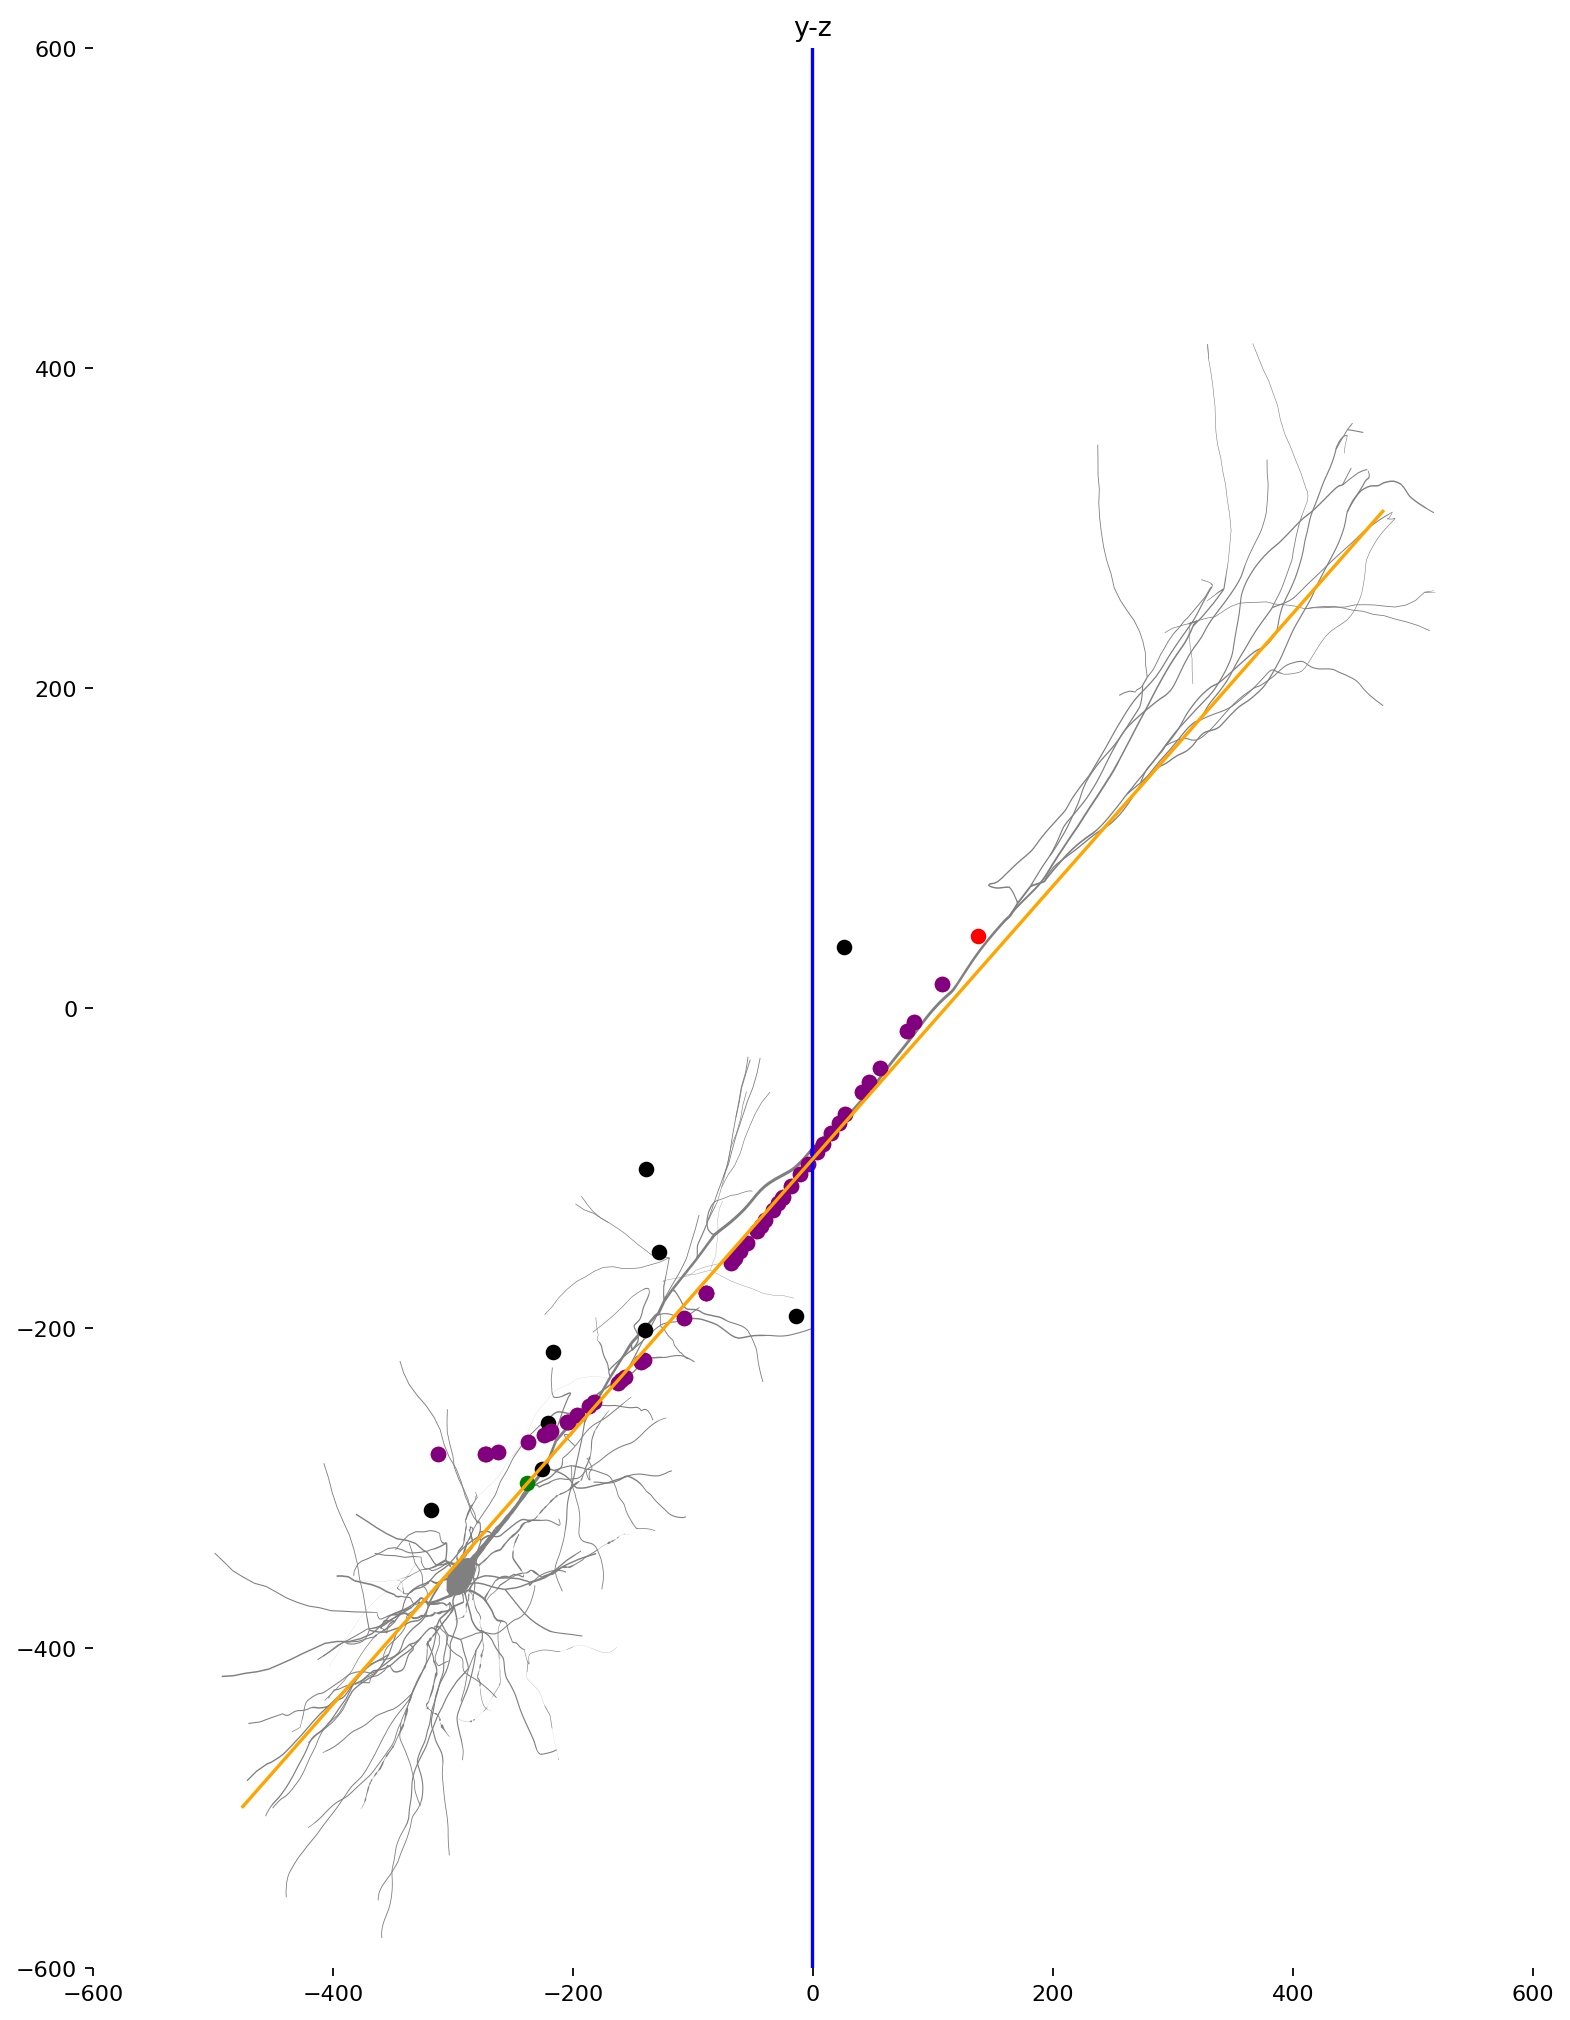

In [25]:
# Compute modified SVM for single cell
file_prefix = 'mag_templates_flattened_morphology_L5_TTPC1_cADpyr232_1_n300_'
mea_name = '400MEA50'
snr = 40
thresh = 0
template_id = 8
plot = True

# Modified SVM parameters
params = {}
params['min_dist'] = -25
params['max_dist'] = 25
params['num_points'] = 100
params['opp_dist'] = 10

# Load actual coordinates of cell
with open(f'{file_prefix}{mea_name}.npy', 'rb') as f:
    all_y = np.load(f)
    all_z = np.load(f)
    mags = np.load(f)

# Get electrode coordinates
elec_x, elec_y = get_electrodes2(mea_name)
xx, yy = make_meshgrid(np.array(elec_x), np.array(elec_y))

# Generate noise according to SNR parameter
noise = generate_noise(snr, mags[template_id], np.shape(mags[template_id]))

# Extract signals with magnitude that exceeds threshold
signals = mags[template_id] + noise
coords, targets = get_strong_signals(signals, elec_x, elec_y, thresh)

# Apply SVM to coordinates of strong signals 
model = svm.SVC(kernel="rbf")
clf = model.fit(coords, targets)
boundary = get_boundary_coords(xx, yy, clf)
dist, std, all_dists = get_apic_dist_real(template_id, all_y, all_z, xx, yy, clf, boundary = boundary)
print("Original dist: ", dist)

# Plot original SVM
tempgen = mr.tools.load_templates('ziad_mearec_templates/' + file_prefix + mea_name + '.h5', verbose=False)
cell = load_cell(template_id, tempgen)
if plot:
    fig, ax = plotcell_1plane_morph(cell, 1000, 1000)
    ax.set_xlim([-600, 600])
    ax.set_ylim([-600, 600])
    #out, Z = plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
Z = (Z != 0)

# Generate modified coordinates
# mod_coords, mod_targets = gen_modified_coords(clf, signals, elec_x, elec_y, xx, yy, coords, params)
# mod_model = svm.SVC(kernel='rbf')
# mod_clf = mod_model.fit(mod_coords, mod_targets)

# Estimate axon hillock and plot
ah_x, ah_y, new_coords = estimate_axon_hillock(signals, elec_x, elec_y, return_med = True)
if plot:
    ax.scatter(ah_x, ah_y, color='green')
    ax.scatter(new_coords[:, 0], new_coords[:, 1], color='black')

# mult = 2
# fit_coords = np.zeros((len(new_coords)*(mult+1), 2))
# fit_coords[:len(new_coords)*mult, 0] = ah_x
# fit_coords[:len(new_coords)*mult, 1] = ah_y
# fit_coords[len(new_coords)*mult:, 0] = new_coords[:, 0]
# fit_coords[len(new_coords)*mult:, 1] = new_coords[:, 1]
# m, b = np.polyfit(fit_coords[:, 0], fit_coords[:, 1], 1)

weight = 100
eps = 1.25
indices = np.arange(4, 200, 4)
new_coords = get_lbf_points(signals, indices, elec_x, elec_y)
cast_coords = cast_lbf_to_boundary(new_coords, boundary)

ax.scatter(cast_coords[:, 0], cast_coords[:, 1], color='red')

# Remove outliers
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(cast_coords)
distances, indices = nbrs.kneighbors(cast_coords)
avg_dists = np.mean(distances[:, 1:], axis=1)
max_range = 50
cast_coords_no_outliers = []
for i in range(len(avg_dists)):
    if avg_dists[i] < max_range:
        cast_coords_no_outliers.append(cast_coords[i])
cast_coords = np.array(cast_coords_no_outliers)

ax.scatter(cast_coords[:, 0], cast_coords[:, 1], color='purple')

m, b = calc_lbf(ah_x, ah_y, cast_coords, 'Huber', weight, eps = eps)
line_x_coords = np.linspace(np.min(elec_x), np.max(elec_x), 400)

if plot:
    ax.plot(line_x_coords, m*line_x_coords + b, color = 'blue')
    
m2, b2 = calc_lbf(ah_x, ah_y, cast_coords, 'Normal', weight)
line_x_coords = np.linspace(np.min(elec_x), np.max(elec_x), 400)

if plot:
    ax.plot(line_x_coords, m2*line_x_coords + b2, color = 'orange')
    
# weight = 1000
# fit_coords = np.zeros((len(new_coords)+1, 2))
# fit_coords[0, 0] = ah_x
# fit_coords[0, 1] = ah_y
# fit_coords[1:, 0] = new_coords[:, 0]
# fit_coords[1:, 1] = new_coords[:, 1]
# weights = np.ones((len(new_coords)+1,))
# weights[0] = weight
# m, b = np.polyfit(fit_coords[:, 0], fit_coords[:, 1], 1, w = weights)

# line_x_coords = np.linspace(np.min(elec_x), np.max(elec_x), 400)

# if plot:
#     ax.plot(line_x_coords, m*line_x_coords + b, color = 'orange')

# q = yy > (xx*m + b)
# print(np.unique(Z))
# greater_than_category = np.sum(q & Z)/np.sum(q) > 0.5

# # Points close to axon_hillock along line of best fit
# nearby_dists = np.arange(-5, 5.1, 0.01)*5

# # Find closest point to (ah_x, ah_y) on line
# b2 = ah_y + ah_x/m
# ah_x2 = (b2 - b)/(m + 1/m)
# ah_y2 = m*ah_x2 + b
# print(ah_x, ah_x2)

# # Get nearby points along line of best fit
# nearby_x = nearby_dists/np.sqrt(1 + m**2) + ah_x2
# nearby_y = m*nearby_x + b

# print(np.sqrt((nearby_x - ah_x2)**2 + (nearby_y - (ah_y2))**2))

# # Get one point one either side of each of those points along the line perpendicular to line of best fit
# b_vals = nearby_y + nearby_x/m
# opposite_dists = np.arange(-2, 2.1, 4)*5
# opposite_x = np.add.outer(opposite_dists/np.sqrt(1 + (1/m)**2), nearby_x)
# b_vals = np.ones(np.shape(opposite_x)) * b_vals
# opposite_y = -1*opposite_x / m + b_vals

# if plot:
#     ax.plot(opposite_x[0, :], opposite_y[0, :], color='purple')
#     ax.plot(opposite_x[1, :], opposite_y[1, :], color='green')

# #     ax.contourf(xx, yy, q, alpha = 0.4)

# # Re-calculate SVM with modified coordinates
# mod_coords = np.zeros((len(coords)+np.shape(opposite_x)[1]*np.shape(opposite_x)[0], 2))
# mod_coords[:len(coords), :] = coords
# mod_coords[len(coords):len(coords)+len(opposite_x[0]), 0] = opposite_x[0, :]
# mod_coords[len(coords):len(coords)+len(opposite_x[0]), 1] = opposite_y[0, :]
# mod_coords[len(coords) + len(opposite_x[0]):len(coords)+len(opposite_x[0])*2, 0] = opposite_x[1, :]
# mod_coords[len(coords) + len(opposite_x[0]):len(coords)+len(opposite_x[0])*2, 1] = opposite_y[1, :]

# mod_targets = np.zeros((len(mod_coords),))
# mod_targets[:len(targets)] = targets[:]
# mod_targets[len(targets):np.shape(opposite_x)[1] + len(targets)] = not greater_than_category
# mod_targets[len(targets) + np.shape(opposite_x)[1]:np.shape(opposite_x)[1]*2 + len(targets)] = greater_than_category

# sample_weights = np.ones((len(mod_targets),))
# sample_weights[len(targets):] = 1

# mod_model = svm.SVC(kernel="rbf")
# mod_clf = mod_model.fit(mod_coords, mod_targets)
# mod_boundary = get_boundary_coords(xx, yy, mod_clf)
# dist, std, all_dists_mod = get_apic_dist_real(template_id, all_y, all_z, xx, yy, clf, boundary = mod_boundary)
# print("Modified dist: ", dist)

# if plot:
#     fig, ax = plotcell_1plane_morph(cell, 1000, 1000)
#     out, Z = plot_contours(ax, mod_clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)

# print("Original Dists: ", all_dists[:10])
# print("Modified Dists: ", all_dists_mod[:10])

In [21]:
a = []
a.append([2, 0])
a.append([4, 3])
a.append([0, 0])
print(np.shape(np.array(a)))

(3, 2)


In [19]:
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(cast_coords)
distances, indices = nbrs.kneighbors(cast_coords)
avg_dists = np.mean(distances[:, 1:], axis=1)
print(np.shape(avg_dists))
print(np.shape(avg_dists[avg_dists < 50]))
print(indices)

(49,)
(44,)
[[ 0 34 32  4]
 [ 1 45 13  5]
 [ 2  5 26 39]
 [ 3 33 36  6]
 [ 4 32 34  0]
 [ 5  2 26 39]
 [ 6  3 33 47]
 [ 7 27 41  9]
 [28  8 25 15]
 [ 9 41 27  7]
 [10 14 15  8]
 [11 40 42 21]
 [12 17 19 37]
 [13 45  1  5]
 [14 10 15  8]
 [15  8 28 25]
 [16 47 18  6]
 [17 12 37 19]
 [18 16 47 35]
 [19 48 23 12]
 [20 46 36 38]
 [21 42 11 40]
 [22 30 13 45]
 [23 31 44 48]
 [24 43  1 45]
 [25 28  8 15]
 [26 39 40 11]
 [ 7 27 41  9]
 [28  8 25 15]
 [29 37 17 12]
 [30 22 13 45]
 [31 44 23 48]
 [32  4 34  0]
 [33  3 36  6]
 [ 0 34 32  4]
 [35 27  7 41]
 [36 33  3 20]
 [37 17 29 12]
 [38 46 20 44]
 [39 26 40 11]
 [40 11 39 21]
 [41  9 27  7]
 [21 42 11 40]
 [43 24  5  1]
 [44 31 23 48]
 [45  1 13  5]
 [46 20 38 36]
 [47 16 18  6]
 [48 23 31 44]]


[6.20201485] [711.35615046]
3.8625524871486423 535.3636293882597


/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_50921/2497002300.py:71: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot([xlim, xlim, -xlim, -xlim], [ylim, -ylim, ylim, -ylim], '.', marker='o', markersize=1, color='blue')


(-475.0, 475.0)

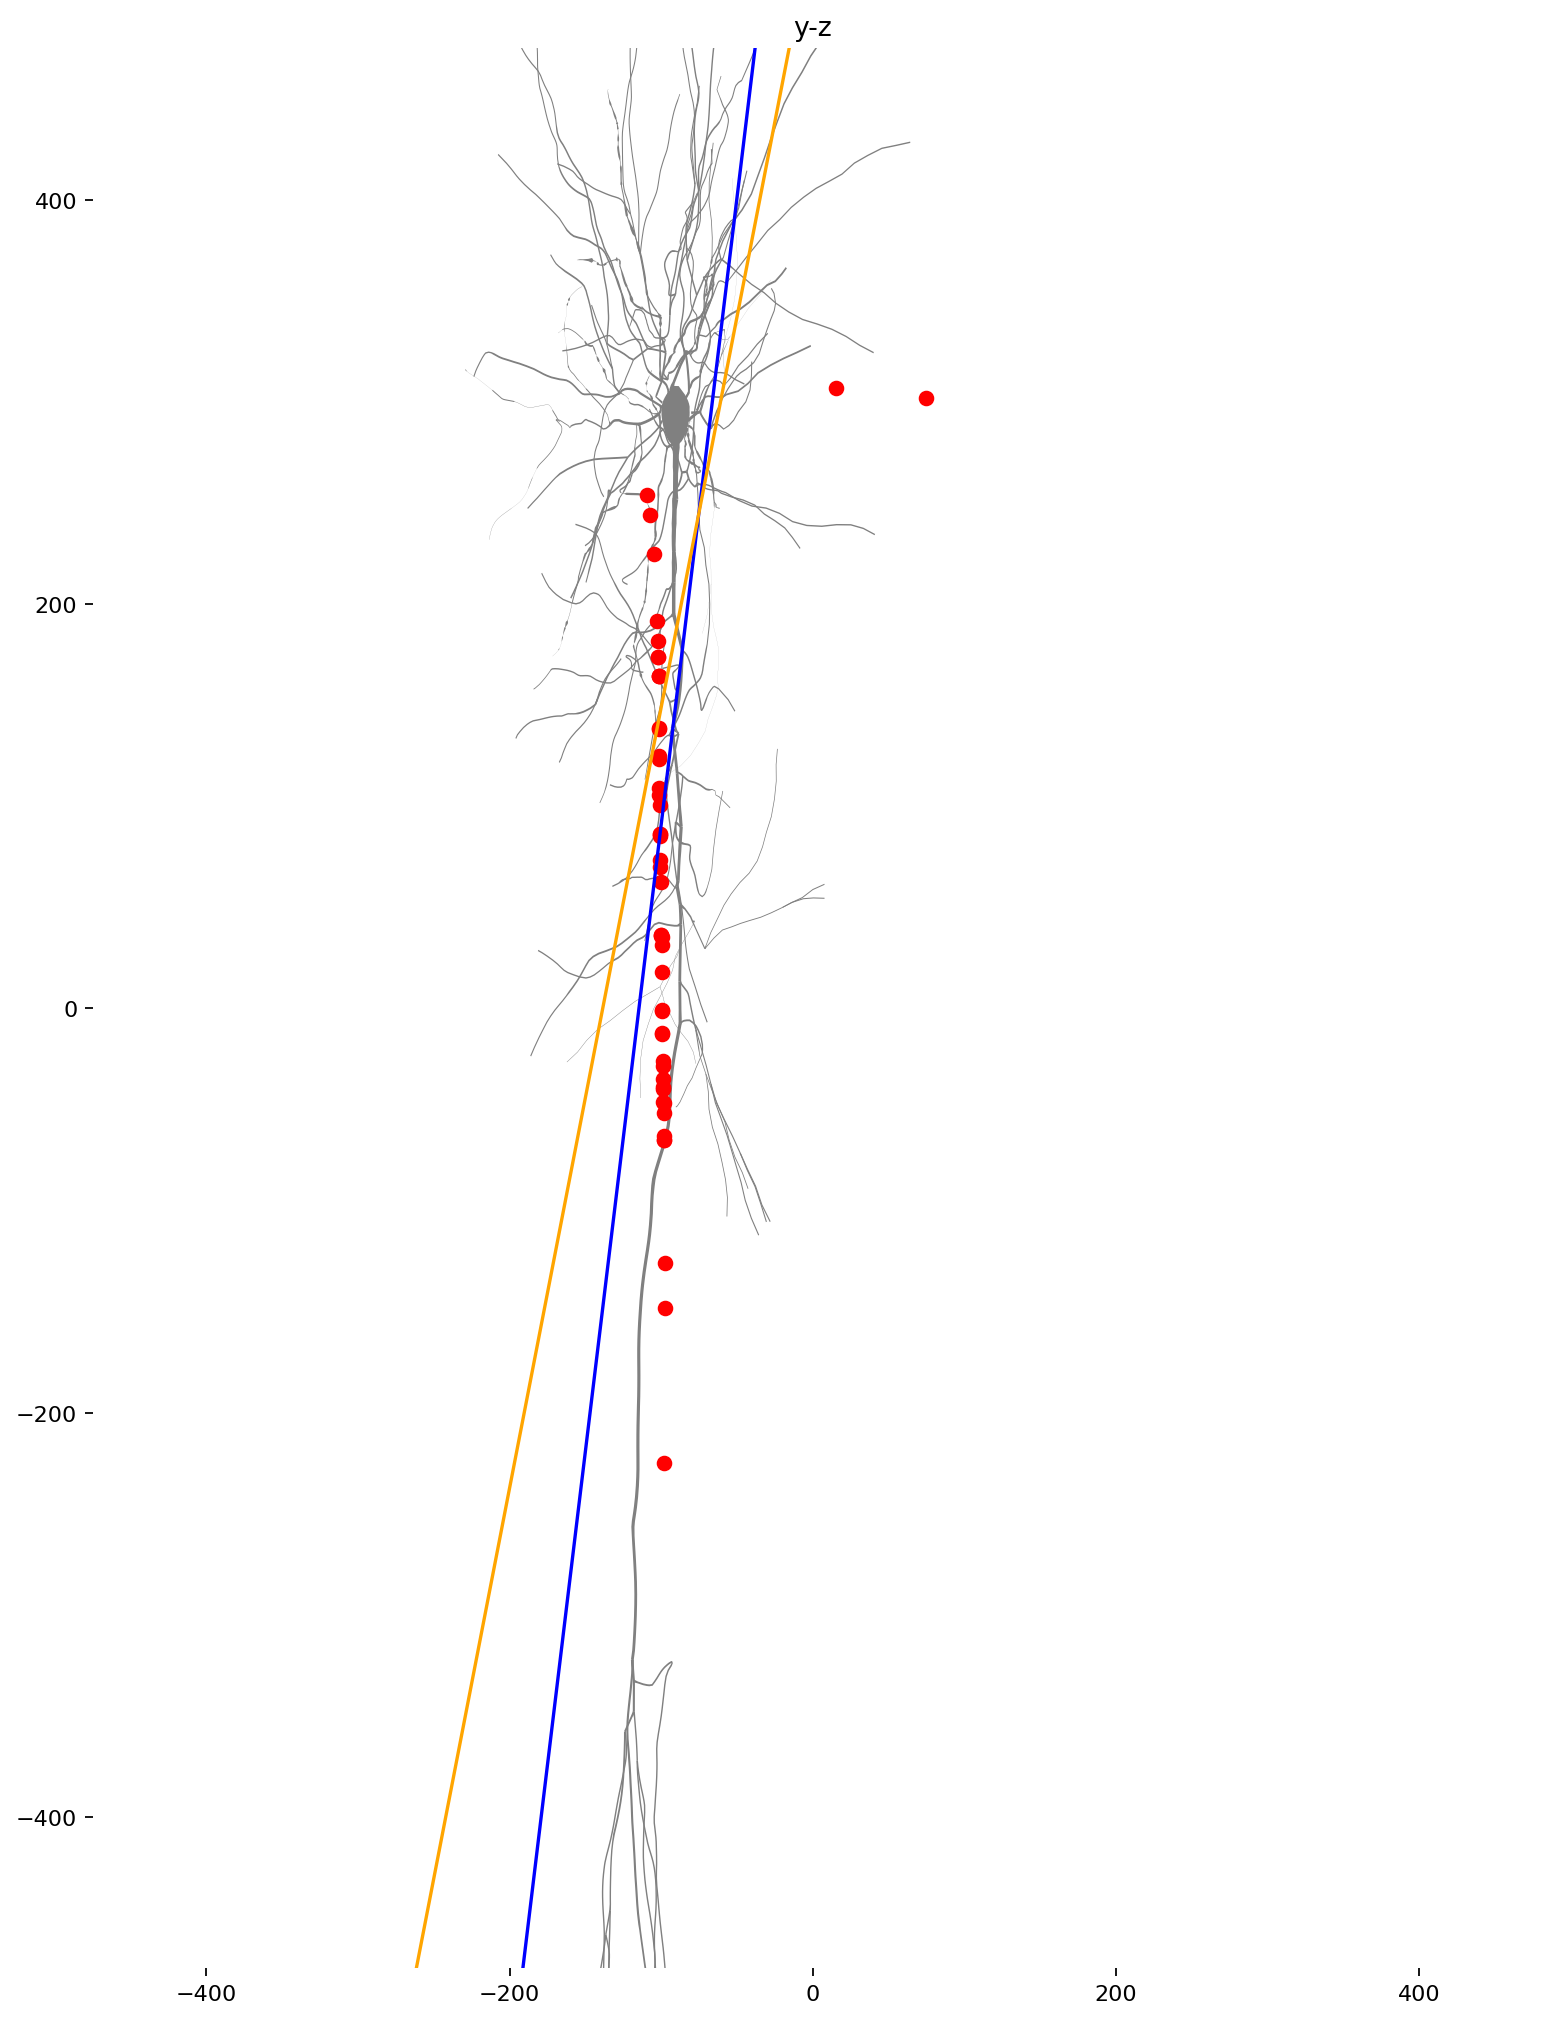

In [128]:
fig, ax = plotcell_1plane_morph(cell, 1000, 1000)
#out, Z = plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)

weight = 100
indices = np.arange(4, 200, 4)
new_coords = get_lbf_points(signals, indices, elec_x, elec_y)
cast_coords = cast_lbf_to_boundary(new_coords, boundary)
ax.scatter(cast_coords[:, 0], cast_coords[:, 1], color='red')

m, b = calc_lbf(ah_x, ah_y, cast_coords, 'Huber', weight, eps = 1.1)
print(m, b)
line_x_coords = np.linspace(-250, 150, 400)

if plot:
    plt.plot(line_x_coords, m*line_x_coords + b, color = 'blue')
    
m, b = calc_lbf(ah_x, ah_y, cast_coords, 'Normal', weight)
print(m, b)
line_x_coords = np.linspace(np.min(elec_x), np.max(elec_x), 400)

if plot:
    plt.plot(line_x_coords, m*line_x_coords + b, color = 'orange')
    
plt.xlim([-475, 475])
plt.ylim([-475, 475])

In [127]:
np.max(elec_x)

475.0

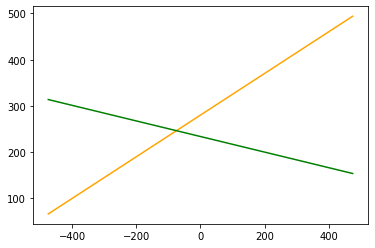

In [54]:
line_x_coords = np.linspace(np.min(elec_x), np.max(elec_x), 400)

m, b = calc_lbf(ah_x, ah_y, fit_coords[1:, :], 'Huber', 1000)
plt.plot(line_x_coords, m*line_x_coords + b, color = 'orange')

m, b = calc_lbf(ah_x, ah_y, fit_coords[1:, :], 'Normal', 1000)
plt.plot(line_x_coords, m*line_x_coords + b, color = 'green')

In [28]:
print(all_y[template_id, 0], all_z[template_id, 0])
soma = np.zeros((1, 2))
soma[0] = [all_y[template_id, 0], all_z[template_id, 0]]
print(boundary)
dist = distance.cdist(soma, boundary)
print(np.min(dist), np.argmin(dist))

42.77459716796875 -304.04217529296875
[[  35.25 -476.  ]
 [ 281.25 -476.  ]
 [  35.5  -475.75]
 ...
 [ 315.25  474.5 ]
 [ 315.25  475.  ]
 [ 315.25  475.5 ]]
101.85750876006766 1141


In [29]:
print(all_y[template_id, 0], all_z[template_id, 0])
soma = np.zeros((1, 2))
soma[0] = [all_y[template_id, 0], all_z[template_id, 0]]
print(boundary)
dist = distance.cdist(soma, mod_boundary)
print(np.min(dist), np.argmin(dist))

42.77459716796875 -304.04217529296875
[[  35.25 -476.  ]
 [ 281.25 -476.  ]
 [  35.5  -475.75]
 ...
 [ 315.25  474.5 ]
 [ 315.25  475.  ]
 [ 315.25  475.5 ]]
15.929971137942987 884


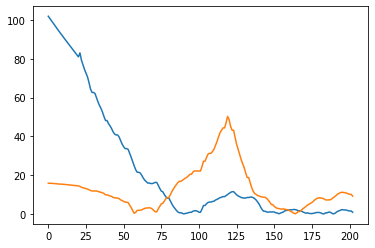

In [30]:
plt.plot(all_dists)
plt.plot(all_dists_mod)

In [13]:
a = np.zeros((3, 2))
a[0] = [0, 0]
a[1] = [2, 1]
a[2] = [-3, 2]

b = np.zeros((2, 2))
b[0] = [4, 5]
b[1] = [-4, 0]

np.min(distance.cdist(a, b), axis=1)

#get_apic_dist_real(template_id, all_y, all_z, xx, yy, clf, boundary = boundary)

array([4.        , 4.47213595, 2.23606798])

In [172]:
nearby_dists = np.arange(-5, 5.1, 1)

# Find closest point to (ah_x, ah_y) on line
b2 = ah_y + ah_x/m
ah_x2 = (b2 - b)/(m + 1/m)
ah_y2 = m*ah_x2 + b
print(ah_x, ah_x2)

# Get nearby points along line of best fit
nearby_x = nearby_dists/np.sqrt(1 + m**2) + ah_x2
nearby_y = m*nearby_x + b

print(np.sqrt((nearby_x - ah_x2)**2 + (nearby_y - (ah_y2))**2))

# Get one point one either side of each of those points along the line perpendicular to line of best fit
b_vals = nearby_y + nearby_x/m
opposite_dists = np.arange(-2, 2.1, 4)
print(nearby_x)
opposite_x = np.add.outer(opposite_dists/np.sqrt(1 + (1/m)**2), nearby_x)
b_vals = np.ones(np.shape(opposite_x)) * b_vals
opposite_y = -1*opposite_x / m + b_vals
print(opposite_y)

244.12238792845778 244.7829323408537
[5. 4. 3. 2. 1. 0. 1. 2. 3. 4. 5.]
[240.32043506 241.21293452 242.10543397 242.99793343 243.89043288
 244.78293234 245.6754318  246.56793125 247.46043071 248.35293017
 249.24542962]
[[-292.22210914 -292.67315761 -293.12420608 -293.57525454 -294.02630301
  -294.47735148 -294.92839995 -295.37944842 -295.83049689 -296.28154535
  -296.73259382]
 [-288.65211131 -289.10315978 -289.55420825 -290.00525672 -290.45630519
  -290.90735366 -291.35840212 -291.80945059 -292.26049906 -292.71154753
  -293.162596  ]]


In [193]:
np.shape(targets)

(400,)

In [191]:
mod_coords

array([[-475.        , -475.        ],
       [-475.        , -425.        ],
       [-475.        , -375.        ],
       [-475.        , -325.        ],
       [-475.        , -275.        ],
       [-475.        , -225.        ],
       [-475.        , -175.        ],
       [-475.        , -125.        ],
       [-475.        ,  -75.        ],
       [-475.        ,  -25.        ],
       [-475.        ,   25.        ],
       [-475.        ,   75.        ],
       [-475.        ,  125.        ],
       [-475.        ,  175.        ],
       [-475.        ,  225.        ],
       [-475.        ,  275.        ],
       [-475.        ,  325.        ],
       [-475.        ,  375.        ],
       [-475.        ,  425.        ],
       [-475.        ,  475.        ],
       [-425.        , -475.        ],
       [-425.        , -425.        ],
       [-425.        , -375.        ],
       [-425.        , -325.        ],
       [-425.        , -275.        ],
       [-425.        , -2

In [199]:
mod_targets = np.zeros((len(mod_coords),))
mod_targets[:len(targets)] = targets[:]
mod_targets[len(targets):np.shape(opposite_x)[1] + len(targets)] = not greater_than_category
mod_targets[len(targets) + np.shape(opposite_x)[1]:np.shape(opposite_x)[1]*2 + len(targets)] = greater_than_category
print(mod_targets[400:])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [200]:
greater_than_category

False

In [8]:
with open(f'mag_templates_flattened_morphology_L5_TTPC1_cADpyr232_1_n300_400MEA50.npy', 'rb') as f:
    all_y = np.load(f)
    all_z = np.load(f)
    mags = np.load(f)
    
elec_x, elec_y = get_electrodes2('400MEA50')

In [31]:
mags_pwr = np.sqrt(np.sum(mags[0]**2, axis=1))
mags_strong_indices = np.argsort(-1*mags_pwr)[:4]
mags_relative_pwr = mags_pwr[mags_strong_indices] / np.sum(mags_pwr[mags_strong_indices])

new_x = np.sum(elec_x[mags_strong_indices] * mags_relative_pwr)
new_y = np.sum(elec_y[mags_strong_indices] * mags_relative_pwr)

print(new_x, new_y)

161.80264149019138 -349.5288645466396


In [29]:
elec_x[mags_strong_indices] * mags_relative_pwr

array([54.40229825, 32.99339627, 38.81974123, 35.58720574])

### IGNORE EVERYTHING BELOW THIS POINT

In [45]:
dists_list = np.array(dists_list)
dists_std_list = np.array(dists_std_list)

print("Mean distance: ", np.mean(dists_list))
print("Mean std of dist: ", np.sqrt(np.mean(dists_std_list**2)))
print("Num fails: ", fails)

Mean distance:  65.34099260129712
Mean std of dist:  49.447791737789885
Num fails:  0


In [38]:
np.sqrt(np.mean(dists_std[:, 0]**2))

23.608866065726072

In [34]:
for i in range(len(dists)):
    mean_total = 0
    var_total = 0
    count = 0
    for j in range(len(dists[0])):
        if dists[i, j] < 1000000:
            mean_total += dists[i, j]
            var_total += dists_std[i, j]**2
            count += 1
    print(mean_total/count, '\t', np.sqrt(var_total/count))


50.0 	 12.0
25.651431416018383 	 14.581566836780036


In [33]:
dists[0, 1] = 60
dists[0, 2] = 1000000
dists_std[0] = 12

In [38]:
elec_y

array([-950., -850., -750., -650., -550., -450., -350., -250., -150.,
        -50.,   50.,  150.,  250.,  350.,  450.,  550.,  650.,  750.,
        850.,  950., -950., -850., -750., -650., -550., -450., -350.,
       -250., -150.,  -50.,   50.,  150.,  250.,  350.,  450.,  550.,
        650.,  750.,  850.,  950., -950., -850., -750., -650., -550.,
       -450., -350., -250., -150.,  -50.,   50.,  150.,  250.,  350.,
        450.,  550.,  650.,  750.,  850.,  950., -950., -850., -750.,
       -650., -550., -450., -350., -250., -150.,  -50.,   50.,  150.,
        250.,  350.,  450.,  550.,  650.,  750.,  850.,  950., -950.,
       -850., -750., -650., -550., -450., -350., -250., -150.,  -50.,
         50.,  150.,  250.,  350.,  450.,  550.,  650.,  750.,  850.,
        950., -950., -850., -750., -650., -550., -450., -350., -250.,
       -150.,  -50.,   50.,  150.,  250.,  350.,  450.,  550.,  650.,
        750.,  850.,  950., -950., -850., -750., -650., -550., -450.,
       -350., -250.,

In [39]:
electrodes = get_electrodes('400MEA75')
elec_x = electrodes.y
elec_y = electrodes.z

Mechanisms already loaded from path: /Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/mods.  Aborting.
template cADpyr232_L5_TTPC1_0fb1ca4724 exist already
Morphology:  morphology/dend-C060114A2_axon-C060114A5.asc
Type:  <class 'str'>
Morphology is a string


In [51]:
len(elec_x)

400

In [55]:
a, b = get_electrodes2('400MEA75')

In [56]:
len(a)

400

In [49]:
np.arange(-1*max_coord, max_coord+1, pitch)

array([-712.5, -637.5, -562.5, -487.5, -412.5, -337.5, -262.5, -187.5,
       -112.5,  -37.5,   37.5,  112.5,  187.5,  262.5,  337.5,  412.5,
        487.5,  562.5,  637.5,  712.5])

In [29]:
l1 = 100
l2 = 300
a = np.random.random(l1)
b = np.random.random(l2)
c = np.zeros(l1+l2)
c[:l1] = a
c[l1:] = b

print(np.std(a))
print(np.std(b))
print(np.std(c))

0.28761582209056064
0.28452962072054616
0.286229148203436


In [32]:
print(np.sqrt((np.std(a)**2*(l1-1) + np.std(b)**2*(l2-1))/(l1+l2-2)))
print(np.sqrt((np.std(a)**2*(l1) + np.std(b)**2*(l2))/(l1+l2)))

0.28530041323707606
0.28530430084339886


In [21]:
w = 1e-3
r = 1e-3

I = 10000e-9
N = 100
mu_r = 1000
f = 1e3

B_flux = w*np.log((r+w)/r)*I*2e-7
print(B_flux)
print(I*2e-7/(r+w/2))

emf = N*mu_r*B_flux*f
print(emf*1e9, 'nV')

1.3862943611198907e-15
1.3333333333333333e-09
138.62943611198907 nV
